## Import Libraries

In [153]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector as SFS

# Visualization
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

## Read Dataset

- Location of tasks
  - are specified by **latitude** and **longitude** together.
- **day**, **hour** and **minute** describe the task publish time.
- **Duration** denotes task active duration in terms of minutes.
- **Remaining time** denotes the residual time of a sensing task till its completion.
- **Resources** is percentage of battery required to complete a task.
- **Coverage** denotes task sensing distance.
- **Legitimacy** describes whether a task is illegitimate one or legitimate one.

### This features is used only in training of the machine learning models as the MCS platform is unaware of task legitimacy when a task is submitted.

- **GridNumber** is obtained by splitting sensing city map to small grids with numbers beginning at 1. 
- **OnpeakHour** is a binary flag to indicate if task start time occurs during 7am to 11am.
  - We define 7am to 11am as the **peak hour (1)**
  - and other hours are **non-peak (0)**

In [154]:
df = pd.read_csv("MCSDatasetNEXTCONLab.csv")
df.head()

ID   Latitude  Longitude  Day  Hour  Minute  Duration  RemainingTime  \
0   1  45.442142 -75.303369    1     4      13        40             40   
1   1  45.442154 -75.304366    1     4      23        40             30   
2   1  45.442104 -75.303963    1     4      33        40             20   
3   1  45.441868 -75.303577    1     4      43        40             10   
4   2  45.447727 -75.147722    2    15      49        30             30   

   Resources  Coverage  OnPeakHours  GridNumber  Ligitimacy  
0          9        91            0      131380           1  
1          9        91            0      131380           1  
2          9        91            0      121996           1  
3          9        91            0      121996           1  
4          5        47            0      140784           1

In [7]:
df['Ligitimacy'].unique()

array([1, 0])

#### Replace 0 with -1

In [155]:
df['Ligitimacy'] = df['Ligitimacy'].replace(0,-1)
df['Ligitimacy'].unique()

array([ 1, -1])

#### Split dataset to train and test

In [156]:
trDf = df[:10139][:]
teDf = df[10139:][:]

trDf = trDf.apply(lambda x: (x-45)*10000 if x.name == 'Latitude' else x)
trDf = trDf.apply(lambda x: (x+75)*10000 if x.name == 'Longitude' else x)
teDf = teDf.apply(lambda x: (x-45)*10000 if x.name == 'Latitude' else x)
teDf = teDf.apply(lambda x: (x+75)*10000 if x.name == 'Longitude' else x)

y_train = trDf['Ligitimacy'].values
y_test = teDf['Ligitimacy'].values

X_train = trDf.drop(columns=['ID', 'Day', 'Ligitimacy']).values
X_test = teDf.drop(columns=['ID', 'Day', 'Ligitimacy']).values

In [5]:
X_train.shape

(10139, 10)

### Visualize data

/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/shehata/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


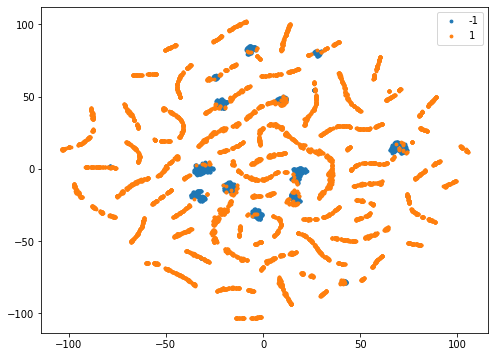

In [12]:
tr2d = TSNE(n_components=2, n_jobs=-1).fit_transform(X_train)
fig = plt.subplots(figsize =(8, 6))
for label in np.unique(y_train):
  plt.scatter(tr2d[y_train == label, 0], tr2d[y_train == label, 1], s= 8, label=label)
plt.legend()
plt.show()

### Method to print model accuracy

In [157]:
def print_accuracy(model, y_test, y_pred, X_test):
    
    print('\nClassification Report:\n')
    print(classification_report(y_test, y_pred))
    print("---------------------------------------------\n")

    acc = accuracy_score(y_test, y_pred) 
    print("Accuracy: {:.2f}\n".format(acc))
    
    fig, ax = plt.subplots(figsize=(7, 7))
    print('\nConfusion Matrix:')
    plot_confusion_matrix(model, X_test, y_test,
                          xticks_rotation='horizontal',
                          ax=ax, cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.show()
    
    return acc 

### Method to build models

In [158]:
def build_model(estimator_obj, X_train, X_test, y_train, y_test):

    model = estimator_obj.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    model_acc = print_accuracy(model, y_test, y_pred, X_test)
    
    return model, y_pred, round(model_acc,3)

# Part 2

  - Apply scaling to features (e.g. MinMaxScaler) before training your models.
  - Some of the hyperparameters are given below for MLPclassifier.
    - You should find the suitable values for other important parameters (e.g. learning rate, momentum).
  - Each MLPclassifier should be run 10 times (trained and tested 10 times) and average accuracy should beprovided to eliminate the effect of random initial conditions in MLP

# Q5

## 1.

### Min Max Scaler

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Grid search

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
parameters = {'batch_size': [32, 64, 128],
              'learning_rate':('constant', 'invscaling', 'adaptive'),
              'momentum': [0.2, 0.3, 0.5, 0.6, 0.9],
              'learning_rate_init': [0.1, 0.01, 0.2, 0.001]
             }

In [ ]:
mlp = MLPClassifier(random_state=1, early_stopping= True)
gs_cv = GridSearchCV(mlp, parameters)
gs_cv.fit(X_train_scaled, y_train)

/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
gs_cv.best_params_

MLP Model 1


Classification Report:

              precision    recall  f1-score   support

          -1       0.51      0.41      0.45       597
           1       0.91      0.94      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.71      0.67      0.69      4345
weighted avg       0.85      0.86      0.86      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


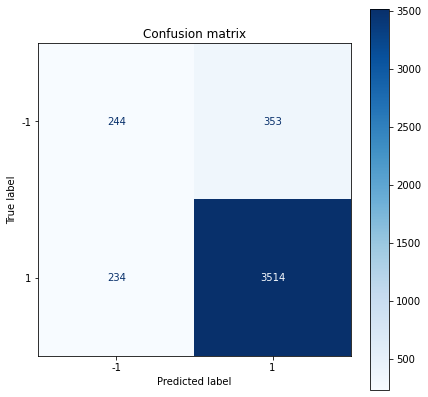

----------------------------------------------------------------------------

MLP Model 2


Classification Report:

              precision    recall  f1-score   support

          -1       0.58      0.36      0.45       597
           1       0.90      0.96      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.74      0.66      0.69      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


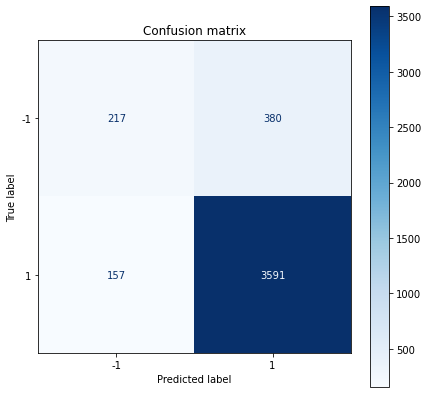

----------------------------------------------------------------------------

MLP Model 3


Classification Report:

              precision    recall  f1-score   support

          -1       0.48      0.43      0.46       597
           1       0.91      0.93      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.70      0.68      0.69      4345
weighted avg       0.85      0.86      0.86      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


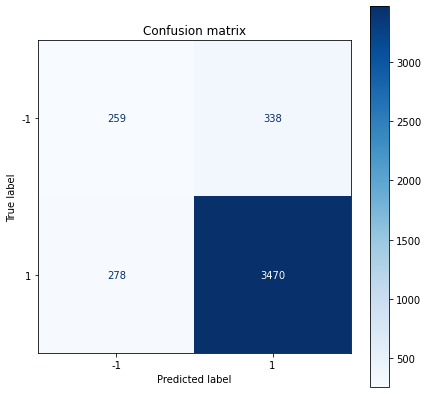

----------------------------------------------------------------------------

MLP Model 4


Classification Report:

              precision    recall  f1-score   support

          -1       0.65      0.48      0.55       597
           1       0.92      0.96      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.78      0.72      0.75      4345
weighted avg       0.88      0.89      0.89      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


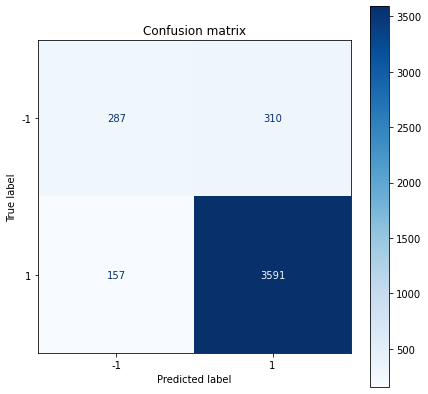

----------------------------------------------------------------------------

MLP Model 5


Classification Report:

              precision    recall  f1-score   support

          -1       0.70      0.38      0.49       597
           1       0.91      0.97      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.80      0.68      0.72      4345
weighted avg       0.88      0.89      0.88      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


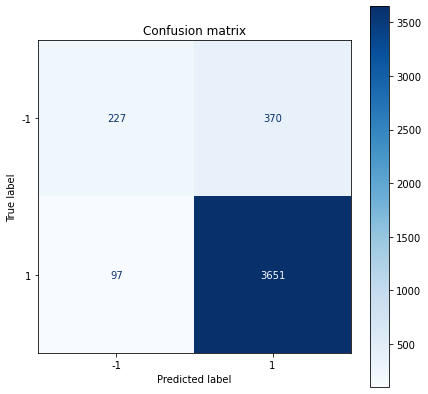

----------------------------------------------------------------------------

MLP Model 6


Classification Report:

              precision    recall  f1-score   support

          -1       0.72      0.58      0.64       597
           1       0.94      0.96      0.95      3748

    accuracy                           0.91      4345
   macro avg       0.83      0.77      0.80      4345
weighted avg       0.91      0.91      0.91      4345

---------------------------------------------

Accuracy: 0.91


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


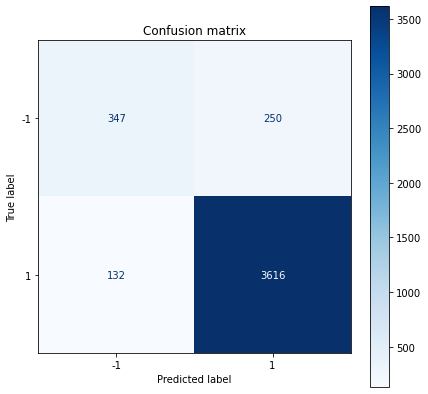

----------------------------------------------------------------------------

MLP Model 7


Classification Report:

              precision    recall  f1-score   support

          -1       0.54      0.43      0.48       597
           1       0.91      0.94      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.73      0.68      0.70      4345
weighted avg       0.86      0.87      0.87      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


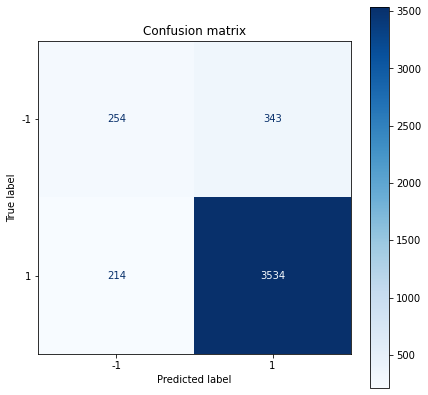

----------------------------------------------------------------------------

MLP Model 8


Classification Report:

              precision    recall  f1-score   support

          -1       0.73      0.57      0.64       597
           1       0.93      0.97      0.95      3748

    accuracy                           0.91      4345
   macro avg       0.83      0.77      0.80      4345
weighted avg       0.91      0.91      0.91      4345

---------------------------------------------

Accuracy: 0.91


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


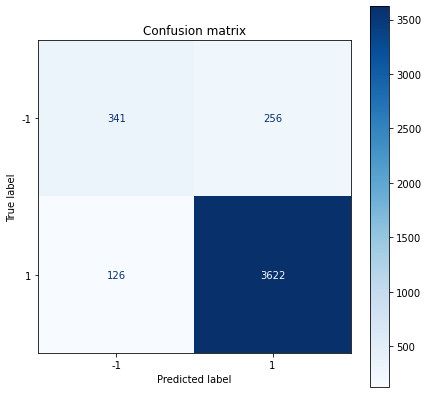

----------------------------------------------------------------------------

MLP Model 9


Classification Report:

              precision    recall  f1-score   support

          -1       0.65      0.51      0.57       597
           1       0.92      0.96      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.79      0.73      0.76      4345
weighted avg       0.89      0.90      0.89      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


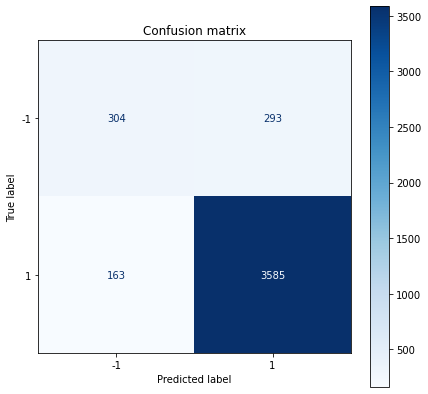

----------------------------------------------------------------------------

MLP Model 10


Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.50      0.56       597
           1       0.92      0.95      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.78      0.73      0.75      4345
weighted avg       0.88      0.89      0.89      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


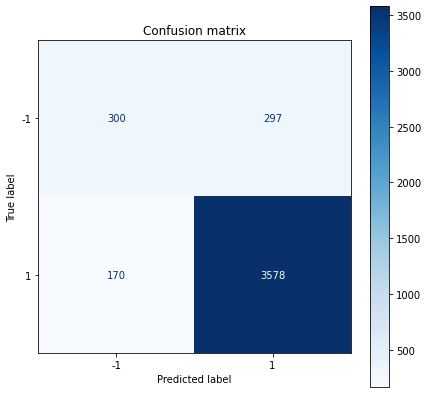

----------------------------------------------------------------------------



In [10]:
acc_baseline = []
models_num = []
for i in range(1,11):
    print("MLP Model {}\n".format(i))
    models_num.append(i)
    mlp = MLPClassifier(
                        activation='tanh',
                        batch_size= 64,
                        n_iter_no_change = 5,
                        learning_rate_init= 0.2,
                        momentum= 0.9,
                        solver= 'sgd',             
                        hidden_layer_sizes=(15,15))

    mlp_model1, mlp_pred1, mlp_acc1 = build_model(mlp, X_train_scaled, X_test_scaled, y_train, y_test)
    acc_baseline.append(mlp_acc1*100)
    print("----------------------------------------------------------------------------\n") 

In [11]:
max_acc_baseline = np.max(acc_baseline)
index_max_baseline = acc_baseline.index(max_acc_baseline)
print(max_acc_baseline)
print(index_max_baseline)

91.2
5


<function matplotlib.pyplot.show(close=None, block=None)>

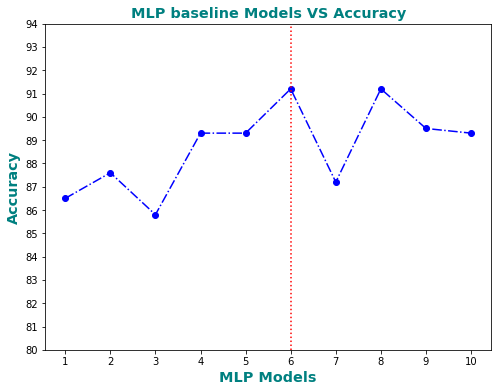

In [24]:
plt.figure(figsize=(8,6))

y_range = range(80,95)

axis_11 = plt.plot(models_num, acc_baseline, color='blue', marker='o', 
                   linestyle='dashdot')
plt.xlabel('MLP Models', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.ylabel('Accuracy', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.title('MLP baseline Models VS Accuracy', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.yticks(y_range)
plt.axvline(x= models_num[index_max_baseline], linestyle=':', color= 'red')
plt.xticks(models_num)
plt.show

In [25]:
avg_acc= round(np.mean(acc_baseline),2)
avg_acc_baseline = avg_acc 
print("Average Accuracy: {}".format(avg_acc_baseline))

baseline_acc = [avg_acc] * 6
print("Baseline Accuracy: {}\n".format(baseline_acc))

Average Accuracy: 88.69
Baseline Accuracy: [88.69, 88.69, 88.69, 88.69, 88.69, 88.69]



## 2

  #### 2.1 Find the best feature combination for MLP model by using wrapper method **SFS**

In [14]:
n_features = []
best_train_features = []
best_test_features = []
for i in tqdm(range(3, 9)):
    
    mlp2 = MLPClassifier(
                    activation='tanh',
                    batch_size= 64,
                    n_iter_no_change = 5,
                    learning_rate_init= 0.2,
                    momentum= 0.9,
                    solver= 'sgd',             
                    hidden_layer_sizes=(15,15))
    
    sfs = SFS(mlp2, n_features_to_select= i)
    sfs_train = sfs.fit_transform(X_train_scaled, y_train)
    sfs_test = sfs.fit_transform(X_test_scaled, y_test)
    
    n_features.append(i)
    best_train_features.append(sfs_train)
    best_test_features.append(sfs_test)
    
    

100%|██████████████████████████████████████████| 6/6 [1:19:15<00:00, 792.58s/it]


In [15]:
len(best_train_features)

6

#### 2.2 Train an MLP classifier on this dataset

In [16]:
acc_lst_best = []
acc_avg_all = []

for i in range(0,6):
    for j in range(0,10):
        
        mlp3 = MLPClassifier(
                            activation='tanh',
                            batch_size= 64,
                            n_iter_no_change = 5,
                            learning_rate_init= 0.2,
                            momentum= 0.2,
                            solver= 'sgd',             
                            hidden_layer_sizes=(15,15))

        mlp3.fit(best_train_features[i], y_train)
        _pred = mlp3.predict(best_test_features[i])

        acc_best = accuracy_score(y_test, _pred) 
        acc_lst_best.append(acc_best)
        print("Model {} with {} of feature Accuracy: {:.4f}\n".format(i+1, i+3, acc_best))
    acc_avg_all.append(acc_lst_best) 
    acc_lst_best = []
        

Model 1 with 3 of feature Accuracy: 0.9540

Model 1 with 3 of feature Accuracy: 0.8626

Model 1 with 3 of feature Accuracy: 0.8626



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 1 with 3 of feature Accuracy: 0.9402

Model 1 with 3 of feature Accuracy: 0.8626

Model 1 with 3 of feature Accuracy: 0.8626

Model 1 with 3 of feature Accuracy: 0.8985

Model 1 with 3 of feature Accuracy: 0.8626

Model 1 with 3 of feature Accuracy: 0.8626

Model 1 with 3 of feature Accuracy: 0.8626

Model 2 with 4 of feature Accuracy: 0.9583

Model 2 with 4 of feature Accuracy: 0.8649

Model 2 with 4 of feature Accuracy: 0.9091

Model 2 with 4 of feature Accuracy: 0.9047

Model 2 with 4 of feature Accuracy: 0.8667

Model 2 with 4 of feature Accuracy: 0.9142



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 2 with 4 of feature Accuracy: 0.9457

Model 2 with 4 of feature Accuracy: 0.9068

Model 2 with 4 of feature Accuracy: 0.8638

Model 2 with 4 of feature Accuracy: 0.8663



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 3 with 5 of feature Accuracy: 0.9091

Model 3 with 5 of feature Accuracy: 0.8617



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 3 with 5 of feature Accuracy: 0.9049



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 3 with 5 of feature Accuracy: 0.9192

Model 3 with 5 of feature Accuracy: 0.8638

Model 3 with 5 of feature Accuracy: 0.8608



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 3 with 5 of feature Accuracy: 0.9102

Model 3 with 5 of feature Accuracy: 0.8463



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 3 with 5 of feature Accuracy: 0.8962

Model 3 with 5 of feature Accuracy: 0.8621



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 4 with 6 of feature Accuracy: 0.8870

Model 4 with 6 of feature Accuracy: 0.8753



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 4 with 6 of feature Accuracy: 0.9015



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 4 with 6 of feature Accuracy: 0.9075



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 4 with 6 of feature Accuracy: 0.8792

Model 4 with 6 of feature Accuracy: 0.8647

Model 4 with 6 of feature Accuracy: 0.8732

Model 4 with 6 of feature Accuracy: 0.9144



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 4 with 6 of feature Accuracy: 0.8974



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 4 with 6 of feature Accuracy: 0.9155



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 5 with 7 of feature Accuracy: 0.9376

Model 5 with 7 of feature Accuracy: 0.9466

Model 5 with 7 of feature Accuracy: 0.8640



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 5 with 7 of feature Accuracy: 0.8976



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 5 with 7 of feature Accuracy: 0.9484



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 5 with 7 of feature Accuracy: 0.9530



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 5 with 7 of feature Accuracy: 0.9333

Model 5 with 7 of feature Accuracy: 0.9369

Model 5 with 7 of feature Accuracy: 0.8718

Model 5 with 7 of feature Accuracy: 0.9620



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 6 with 8 of feature Accuracy: 0.9167



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 6 with 8 of feature Accuracy: 0.8778



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 6 with 8 of feature Accuracy: 0.8909



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 6 with 8 of feature Accuracy: 0.8971



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 6 with 8 of feature Accuracy: 0.9033

Model 6 with 8 of feature Accuracy: 0.9056

Model 6 with 8 of feature Accuracy: 0.9086



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 6 with 8 of feature Accuracy: 0.8969



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model 6 with 8 of feature Accuracy: 0.9192

Model 6 with 8 of feature Accuracy: 0.9031



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#### Get the mean accuracy of each model after run 10 times
  - and extract the max accuracy to get the index of the best combinarions of features the gives the best accuracy

In [17]:
avg_lst = []
for i in range(len(acc_avg_all)):
    avg_acc = np.mean(acc_avg_all[i])*100
    avg_lst.append(avg_acc)
    print(round(avg_acc, 2))
    max_avg = np.max(avg_lst)
print("\nMax Acc: {:.4f}".format(max_avg))
index_max = avg_lst.index(max_avg)
print("\nindex of best combinations of features is: ",index_max)

88.31
90.0
88.34
89.16
92.51
90.19

Max Acc: 92.5132

index of best combinations of features is:  4


#### 2.3 Plot the number of features (X-axis) versus Accuracy (Y-axis) graph with baseline performance

<function matplotlib.pyplot.show(close=None, block=None)>

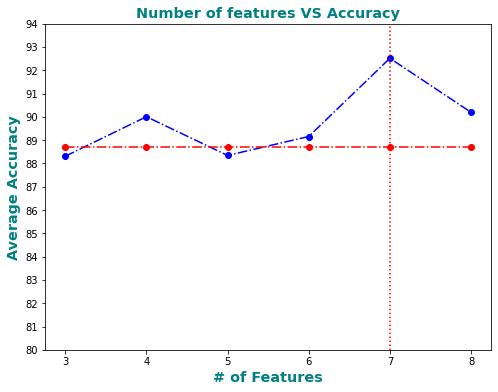

In [29]:
plt.figure(figsize=(8,6))

y_range = range(80,95)

axis_11 = plt.plot(n_features, avg_lst, color='blue', marker='o', 
                   linestyle='dashdot')

axis_22 = plt.plot(n_features, baseline_acc, color='red', marker='o',
                   linestyle='dashdot', label = 'Baseline')

plt.xlabel('# of Features', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.ylabel('Average Accuracy', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.title('Number of features VS Accuracy', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.yticks(y_range)
plt.axvline(x= n_features[index_max], linestyle=':', color= 'red')
plt.show

#### 2.4  Provide the accuracy and plot the confusion matrix forthe best results 
  
  - Run MLP on best combinations of features that gives best accuracy

Model 1 


Classification Report:

              precision    recall  f1-score   support

          -1       0.60      0.12      0.20       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.74      0.55      0.56      4345
weighted avg       0.84      0.87      0.83      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


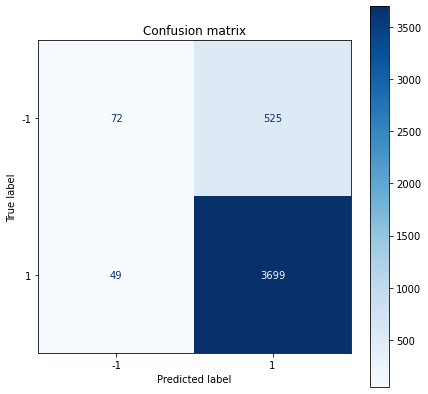

Model 2 


Classification Report:

              precision    recall  f1-score   support

          -1       0.82      0.75      0.78       597
           1       0.96      0.97      0.97      3748

    accuracy                           0.94      4345
   macro avg       0.89      0.86      0.87      4345
weighted avg       0.94      0.94      0.94      4345

---------------------------------------------

Accuracy: 0.94


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


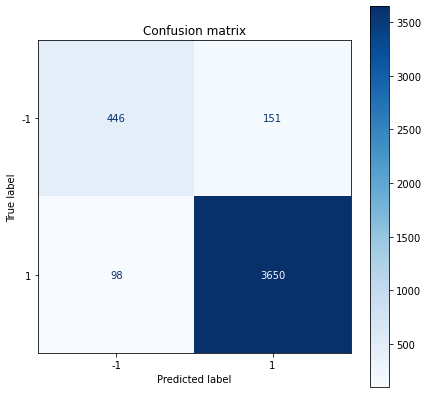

Model 3 



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



Classification Report:

              precision    recall  f1-score   support

          -1       0.85      0.64      0.73       597
           1       0.94      0.98      0.96      3748

    accuracy                           0.93      4345
   macro avg       0.90      0.81      0.85      4345
weighted avg       0.93      0.93      0.93      4345

---------------------------------------------

Accuracy: 0.93


Confusion Matrix:


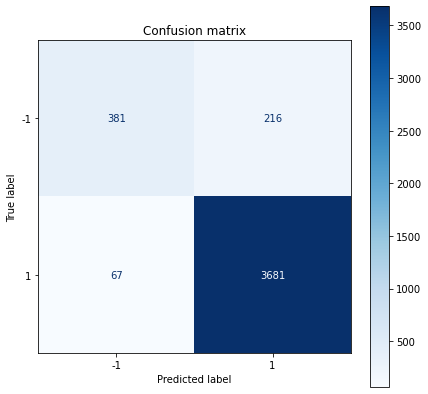

Model 4 


Classification Report:

              precision    recall  f1-score   support

          -1       0.80      0.64      0.71       597
           1       0.94      0.97      0.96      3748

    accuracy                           0.93      4345
   macro avg       0.87      0.81      0.84      4345
weighted avg       0.93      0.93      0.93      4345

---------------------------------------------

Accuracy: 0.93


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


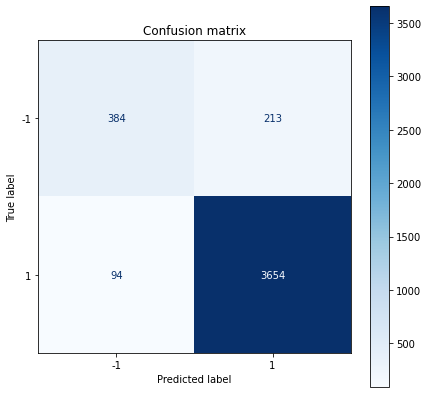

Model 5 


Classification Report:

              precision    recall  f1-score   support

          -1       0.78      0.55      0.65       597
           1       0.93      0.98      0.95      3748

    accuracy                           0.92      4345
   macro avg       0.86      0.76      0.80      4345
weighted avg       0.91      0.92      0.91      4345

---------------------------------------------

Accuracy: 0.92


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


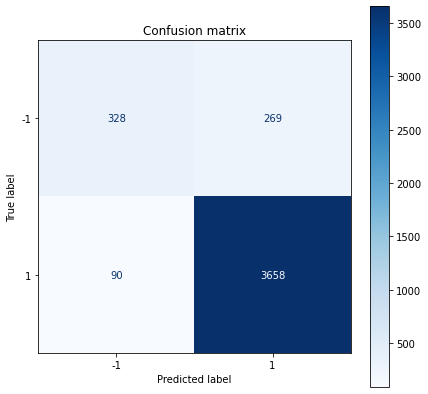

Model 6 



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



Classification Report:

              precision    recall  f1-score   support

          -1       0.83      0.67      0.74       597
           1       0.95      0.98      0.96      3748

    accuracy                           0.94      4345
   macro avg       0.89      0.83      0.85      4345
weighted avg       0.93      0.94      0.93      4345

---------------------------------------------

Accuracy: 0.94


Confusion Matrix:


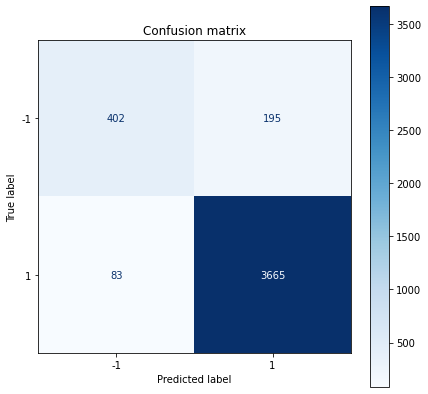

Model 7 


Classification Report:

              precision    recall  f1-score   support

          -1       0.81      0.69      0.75       597
           1       0.95      0.97      0.96      3748

    accuracy                           0.94      4345
   macro avg       0.88      0.83      0.85      4345
weighted avg       0.93      0.94      0.93      4345

---------------------------------------------

Accuracy: 0.94


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


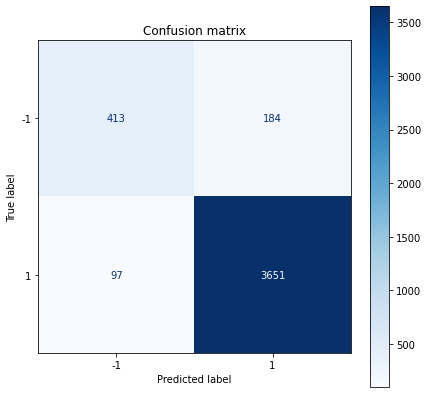

Model 8 



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



Classification Report:

              precision    recall  f1-score   support

          -1       0.82      0.63      0.71       597
           1       0.94      0.98      0.96      3748

    accuracy                           0.93      4345
   macro avg       0.88      0.80      0.84      4345
weighted avg       0.93      0.93      0.93      4345

---------------------------------------------

Accuracy: 0.93


Confusion Matrix:


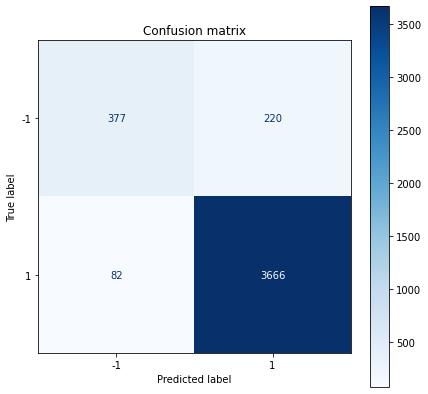

Model 9 


Classification Report:

              precision    recall  f1-score   support

          -1       0.81      0.66      0.73       597
           1       0.95      0.98      0.96      3748

    accuracy                           0.93      4345
   macro avg       0.88      0.82      0.84      4345
weighted avg       0.93      0.93      0.93      4345

---------------------------------------------

Accuracy: 0.93


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


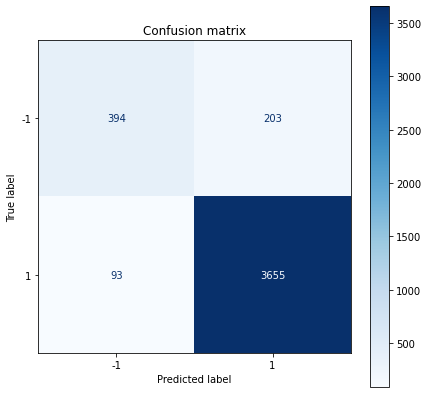

Model 10 



/home/shehata/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



Classification Report:

              precision    recall  f1-score   support

          -1       0.81      0.50      0.62       597
           1       0.92      0.98      0.95      3748

    accuracy                           0.92      4345
   macro avg       0.87      0.74      0.78      4345
weighted avg       0.91      0.92      0.91      4345

---------------------------------------------

Accuracy: 0.92


Confusion Matrix:


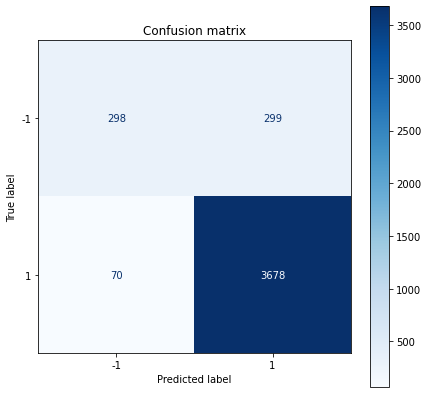

In [19]:
mlp4_accs = []
for i in range(0,10):  
    
    mlp4 = MLPClassifier(activation='tanh',
                        batch_size= 64,
                        n_iter_no_change = 5,
                        learning_rate_init= 0.2,
                        momentum= 0.2,
                        solver= 'sgd',             
                        hidden_layer_sizes=(15,15))
     
    print("Model {} \n".format(i+1))    
    mlp4_model, mlp4_pred, mlp4_acc = build_model(mlp4, 
                                                  best_train_features[index_max],
                                                  best_test_features[index_max],
                                                  y_train,
                                                  y_test)
    
    mlp4_accs.append(mlp4_acc)

In [120]:
avg_best_mlp_wrapper = np.mean(mlp4_accs)
mlp_wrapper_baseline = round(avg_best_mlp_wrapper*100,2)
mlp_wrapper_baseline

92.4

### Plot best MLP model from previous steps with baseline 

#### 2.5 plot bar chart for baseline accuracy vs accuracy of the best MLP model

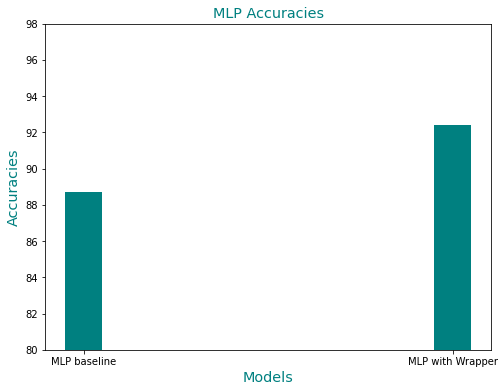

In [121]:
# Get the average accuracy of the best MLP
mlp4_avg_Acc= np.mean(mlp4_accs)*100

width =0.1 
plt.subplots(figsize=(8, 6))
plt.bar(['MLP baseline', 'MLP with Wrapper'],
        [avg_acc, mlp_wrapper_baseline],
        width= width,
        color ='teal')
plt.title('MLP Accuracies', fontsize = 'x-large', color = 'teal')
plt.ylabel('Accuracies', fontsize = 'x-large', color = 'teal')
plt.xlabel('Models', fontsize = 'x-large', color = 'teal')
plt.yticks(np.arange(80, 100, 2))
plt.ylim(ymin = 80)
plt.show()

# 3

In [128]:
from sklearn_som.som import SOM

best_train_mlp = best_train_features[index_max]
best_test_mlp = best_test_features[index_max]

# train_test = np.concatenate([best_train_mlp, best_test_mlp])
_, dim = best_train_mlp.shape

pred_train_list = [ ]
pred_test_list = [ ]
k = []
for i in tqdm(range(2, 9)):
    k.append(i)
    d_som = SOM(m = i, n = i, dim = dim)
    
    som_fit = d_som.fit(best_train_mlp)
    som_train_pred = d_som.predict(best_train_mlp)
    som_test_pred = d_som.predict(best_test_mlp)
    
    train_9 = np.insert(best_train_mlp, 0, som_train_pred, axis = 1)
    test_9 = np.insert(best_test_mlp, 0, som_test_pred, axis = 1)
    
    pred_train_list.append(train_9)
    pred_test_list.append(test_9)

100%|█████████████████████████████████████████████| 7/7 [00:14<00:00,  2.11s/it]


### Build MLP model with cluster label as extra feature

  0%|                                                     | 0/7 [00:00<?, ?it/s]

MLP Model 1

0

Classification Report:

              precision    recall  f1-score   support

          -1       0.69      0.04      0.07       597
           1       0.87      1.00      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.78      0.52      0.50      4345
weighted avg       0.84      0.87      0.81      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


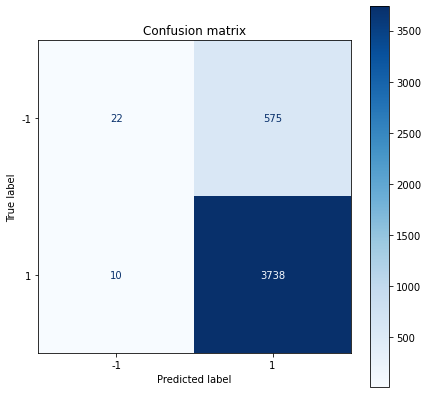

MLP Model 2

0

Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.24      0.35       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.77      0.61      0.64      4345
weighted avg       0.86      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


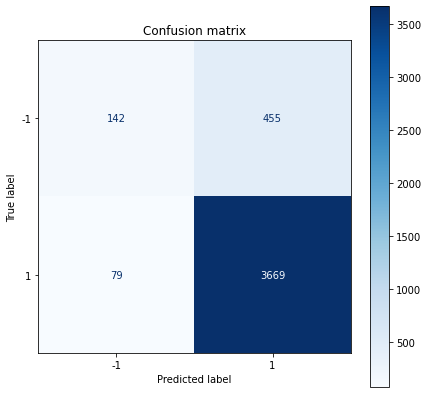

MLP Model 3

0

Classification Report:

              precision    recall  f1-score   support

          -1       0.53      0.51      0.52       597
           1       0.92      0.93      0.92      3748

    accuracy                           0.87      4345
   macro avg       0.72      0.72      0.72      4345
weighted avg       0.87      0.87      0.87      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


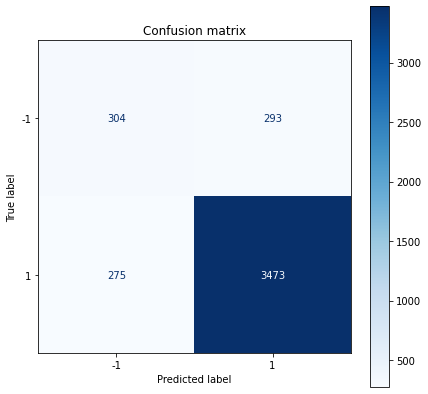

MLP Model 4

0

Classification Report:

              precision    recall  f1-score   support

          -1       0.77      0.59      0.67       597
           1       0.94      0.97      0.95      3748

    accuracy                           0.92      4345
   macro avg       0.85      0.78      0.81      4345
weighted avg       0.91      0.92      0.92      4345

---------------------------------------------

Accuracy: 0.92


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


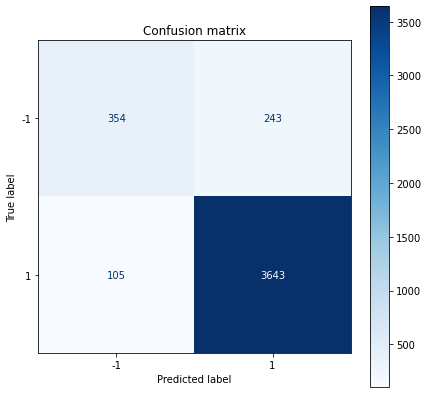

MLP Model 5

0

Classification Report:

              precision    recall  f1-score   support

          -1       0.62      0.25      0.36       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.75      0.61      0.64      4345
weighted avg       0.85      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


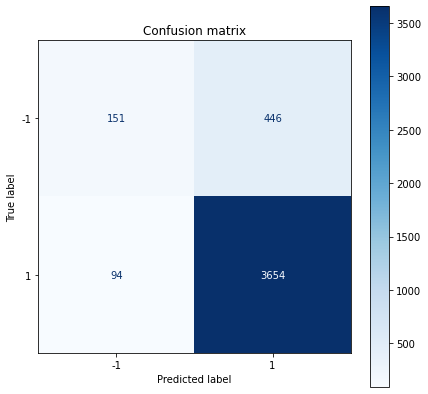

MLP Model 6

0

Classification Report:

              precision    recall  f1-score   support

          -1       0.74      0.69      0.71       597
           1       0.95      0.96      0.96      3748

    accuracy                           0.92      4345
   macro avg       0.84      0.83      0.83      4345
weighted avg       0.92      0.92      0.92      4345

---------------------------------------------

Accuracy: 0.92


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


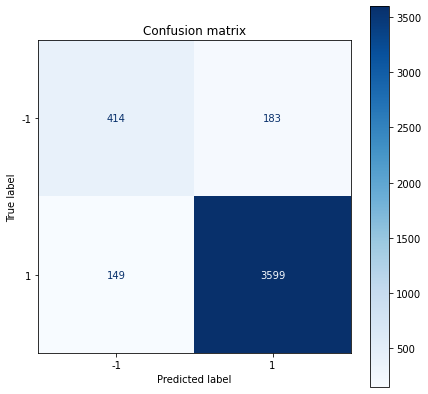

MLP Model 7

0

Classification Report:

              precision    recall  f1-score   support

          -1       0.68      0.08      0.14       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.77      0.54      0.53      4345
weighted avg       0.84      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


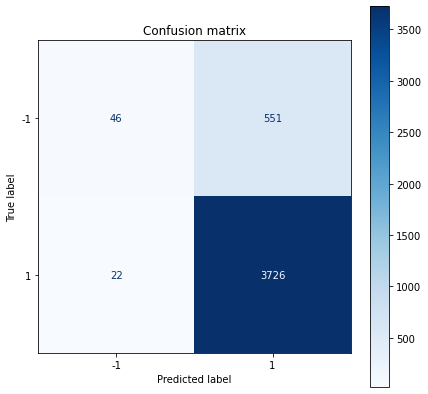

MLP Model 8

0

Classification Report:

              precision    recall  f1-score   support

          -1       0.48      0.40      0.43       597
           1       0.91      0.93      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.69      0.66      0.68      4345
weighted avg       0.85      0.86      0.85      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


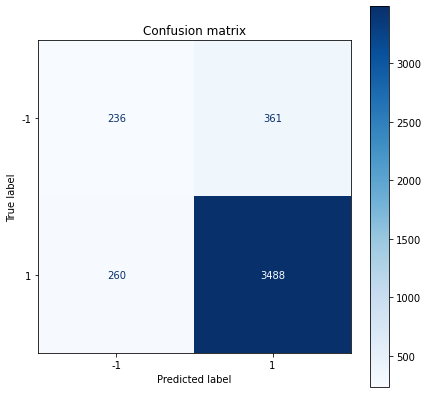

MLP Model 9

0

Classification Report:

              precision    recall  f1-score   support

          -1       0.67      0.25      0.37       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.78      0.62      0.65      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


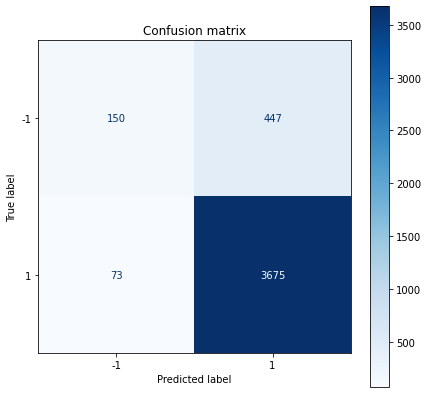

MLP Model 10

0

Classification Report:

              precision    recall  f1-score   support

          -1       0.81      0.37      0.51       597
           1       0.91      0.99      0.95      3748

    accuracy                           0.90      4345
   macro avg       0.86      0.68      0.73      4345
weighted avg       0.89      0.90      0.89      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


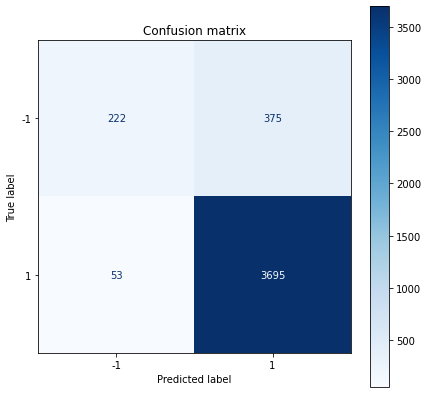

 14%|██████▍                                      | 1/7 [00:34<03:24, 34.02s/it]

----------------------------------------------------------------------------

MLP Model 1

1

Classification Report:

              precision    recall  f1-score   support

          -1       0.59      0.17      0.27       597
           1       0.88      0.98      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.74      0.58      0.60      4345
weighted avg       0.84      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


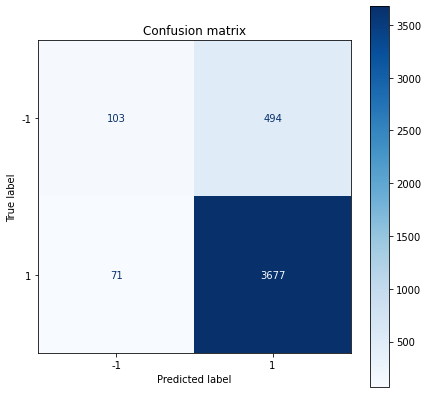

MLP Model 2

1

Classification Report:

              precision    recall  f1-score   support

          -1       0.75      0.17      0.28       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.82      0.58      0.61      4345
weighted avg       0.86      0.88      0.84      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


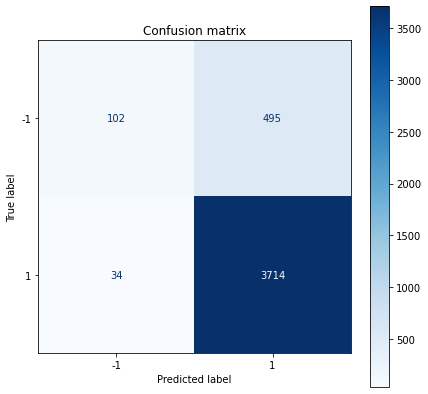

MLP Model 3

1

Classification Report:

              precision    recall  f1-score   support

          -1       0.84      0.20      0.32       597
           1       0.89      0.99      0.94      3748

    accuracy                           0.88      4345
   macro avg       0.86      0.59      0.63      4345
weighted avg       0.88      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


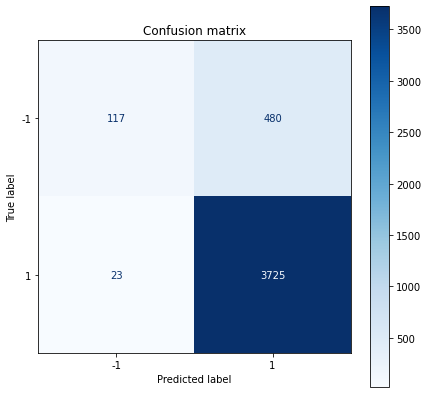

MLP Model 4

1

Classification Report:

              precision    recall  f1-score   support

          -1       0.59      0.26      0.36       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.74      0.61      0.64      4345
weighted avg       0.85      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


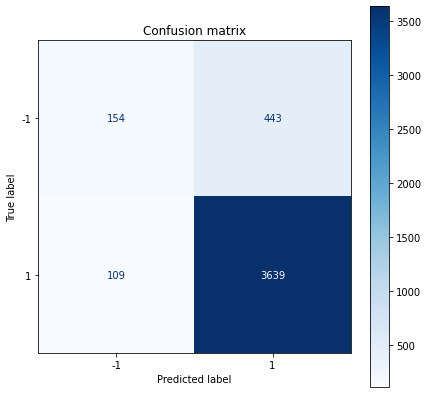

MLP Model 5

1

Classification Report:

              precision    recall  f1-score   support

          -1       0.86      0.13      0.22       597
           1       0.88      1.00      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.87      0.56      0.58      4345
weighted avg       0.87      0.88      0.84      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


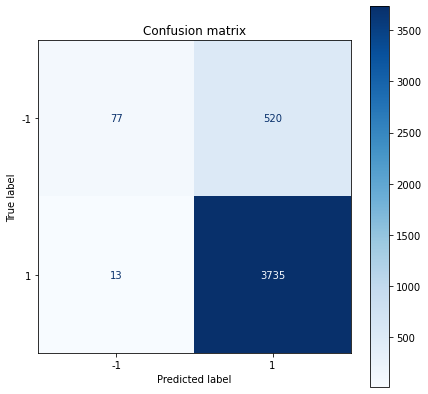

MLP Model 6

1

Classification Report:

              precision    recall  f1-score   support

          -1       0.63      0.31      0.41       597
           1       0.90      0.97      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.76      0.64      0.67      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


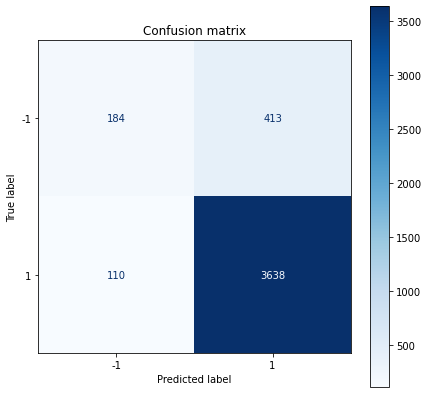

MLP Model 7

1

Classification Report:

              precision    recall  f1-score   support

          -1       0.73      0.20      0.32       597
           1       0.89      0.99      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.81      0.60      0.63      4345
weighted avg       0.86      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


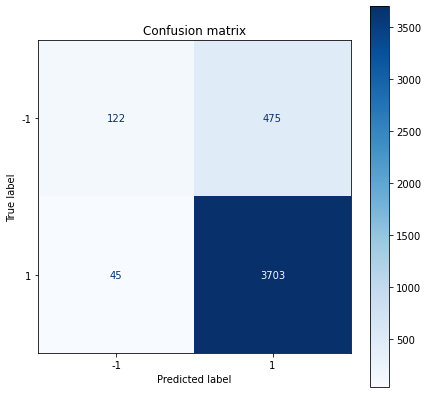

MLP Model 8

1

Classification Report:

              precision    recall  f1-score   support

          -1       0.79      0.14      0.24       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.84      0.57      0.59      4345
weighted avg       0.87      0.88      0.84      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


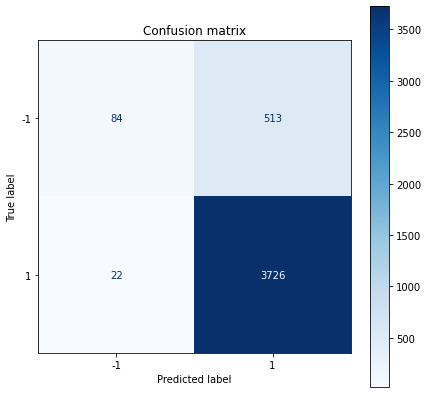

MLP Model 9

1

Classification Report:

              precision    recall  f1-score   support

          -1       0.62      0.08      0.14       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.75      0.54      0.54      4345
weighted avg       0.84      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


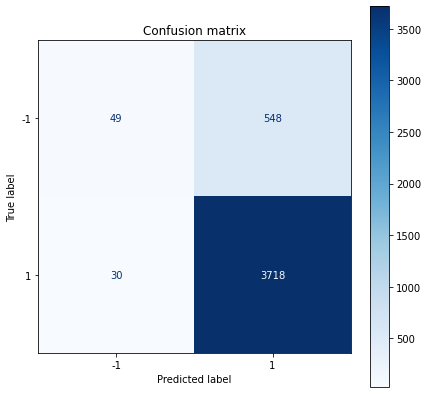

MLP Model 10

1

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

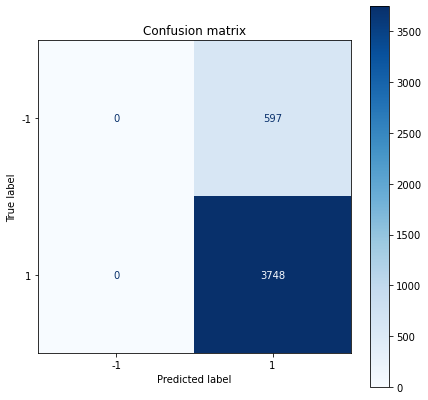

 29%|████████████▊                                | 2/7 [01:15<03:13, 38.61s/it]

----------------------------------------------------------------------------

MLP Model 1

2

Classification Report:

              precision    recall  f1-score   support

          -1       0.57      0.11      0.18       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.72      0.55      0.56      4345
weighted avg       0.83      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


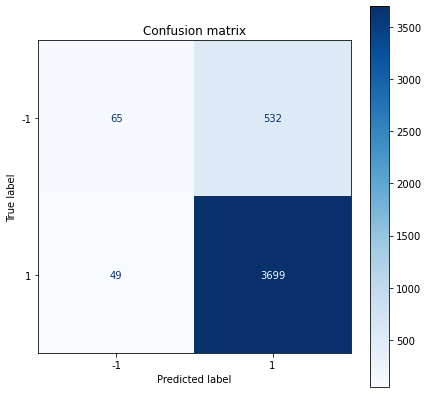

MLP Model 2

2

Classification Report:

              precision    recall  f1-score   support

          -1       0.46      0.13      0.20       597
           1       0.88      0.98      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.67      0.55      0.56      4345
weighted avg       0.82      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


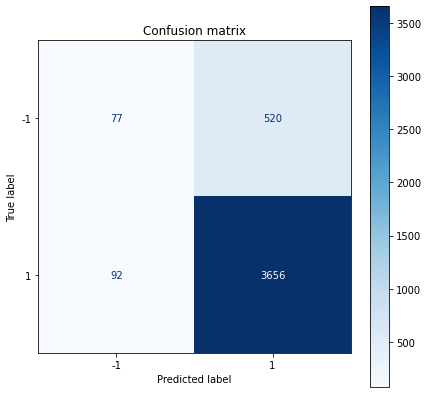

MLP Model 3

2

Classification Report:

              precision    recall  f1-score   support

          -1       0.50      0.11      0.19       597
           1       0.87      0.98      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.69      0.55      0.56      4345
weighted avg       0.82      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


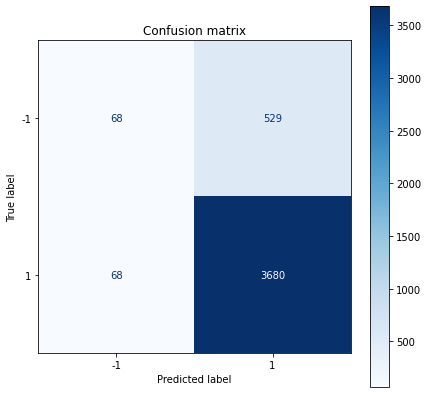

MLP Model 4

2

Classification Report:

              precision    recall  f1-score   support

          -1       0.55      0.23      0.33       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.72      0.60      0.63      4345
weighted avg       0.84      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


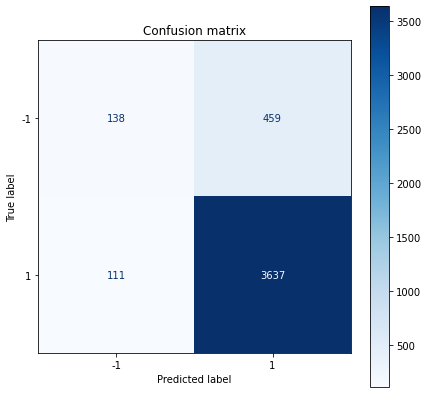

MLP Model 5

2

Classification Report:

              precision    recall  f1-score   support

          -1       0.54      0.14      0.23       597
           1       0.88      0.98      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.71      0.56      0.58      4345
weighted avg       0.83      0.87      0.83      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


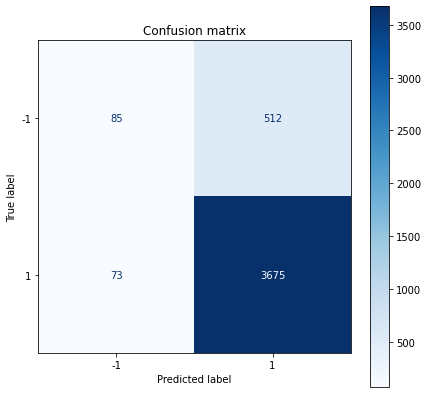

MLP Model 6

2

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

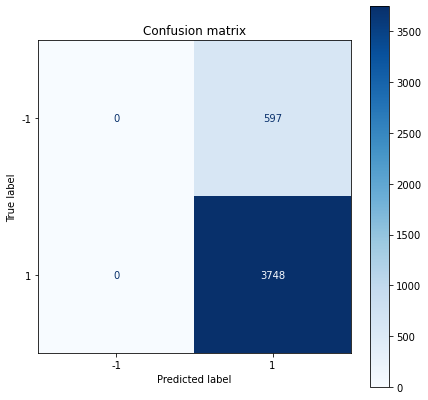

MLP Model 7

2

Classification Report:

              precision    recall  f1-score   support

          -1       0.66      0.09      0.16       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.77      0.54      0.55      4345
weighted avg       0.84      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


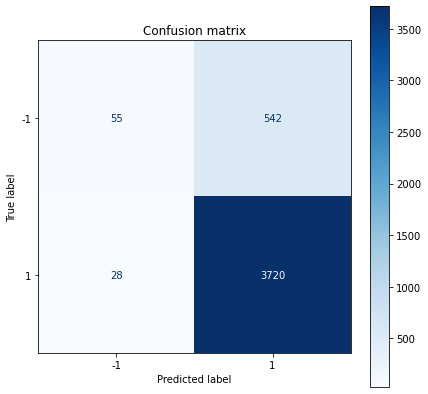

MLP Model 8

2

Classification Report:

              precision    recall  f1-score   support

          -1       0.67      0.00      0.01       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.76      0.50      0.47      4345
weighted avg       0.84      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


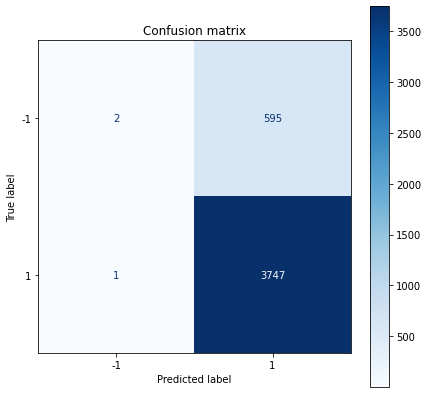

MLP Model 9

2

Classification Report:

              precision    recall  f1-score   support

          -1       0.55      0.21      0.30       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.72      0.59      0.62      4345
weighted avg       0.84      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


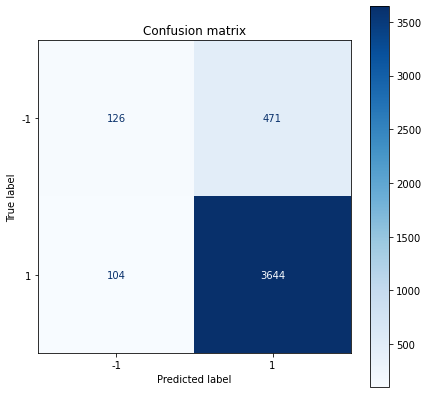

MLP Model 10

2

Classification Report:

              precision    recall  f1-score   support

          -1       0.41      0.04      0.07       597
           1       0.87      0.99      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.64      0.51      0.50      4345
weighted avg       0.80      0.86      0.81      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


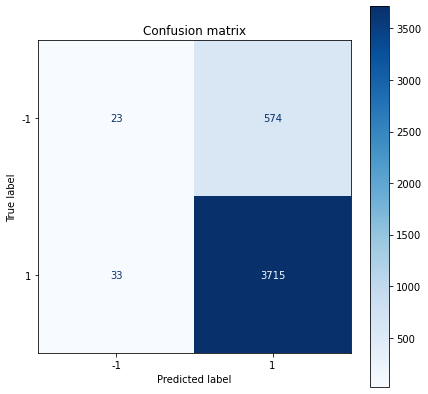

 43%|███████████████████▎                         | 3/7 [01:51<02:28, 37.18s/it]

----------------------------------------------------------------------------

MLP Model 1

3

Classification Report:

              precision    recall  f1-score   support

          -1       0.39      0.02      0.03       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.63      0.51      0.48      4345
weighted avg       0.80      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


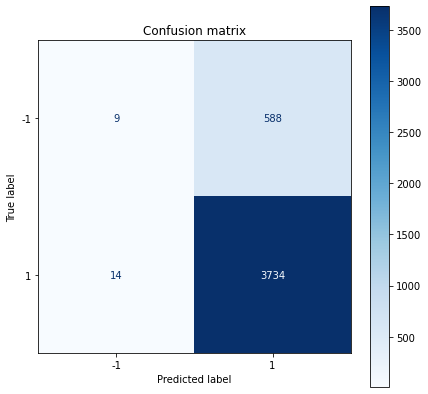

MLP Model 2

3

Classification Report:

              precision    recall  f1-score   support

          -1       0.78      0.27      0.41       597
           1       0.90      0.99      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.84      0.63      0.67      4345
weighted avg       0.88      0.89      0.87      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


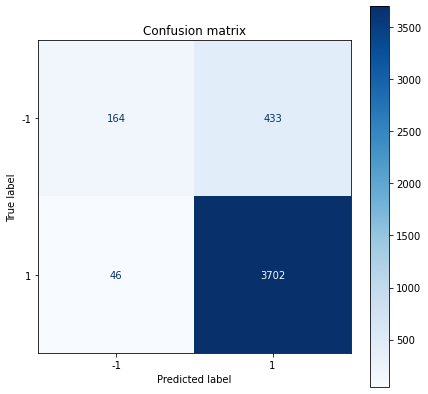

MLP Model 3

3

Classification Report:

              precision    recall  f1-score   support

          -1       0.71      0.26      0.38       597
           1       0.89      0.98      0.94      3748

    accuracy                           0.88      4345
   macro avg       0.80      0.62      0.66      4345
weighted avg       0.87      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


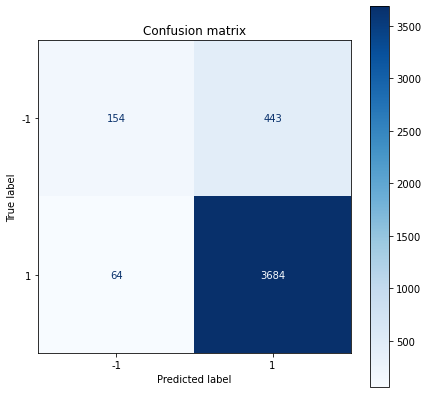

MLP Model 4

3

Classification Report:

              precision    recall  f1-score   support

          -1       0.07      0.00      0.00       597
           1       0.86      1.00      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.47      0.50      0.46      4345
weighted avg       0.75      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


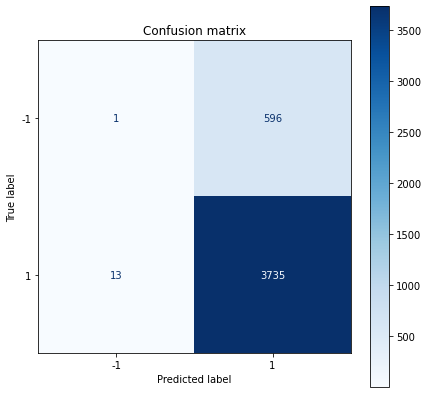

MLP Model 5

3

Classification Report:

              precision    recall  f1-score   support

          -1       0.67      0.28      0.40       597
           1       0.90      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.78      0.63      0.67      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


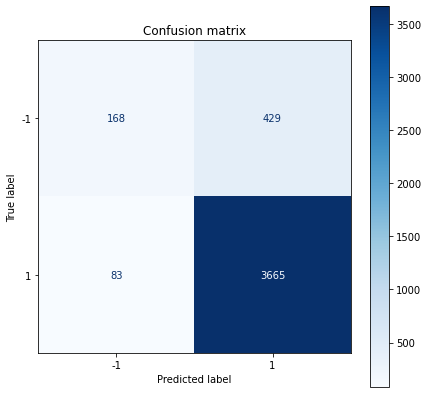

MLP Model 6

3

Classification Report:

              precision    recall  f1-score   support

          -1       0.70      0.21      0.33       597
           1       0.89      0.99      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.79      0.60      0.63      4345
weighted avg       0.86      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


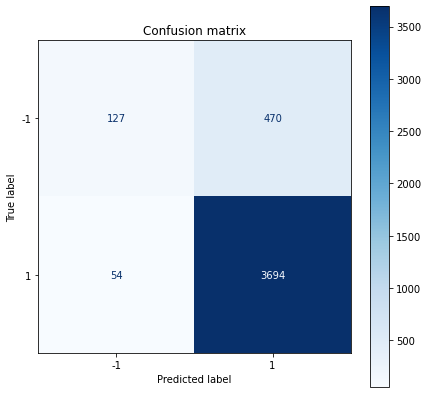

MLP Model 7

3

Classification Report:

              precision    recall  f1-score   support

          -1       0.60      0.27      0.37       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.75      0.62      0.65      4345
weighted avg       0.85      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


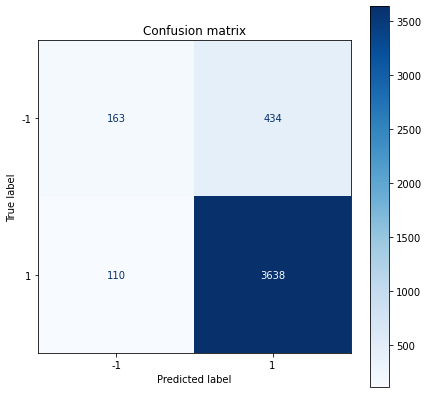

MLP Model 8

3

Classification Report:

              precision    recall  f1-score   support

          -1       0.44      0.02      0.04       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.65      0.51      0.48      4345
weighted avg       0.81      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


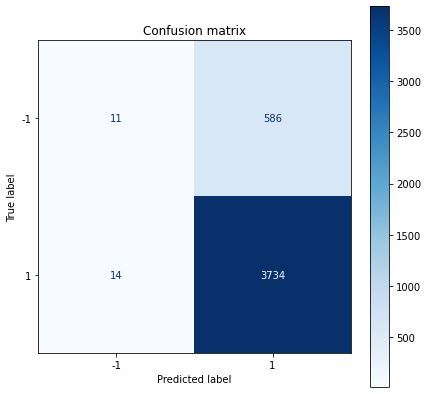

MLP Model 9

3

Classification Report:

              precision    recall  f1-score   support

          -1       0.73      0.25      0.37       597
           1       0.89      0.99      0.94      3748

    accuracy                           0.88      4345
   macro avg       0.81      0.62      0.65      4345
weighted avg       0.87      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


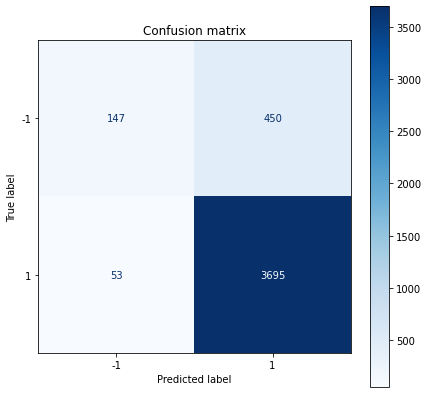

MLP Model 10

3

Classification Report:

              precision    recall  f1-score   support

          -1       0.61      0.18      0.28       597
           1       0.88      0.98      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.75      0.58      0.60      4345
weighted avg       0.84      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


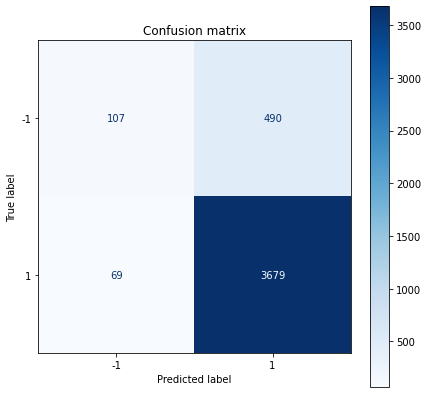

 57%|█████████████████████████▋                   | 4/7 [02:22<01:44, 34.72s/it]

----------------------------------------------------------------------------

MLP Model 1

4

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

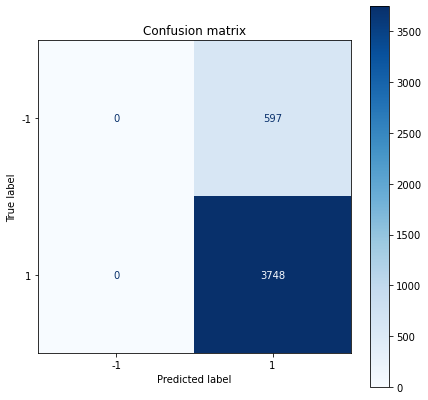

MLP Model 2

4

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

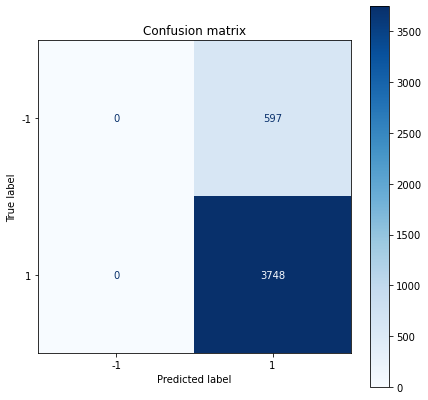

MLP Model 3

4

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

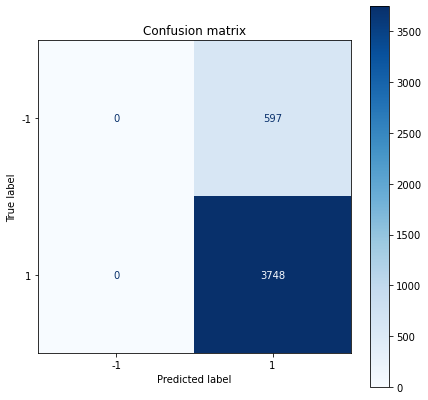

MLP Model 4

4

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

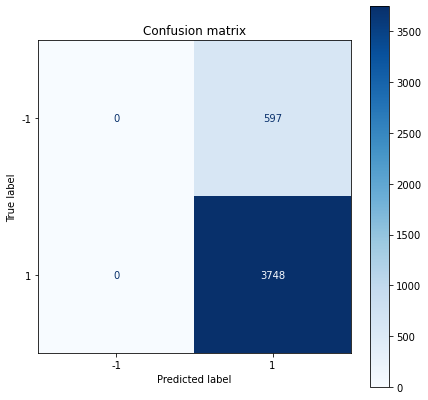

MLP Model 5

4

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

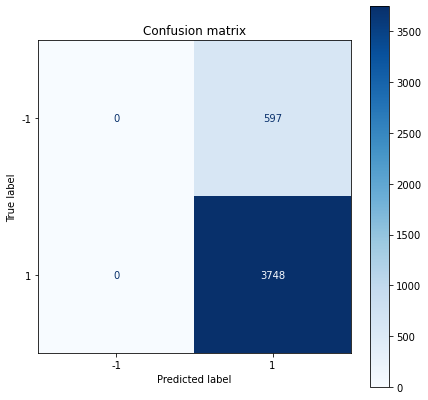

MLP Model 6

4

Classification Report:

              precision    recall  f1-score   support

          -1       0.80      0.01      0.01       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.83      0.50      0.47      4345
weighted avg       0.85      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


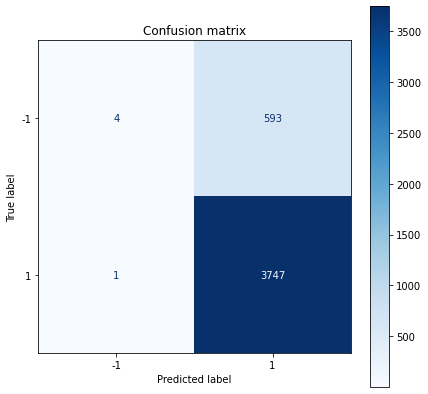

MLP Model 7

4

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

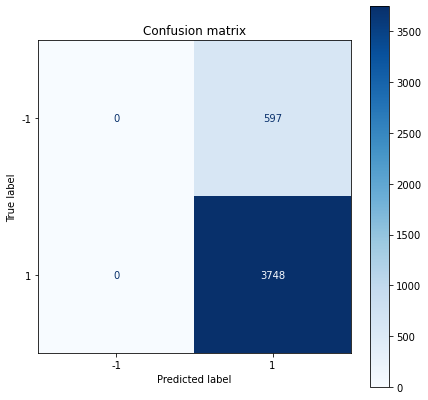

MLP Model 8

4

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

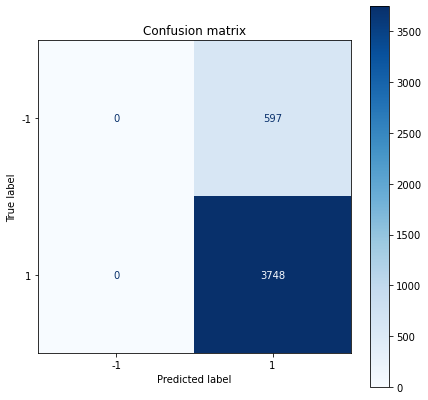

MLP Model 9

4

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

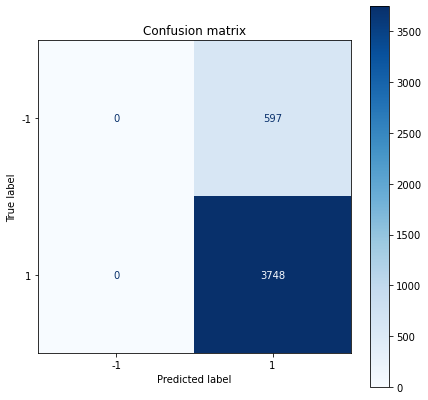

MLP Model 10

4

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

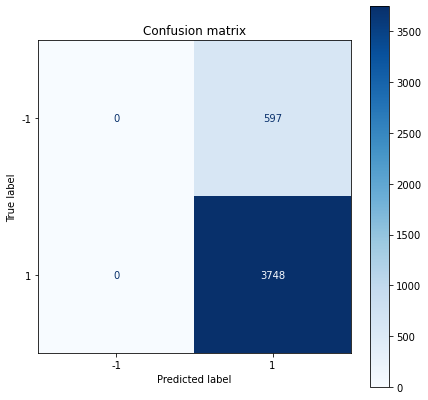

 71%|████████████████████████████████▏            | 5/7 [02:38<00:56, 28.03s/it]

----------------------------------------------------------------------------

MLP Model 1

5

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

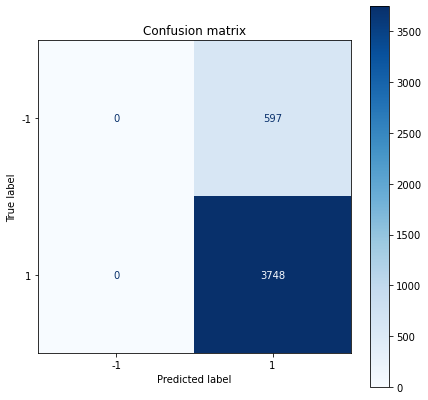

MLP Model 2

5

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

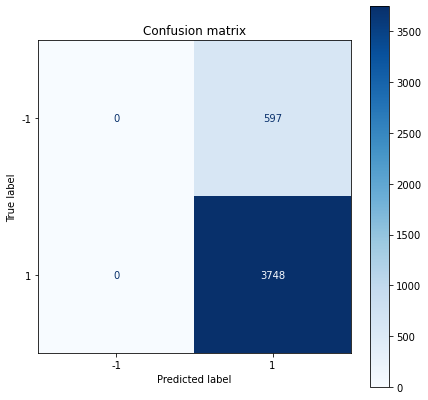

MLP Model 3

5

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

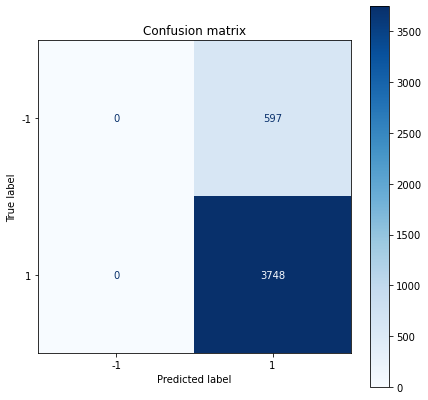

MLP Model 4

5

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

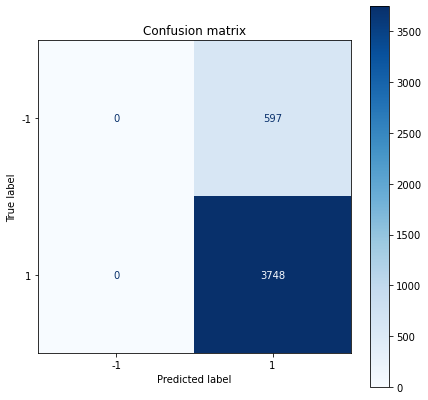

MLP Model 5

5

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

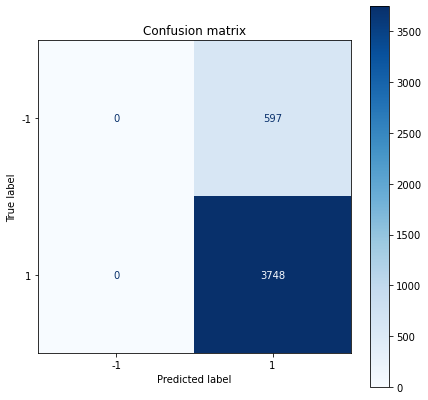

MLP Model 6

5

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

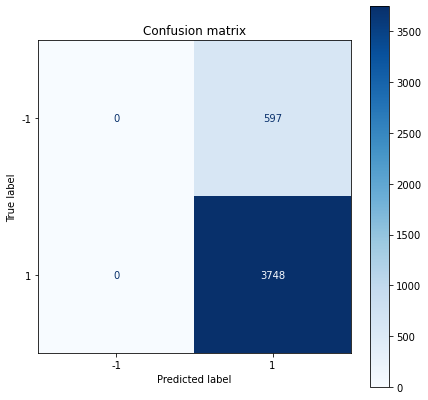

MLP Model 7

5

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

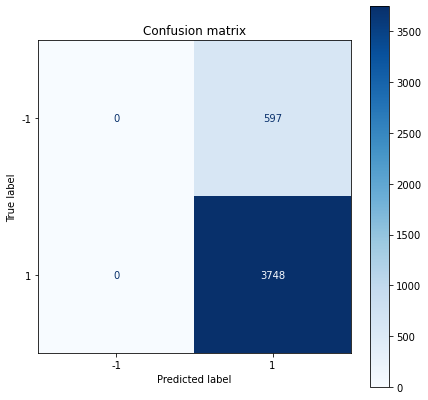

MLP Model 8

5

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

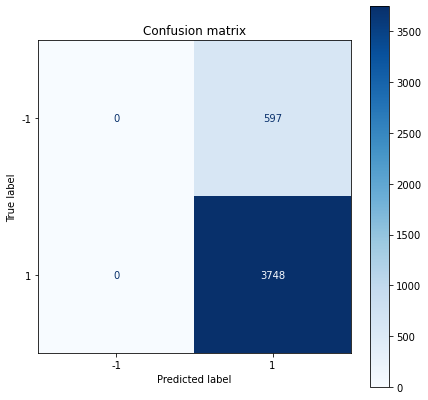

MLP Model 9

5

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

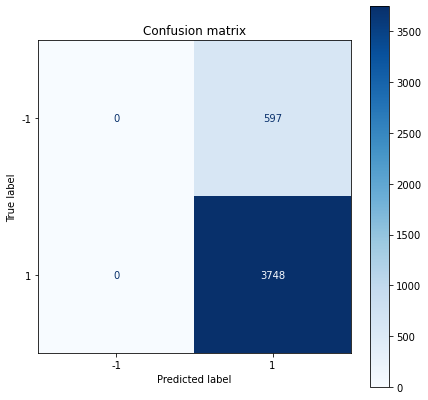

MLP Model 10

5

Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

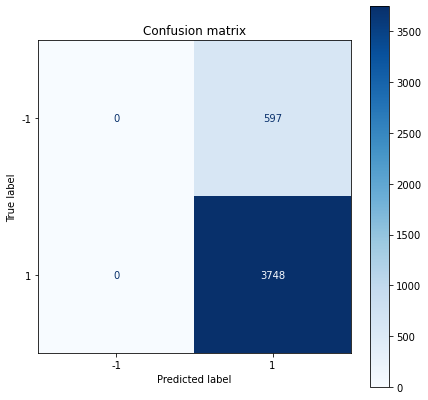

 86%|██████████████████████████████████████▌      | 6/7 [02:55<00:24, 24.15s/it]

----------------------------------------------------------------------------

MLP Model 1

6

Classification Report:

              precision    recall  f1-score   support

          -1       0.31      0.03      0.06       597
           1       0.87      0.99      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.59      0.51      0.49      4345
weighted avg       0.79      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


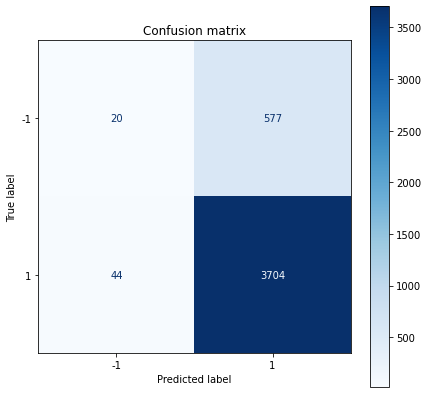

MLP Model 2

6

Classification Report:

              precision    recall  f1-score   support

          -1       0.11      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.49      0.50      0.46      4345
weighted avg       0.76      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


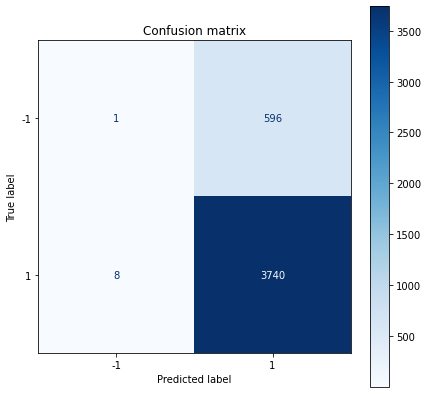

MLP Model 3

6

Classification Report:

              precision    recall  f1-score   support

          -1       0.45      0.03      0.05       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.66      0.51      0.49      4345
weighted avg       0.81      0.86      0.81      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


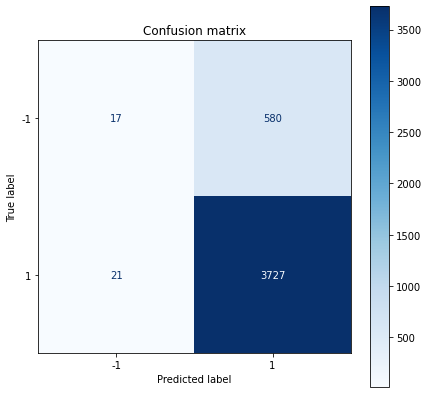

MLP Model 4

6

Classification Report:

              precision    recall  f1-score   support

          -1       0.12      0.00      0.01       597
           1       0.86      1.00      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.49      0.50      0.47      4345
weighted avg       0.76      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


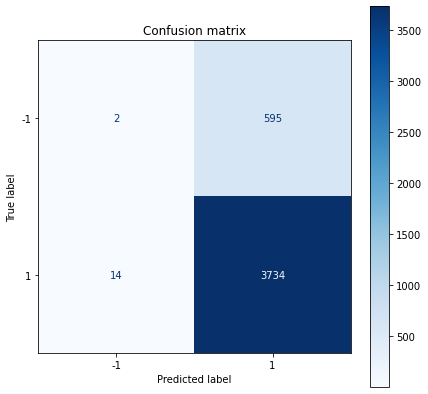

MLP Model 5

6

Classification Report:

              precision    recall  f1-score   support

          -1       0.11      0.00      0.01       597
           1       0.86      1.00      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.48      0.50      0.47      4345
weighted avg       0.76      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


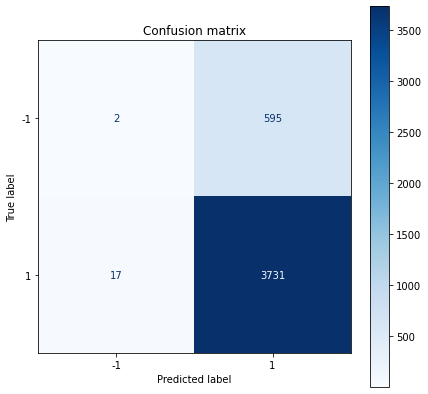

MLP Model 6

6

Classification Report:

              precision    recall  f1-score   support

          -1       0.14      0.00      0.01       597
           1       0.86      1.00      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.50      0.50      0.47      4345
weighted avg       0.76      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


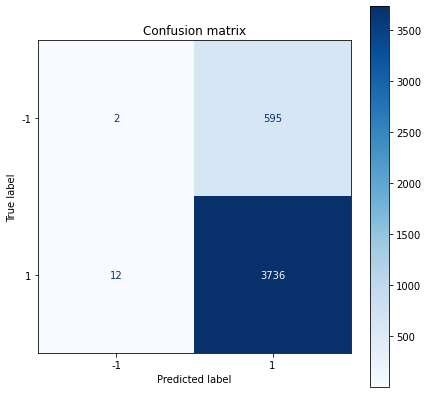

MLP Model 7

6

Classification Report:

              precision    recall  f1-score   support

          -1       0.71      0.09      0.15       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.79      0.54      0.54      4345
weighted avg       0.85      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


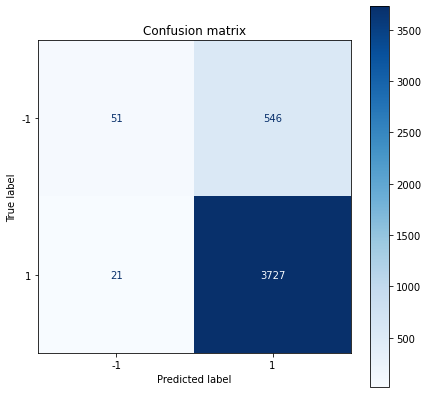

MLP Model 8

6

Classification Report:

              precision    recall  f1-score   support

          -1       0.14      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.50      0.50      0.46      4345
weighted avg       0.76      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


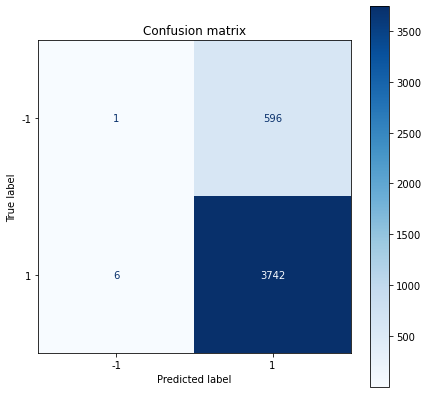

MLP Model 9

6

Classification Report:

              precision    recall  f1-score   support

          -1       0.76      0.14      0.24       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.82      0.57      0.59      4345
weighted avg       0.86      0.88      0.84      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


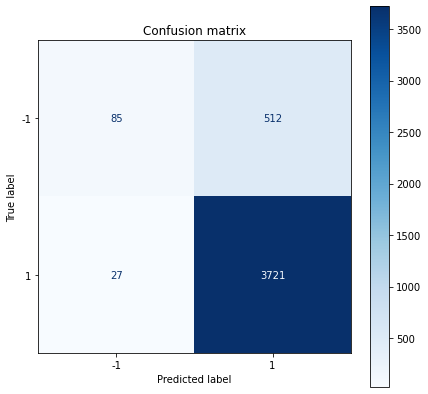

MLP Model 10

6

Classification Report:

              precision    recall  f1-score   support

          -1       0.14      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.50      0.50      0.46      4345
weighted avg       0.76      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


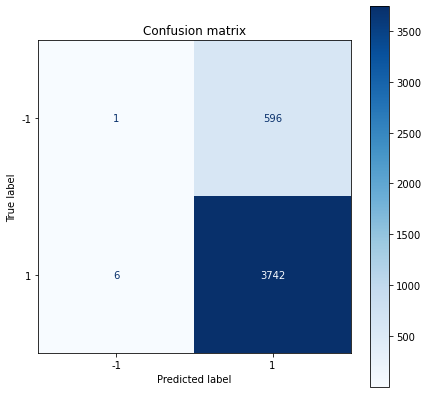

100%|█████████████████████████████████████████████| 7/7 [03:22<00:00, 28.98s/it]

----------------------------------------------------------------------------



In [129]:
acc_lst_mlp5 = []

for j in tqdm(range(0, 7)):
    acc_mlp5 = []
    for i in range(1,11):
        print("MLP Model {}\n".format(i))
        mlp5 = MLPClassifier(
                            activation='tanh',
                            batch_size= 64,
                            n_iter_no_change = 5,
                            learning_rate_init= 0.2,
                            momentum= 0.9,
                            solver= 'sgd',             
                            hidden_layer_sizes=(15,15))
        print(j)
        mlp_model5, mlp_pred5, mlp_acc5 = build_model(mlp5, pred_train_list[j], pred_test_list[j], y_train, y_test)
        acc_mlp5.append(mlp_acc5*100)
    acc_lst_mlp5.append(acc_mlp5)
    print("----------------------------------------------------------------------------\n")

In [130]:
som_acc = []
for i in range(0, 7):
    som_acc.append(round(np.mean(acc_lst_mlp5[i]), 3))
max_acc_som = np.max(som_acc)
print(som_acc)
print("\nMax Acc: ",max_acc_som)
index_max_som = som_acc.index(max_acc_som)
print(index_max_som)

[88.37, 87.49, 86.45, 87.47, 86.3, 86.3, 86.27]

Max Acc:  88.37
0


### Plot MLP models accuray based on different number of K

In [131]:
mlp2_baseline_lst = [mlp_wrapper_baseline]* 7

<function matplotlib.pyplot.show(close=None, block=None)>

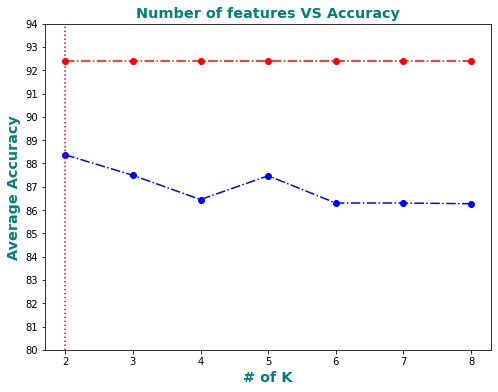

In [132]:
plt.figure(figsize=(8,6))

y_range = range(80,95)

axis_11 = plt.plot(k, som_acc, color='blue', marker='o', 
                   linestyle='dashdot')

axis_22 = plt.plot(k, mlp2_baseline_lst, color='red', marker='o',
                   linestyle='dashdot', label = 'Baseline')

plt.xlabel('# of K', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.ylabel('Average Accuracy', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.title('Number of features VS Accuracy', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.yticks(y_range)
plt.axvline(x= k[index_max_som], linestyle=':', color= 'red')
plt.show

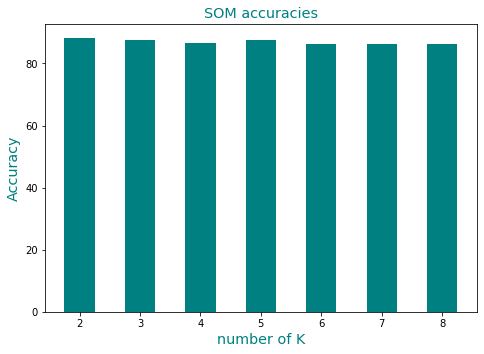

In [133]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = [2, 3, 4, 5, 6, 7, 8]
ax.bar(models,som_acc, color= 'teal', width= 0.5)
ax.yaxis
plt.xlabel('number of K', fontsize = 'x-large',  color = 'teal')
plt.ylabel('Accuracy', fontsize = 'x-large',color = 'teal' )
plt.title('SOM accuracies', fontsize = 'x-large', color = 'teal')
plt.show()

### Plot best MLP model from previous steps with baseline 

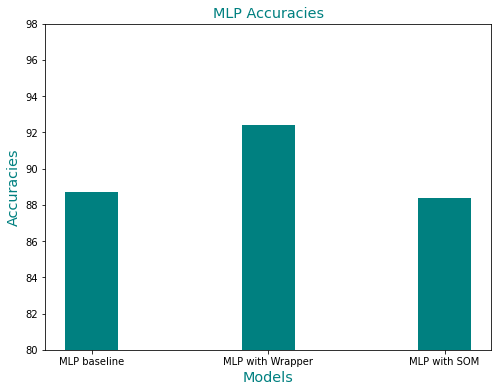

In [134]:
width =0.3 
plt.subplots(figsize=(8, 6))
plt.bar(['MLP baseline', 'MLP with Wrapper', 'MLP with SOM'],
        [avg_acc, mlp_wrapper_baseline, max_acc_som],
        width= width,
        color ='teal')
plt.title('MLP Accuracies', fontsize = 'x-large', color = 'teal')
plt.ylabel('Accuracies', fontsize = 'x-large', color = 'teal')
plt.xlabel('Models', fontsize = 'x-large', color = 'teal')
plt.yticks(np.arange(80, 100, 2))
plt.ylim(ymin = 80)
plt.show()

# 4

MLP Model 1 with 3 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.50      0.52      0.51       597
           1       0.92      0.92      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.71      0.72      0.71      4345
weighted avg       0.86      0.86      0.86      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


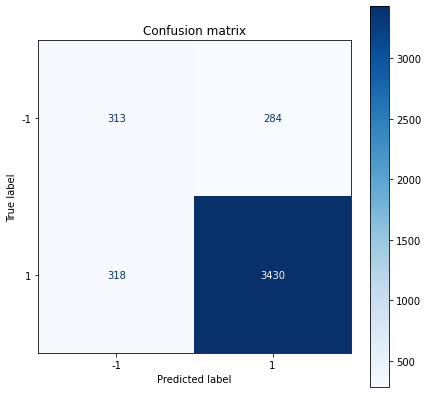

MLP Model 2 with 3 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.78      0.56      0.65       597
           1       0.93      0.97      0.95      3748

    accuracy                           0.92      4345
   macro avg       0.85      0.77      0.80      4345
weighted avg       0.91      0.92      0.91      4345

---------------------------------------------

Accuracy: 0.92


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


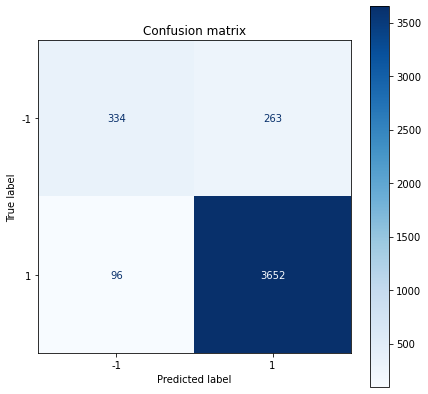

MLP Model 3 with 3 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.48      0.29      0.36       597
           1       0.89      0.95      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.69      0.62      0.64      4345
weighted avg       0.84      0.86      0.84      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


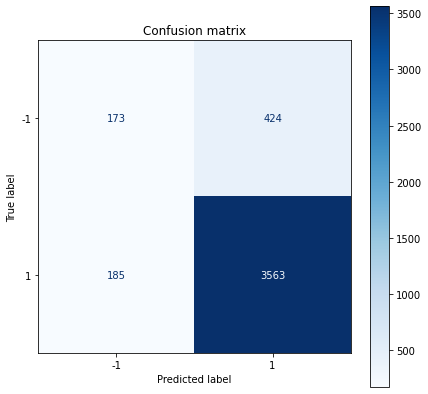

MLP Model 4 with 3 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.39      0.13      0.20       597
           1       0.88      0.97      0.92      3748

    accuracy                           0.85      4345
   macro avg       0.63      0.55      0.56      4345
weighted avg       0.81      0.85      0.82      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


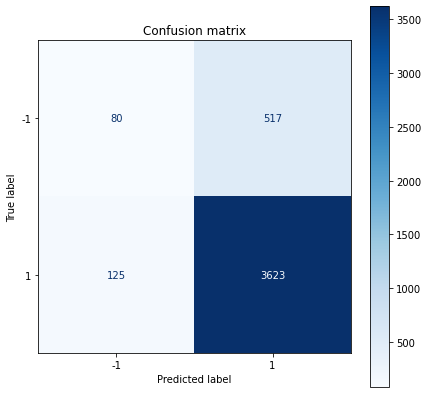

MLP Model 5 with 3 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.57      0.60       597
           1       0.93      0.95      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.78      0.76      0.77      4345
weighted avg       0.89      0.90      0.89      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


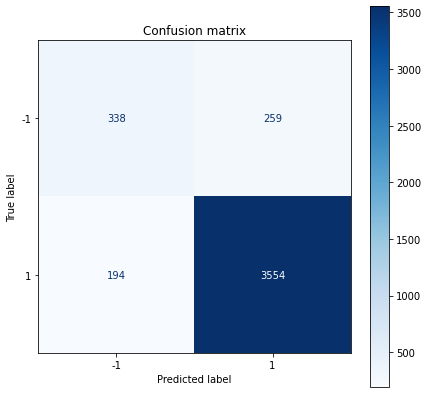

MLP Model 6 with 3 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.73      0.12      0.20       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.80      0.56      0.57      4345
weighted avg       0.86      0.87      0.83      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


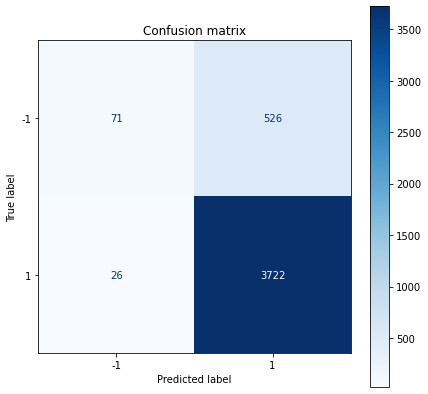

MLP Model 7 with 3 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.73      0.31      0.43       597
           1       0.90      0.98      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.81      0.65      0.69      4345
weighted avg       0.88      0.89      0.87      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


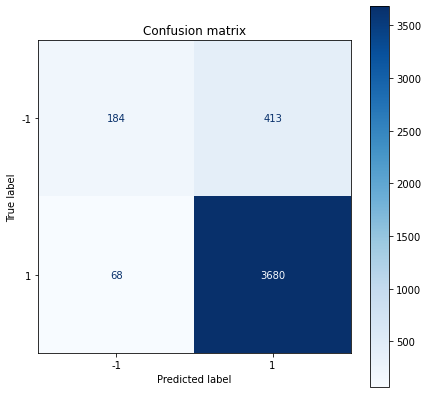

MLP Model 8 with 3 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.65      0.25      0.36       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.77      0.61      0.65      4345
weighted avg       0.86      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


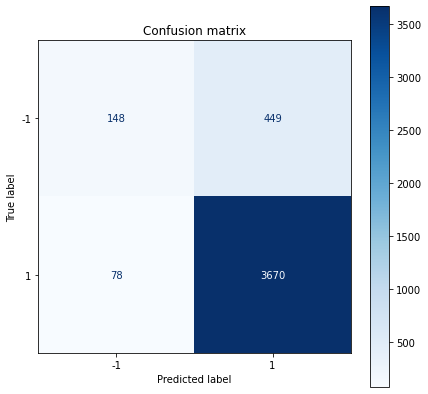

MLP Model 9 with 3 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.71      0.15      0.25       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.80      0.57      0.59      4345
weighted avg       0.86      0.88      0.84      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


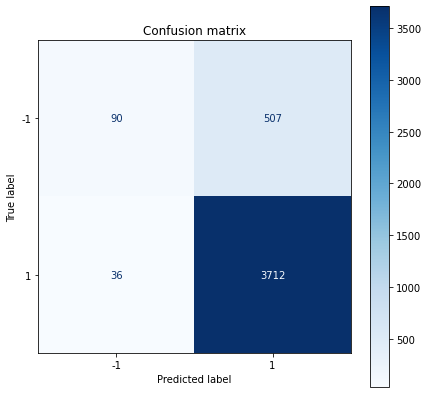

MLP Model 10 with 3 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.53      0.08      0.14       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.70      0.53      0.53      4345
weighted avg       0.82      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


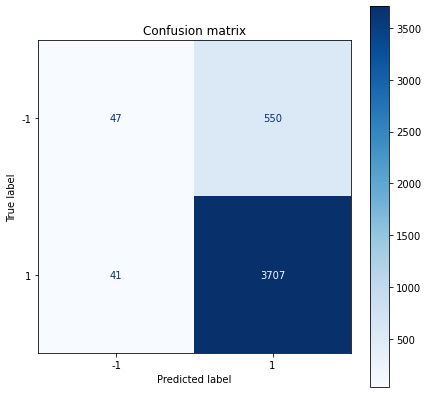

MLP Model 11 with 3 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.55      0.32      0.40       597
           1       0.90      0.96      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.72      0.64      0.66      4345
weighted avg       0.85      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


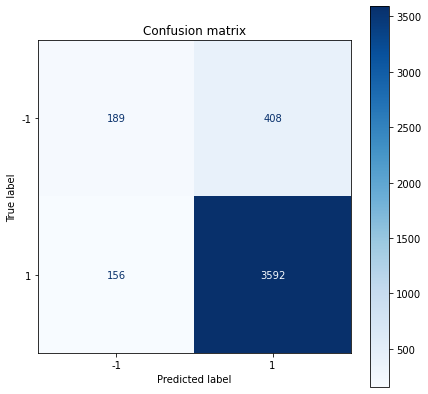

----------------------------------------------------------------------------

MLP Model 1 with 4 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       1.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.93      0.50      0.46      4345
weighted avg       0.88      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


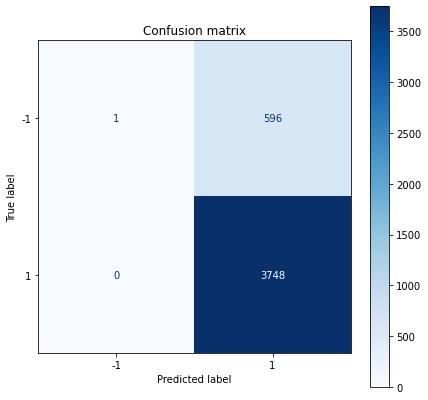

MLP Model 2 with 4 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

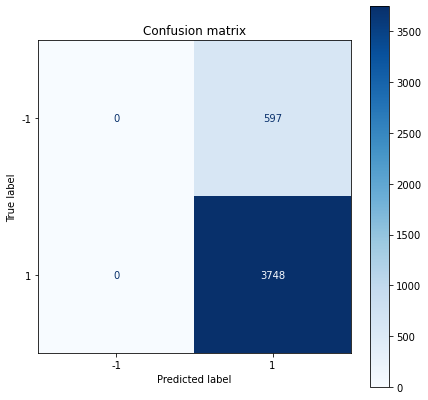

MLP Model 3 with 4 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

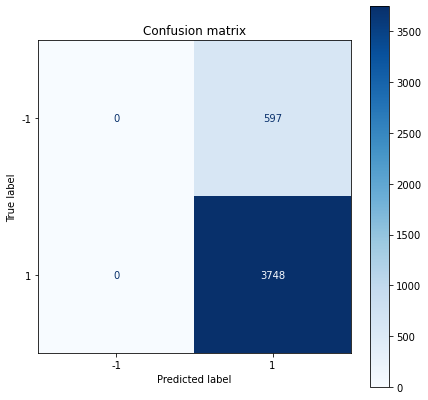

MLP Model 4 with 4 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.53      0.22      0.31       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.71      0.59      0.62      4345
weighted avg       0.84      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


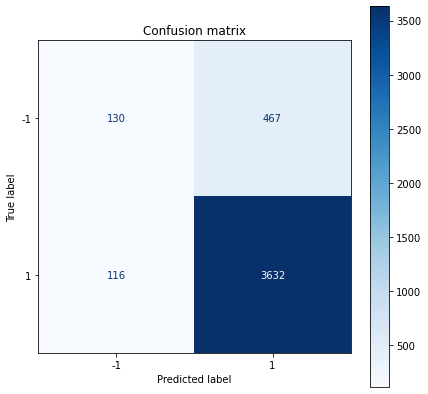

MLP Model 5 with 4 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.04      0.08       597
           1       0.87      1.00      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.75      0.52      0.50      4345
weighted avg       0.84      0.87      0.81      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


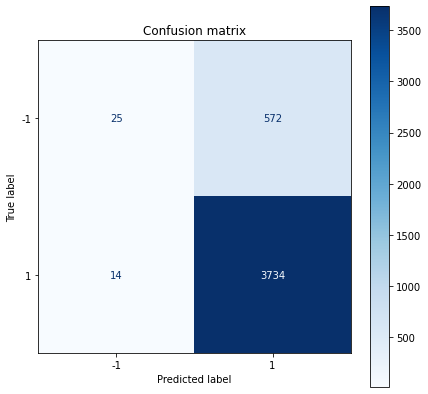

MLP Model 6 with 4 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

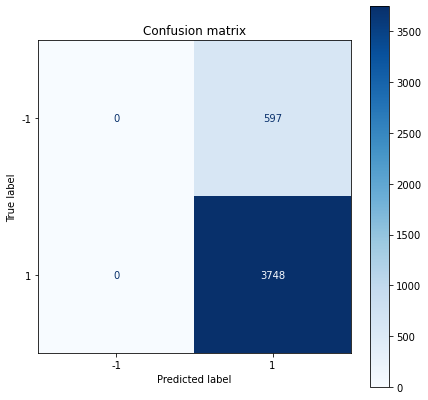

MLP Model 7 with 4 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.38      0.28      0.32       597
           1       0.89      0.93      0.91      3748

    accuracy                           0.84      4345
   macro avg       0.63      0.60      0.61      4345
weighted avg       0.82      0.84      0.83      4345

---------------------------------------------

Accuracy: 0.84


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


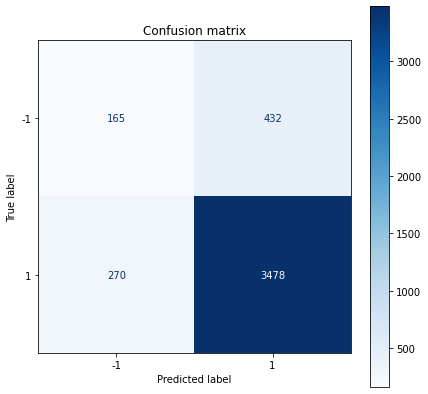

MLP Model 8 with 4 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.57      0.20      0.30       597
           1       0.88      0.98      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.73      0.59      0.61      4345
weighted avg       0.84      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


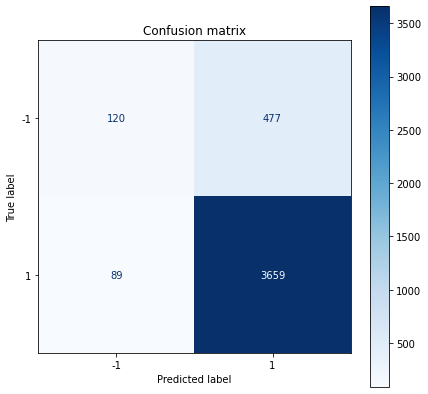

MLP Model 9 with 4 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.61      0.22      0.33       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.75      0.60      0.63      4345
weighted avg       0.85      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


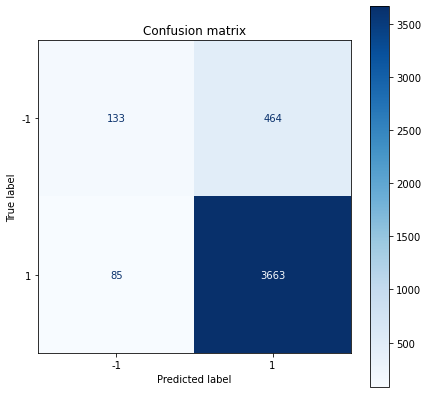

MLP Model 10 with 4 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.42      0.03      0.06       597
           1       0.87      0.99      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.64      0.51      0.49      4345
weighted avg       0.80      0.86      0.81      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


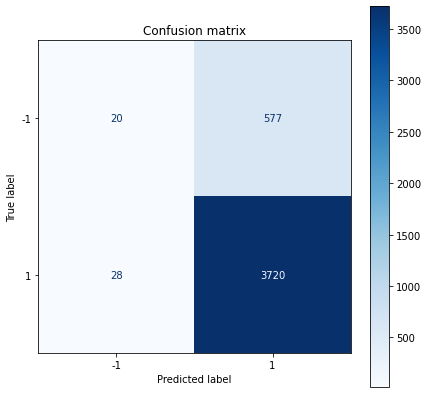

MLP Model 11 with 4 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

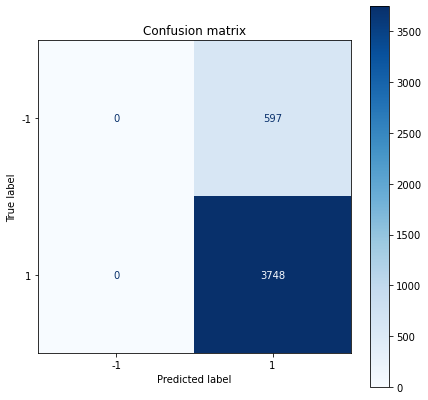

----------------------------------------------------------------------------

MLP Model 1 with 5 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.18      0.28       597
           1       0.88      0.98      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.76      0.58      0.61      4345
weighted avg       0.85      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


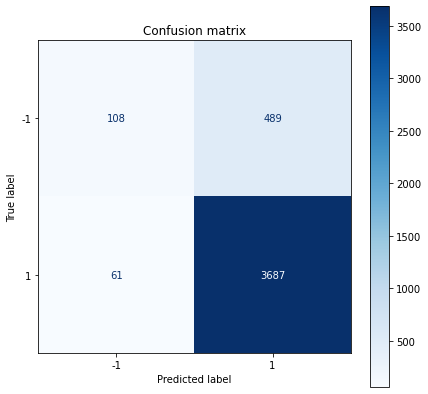

MLP Model 2 with 5 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

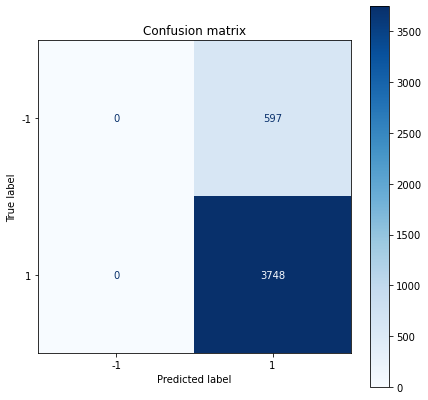

MLP Model 3 with 5 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

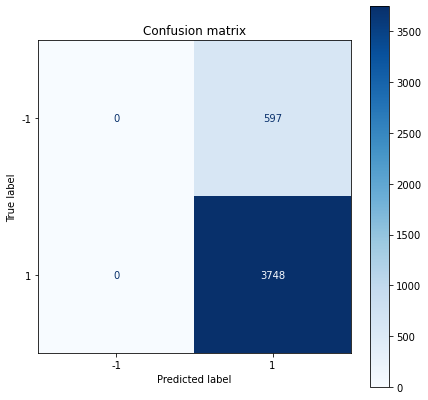

MLP Model 4 with 5 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.52      0.23      0.32       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.70      0.60      0.62      4345
weighted avg       0.84      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


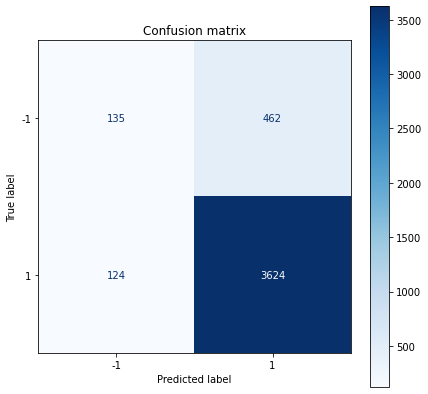

MLP Model 5 with 5 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.56      0.11      0.18       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.71      0.55      0.55      4345
weighted avg       0.83      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


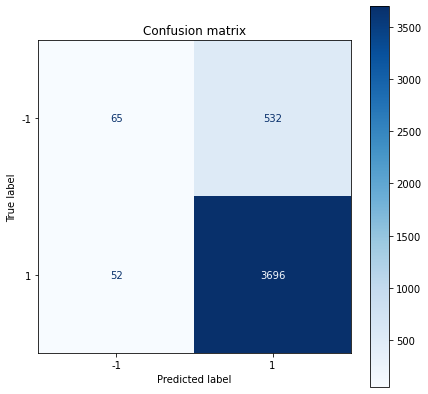

MLP Model 6 with 5 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.43      0.11      0.18       597
           1       0.87      0.98      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.65      0.55      0.55      4345
weighted avg       0.81      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


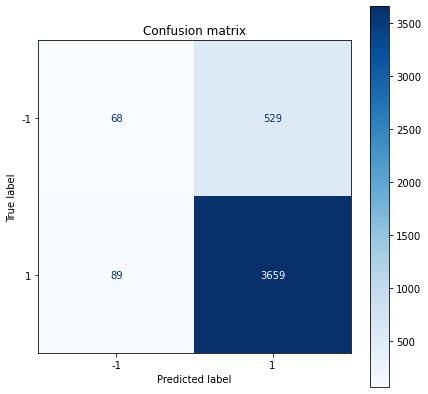

MLP Model 7 with 5 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.48      0.26      0.34       597
           1       0.89      0.96      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.69      0.61      0.63      4345
weighted avg       0.83      0.86      0.84      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


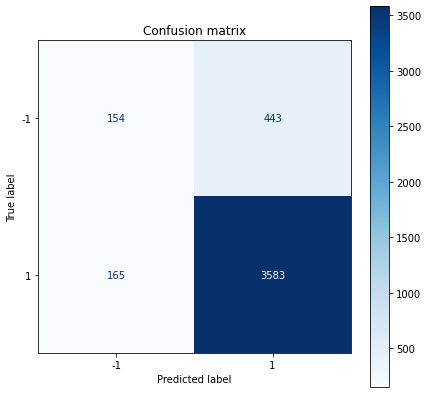

MLP Model 8 with 5 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

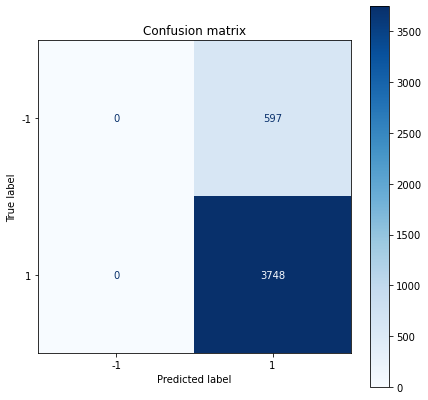

MLP Model 9 with 5 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.48      0.08      0.13       597
           1       0.87      0.99      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.68      0.53      0.53      4345
weighted avg       0.82      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


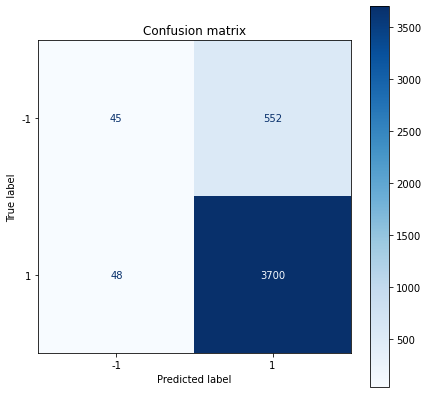

MLP Model 10 with 5 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

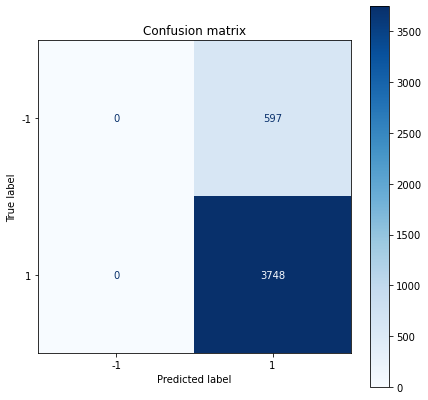

MLP Model 11 with 5 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

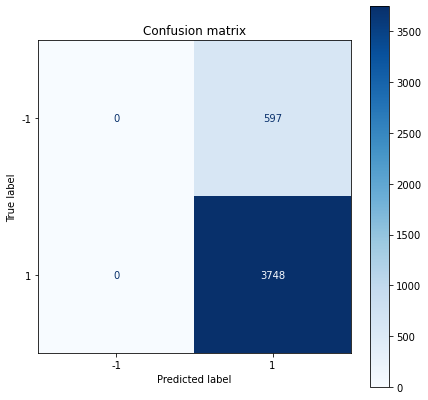

----------------------------------------------------------------------------

MLP Model 1 with 6 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

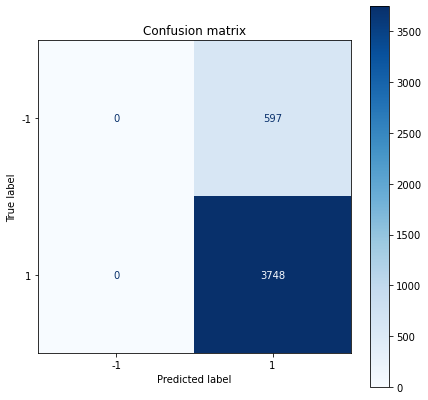

MLP Model 2 with 6 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

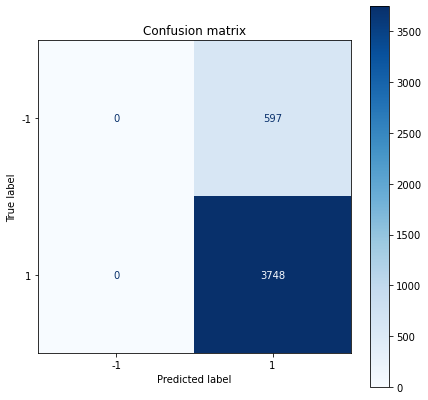

MLP Model 3 with 6 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

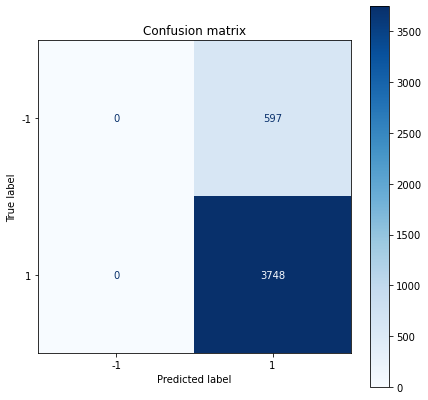

MLP Model 4 with 6 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.47      0.06      0.10       597
           1       0.87      0.99      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.67      0.52      0.51      4345
weighted avg       0.81      0.86      0.81      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


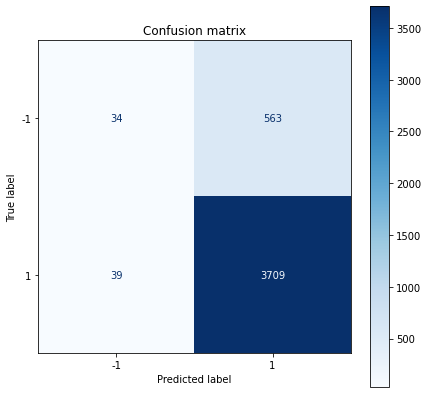

MLP Model 5 with 6 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

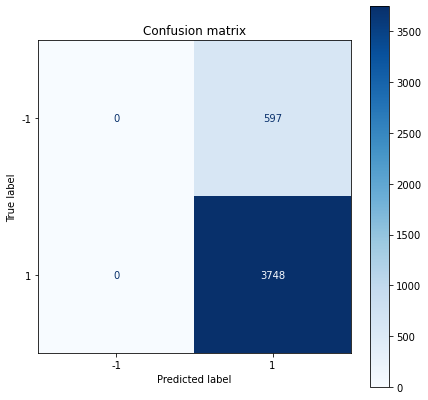

MLP Model 6 with 6 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

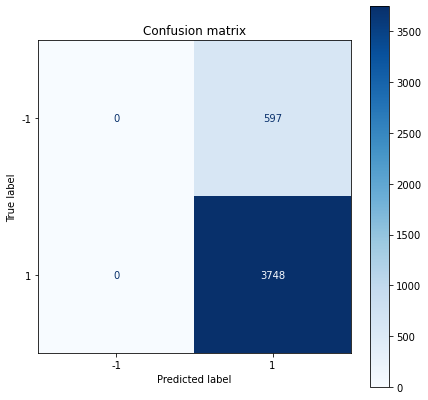

MLP Model 7 with 6 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

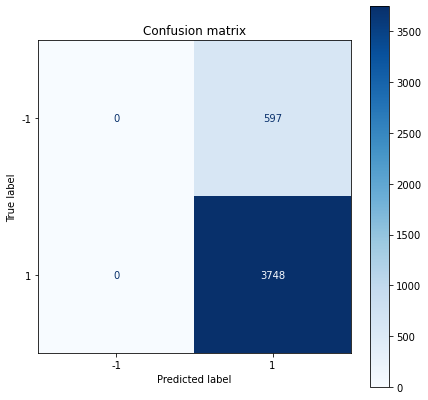

MLP Model 8 with 6 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.50      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.68      0.50      0.46      4345
weighted avg       0.81      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


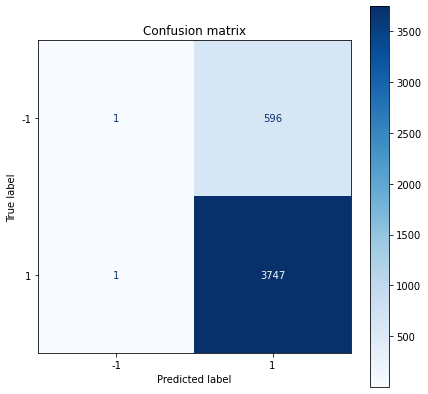

MLP Model 9 with 6 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

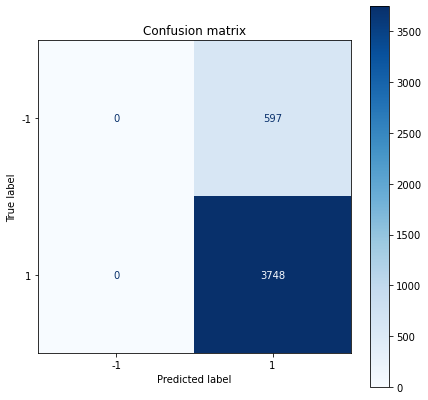

MLP Model 10 with 6 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

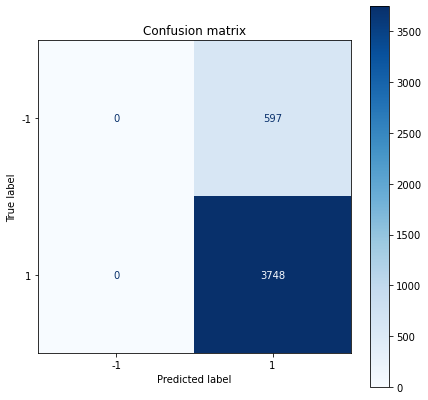

MLP Model 11 with 6 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

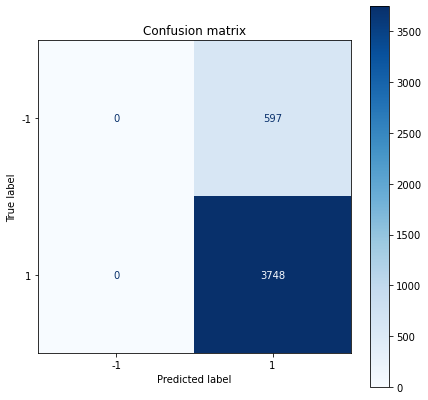

----------------------------------------------------------------------------

MLP Model 1 with 7 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.57      0.09      0.16       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.72      0.54      0.54      4345
weighted avg       0.83      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


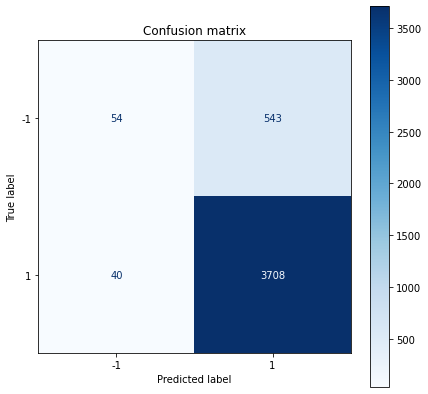

MLP Model 2 with 7 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

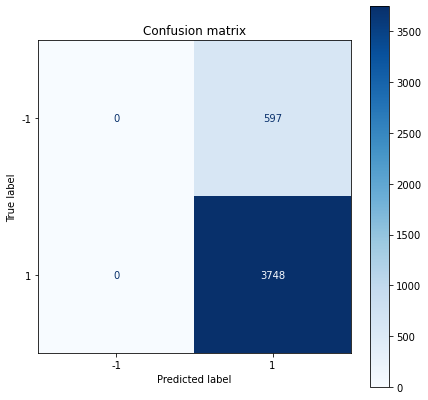

MLP Model 3 with 7 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

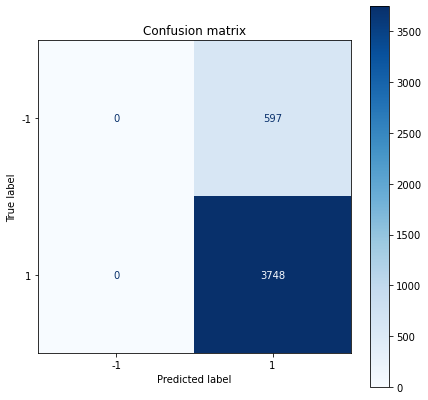

MLP Model 4 with 7 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.52      0.02      0.04       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.69      0.51      0.48      4345
weighted avg       0.82      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


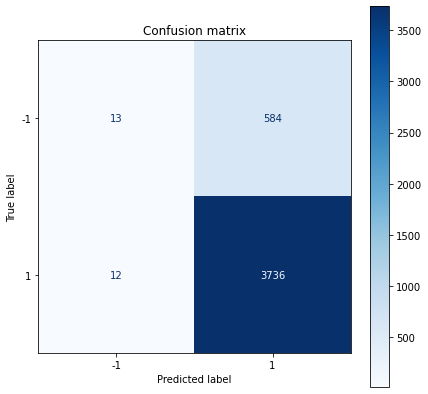

MLP Model 5 with 7 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

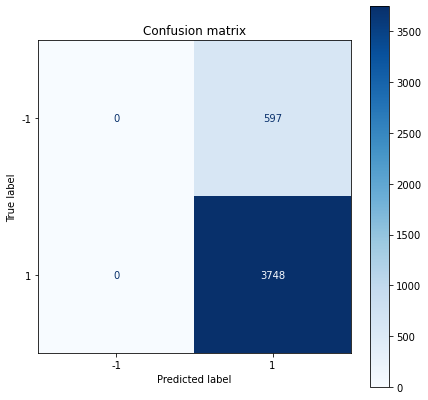

MLP Model 6 with 7 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.52      0.28      0.37       597
           1       0.89      0.96      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.70      0.62      0.65      4345
weighted avg       0.84      0.86      0.85      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


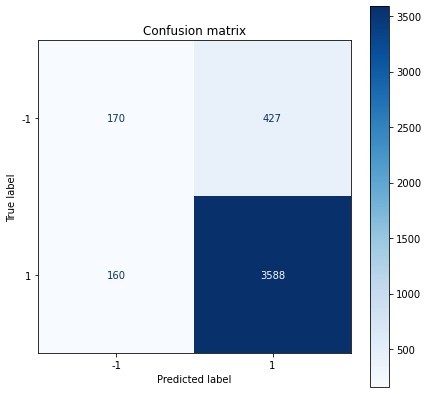

MLP Model 7 with 7 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

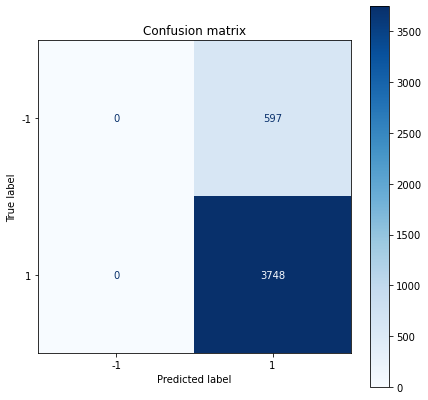

MLP Model 8 with 7 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.58      0.23      0.33       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.73      0.60      0.63      4345
weighted avg       0.85      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


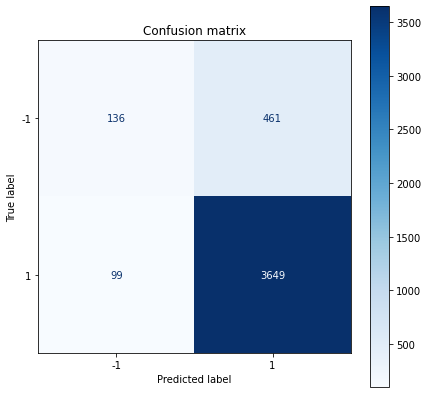

MLP Model 9 with 7 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.55      0.27      0.37       597
           1       0.89      0.96      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.72      0.62      0.65      4345
weighted avg       0.85      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


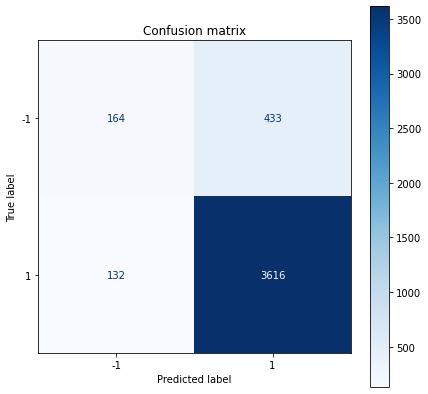

MLP Model 10 with 7 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

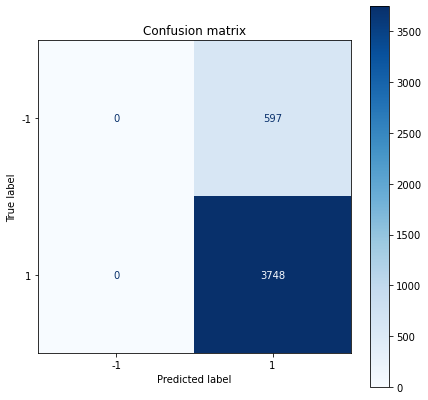

MLP Model 11 with 7 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

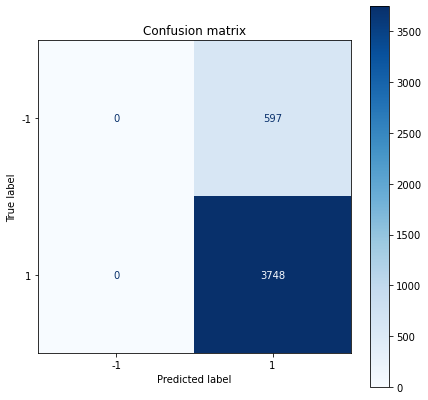

----------------------------------------------------------------------------

MLP Model 1 with 8 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

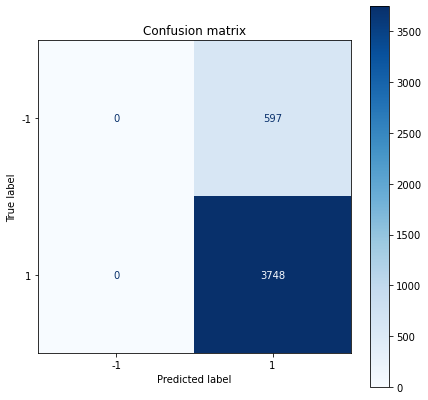

MLP Model 2 with 8 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.75      0.01      0.01       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.81      0.50      0.47      4345
weighted avg       0.85      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


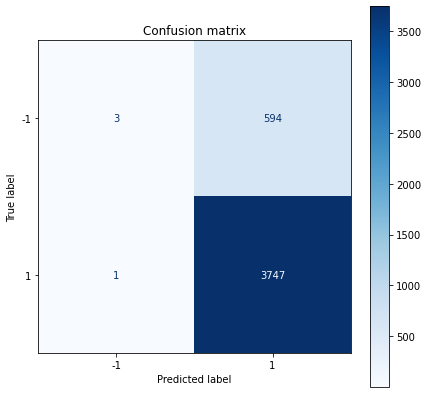

MLP Model 3 with 8 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

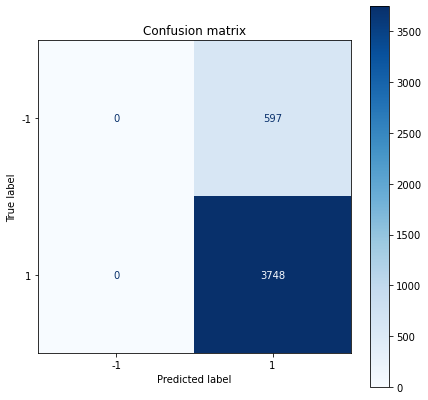

MLP Model 4 with 8 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

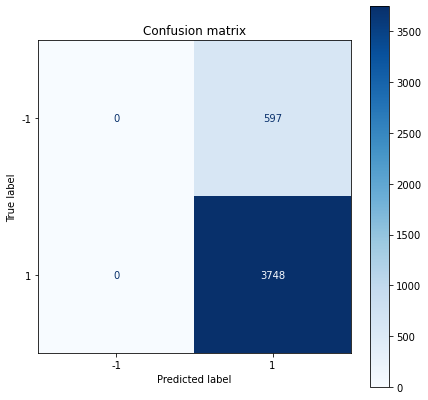

MLP Model 5 with 8 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

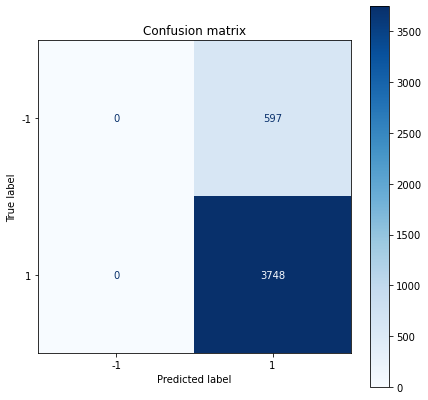

MLP Model 6 with 8 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

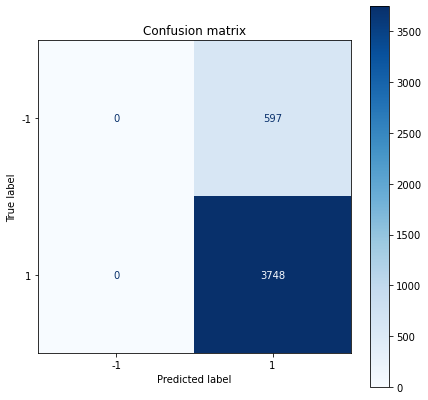

MLP Model 7 with 8 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

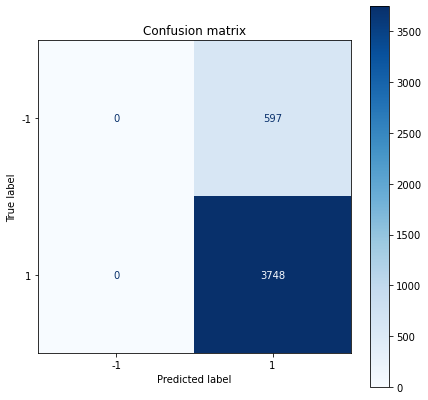

MLP Model 8 with 8 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

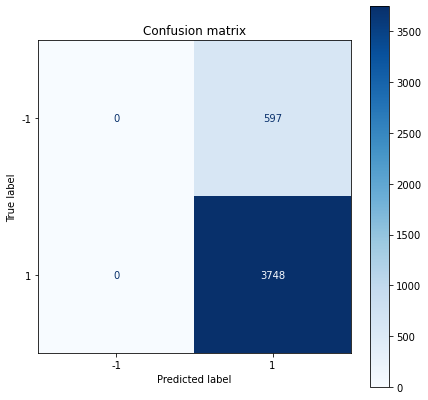

MLP Model 9 with 8 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

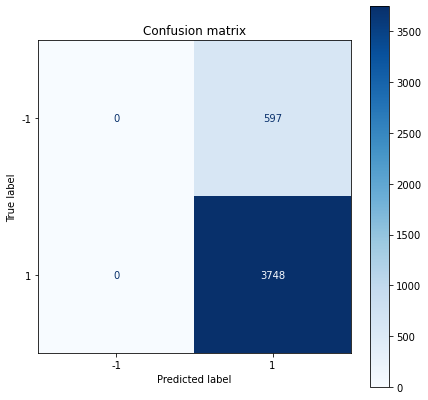

MLP Model 10 with 8 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

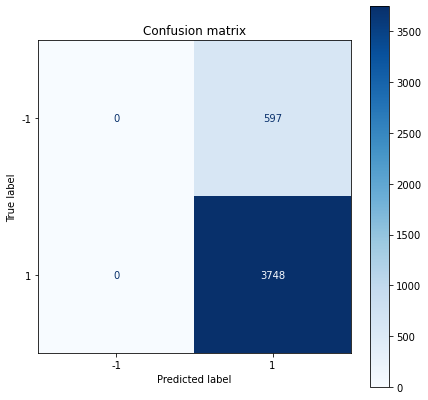

MLP Model 11 with 8 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.60      0.08      0.13       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.74      0.53      0.53      4345
weighted avg       0.83      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


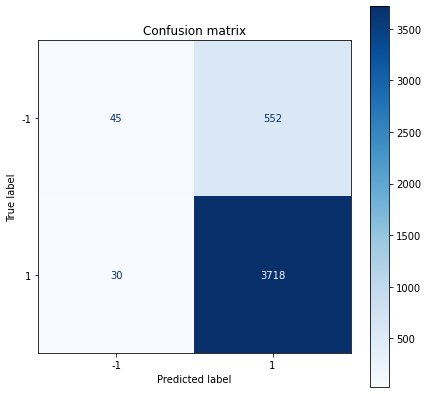

----------------------------------------------------------------------------

MLP Model 1 with 9 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

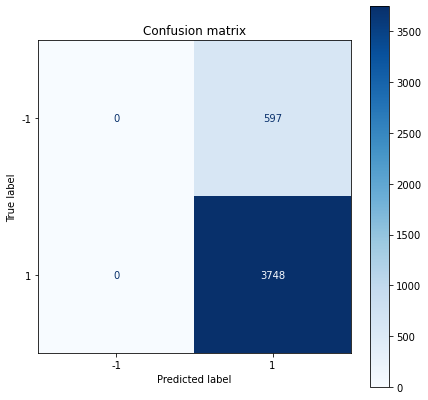

MLP Model 2 with 9 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

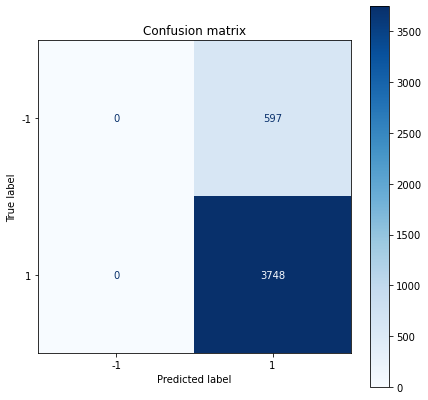

MLP Model 3 with 9 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

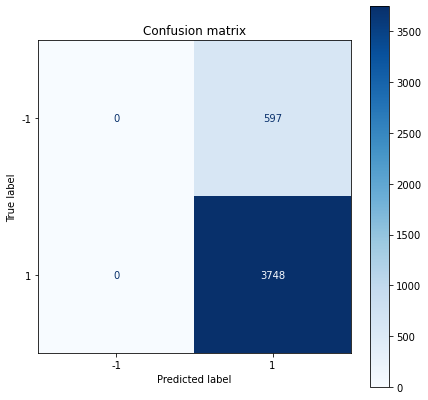

MLP Model 4 with 9 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

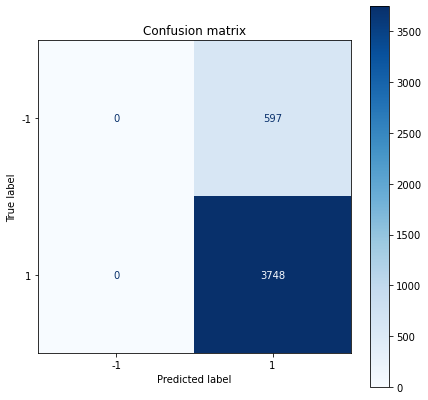

MLP Model 5 with 9 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

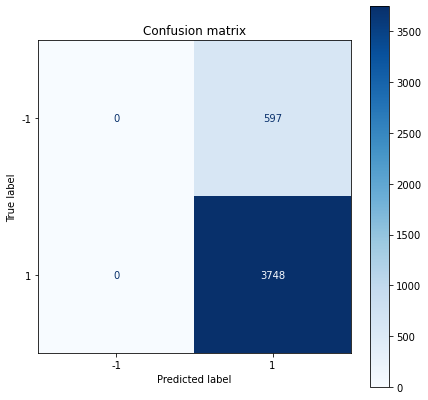

MLP Model 6 with 9 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

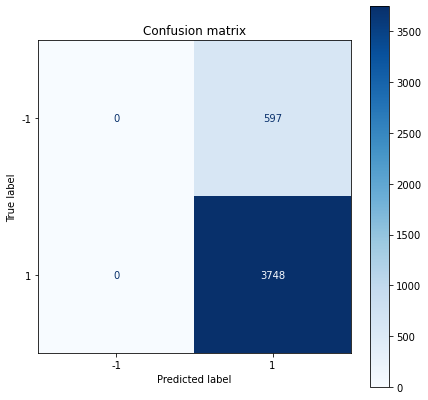

MLP Model 7 with 9 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

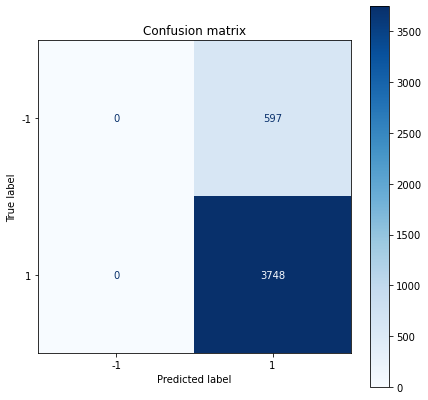

MLP Model 8 with 9 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

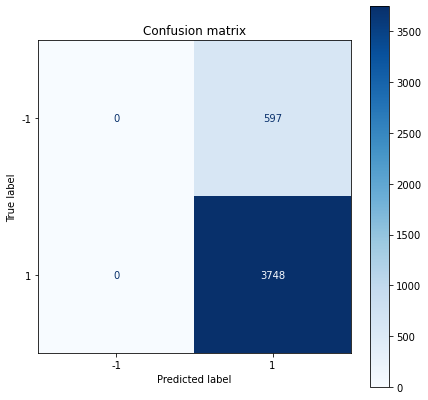

MLP Model 9 with 9 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

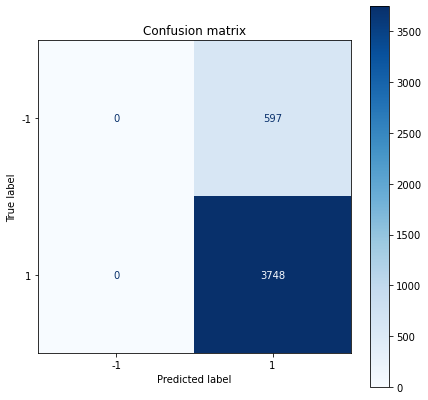

MLP Model 10 with 9 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

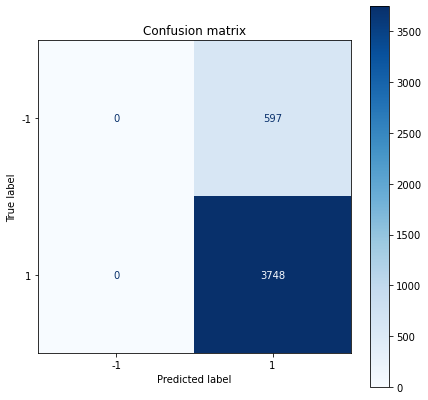

MLP Model 11 with 9 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

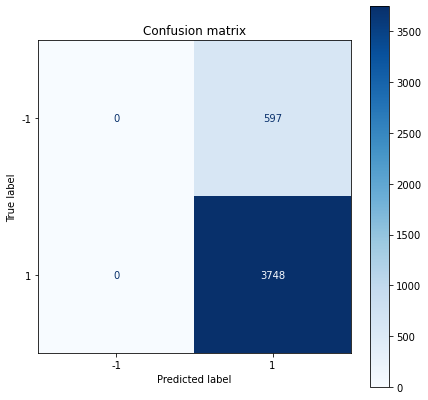

----------------------------------------------------------------------------

MLP Model 1 with 10 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

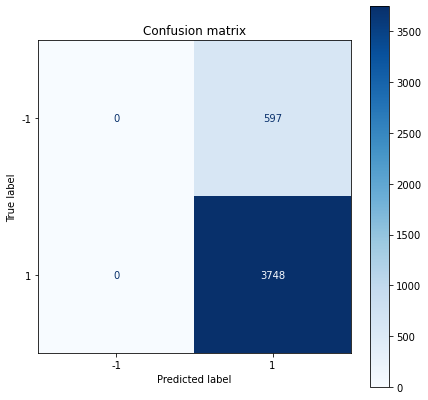

MLP Model 2 with 10 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

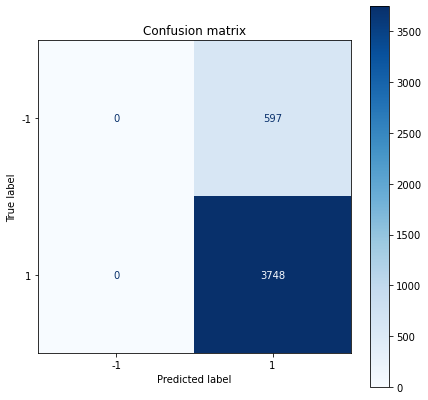

MLP Model 3 with 10 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

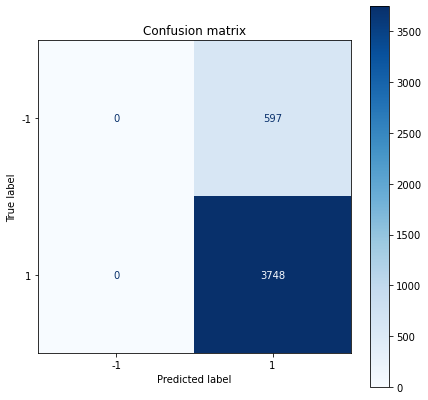

MLP Model 4 with 10 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

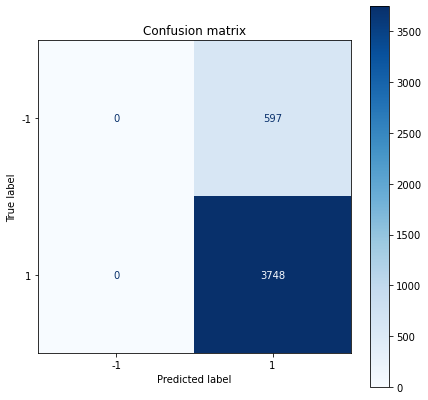

MLP Model 5 with 10 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

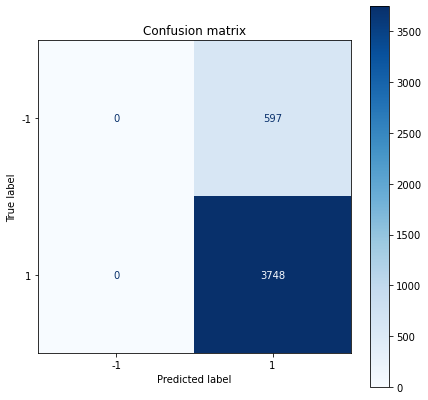

MLP Model 6 with 10 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

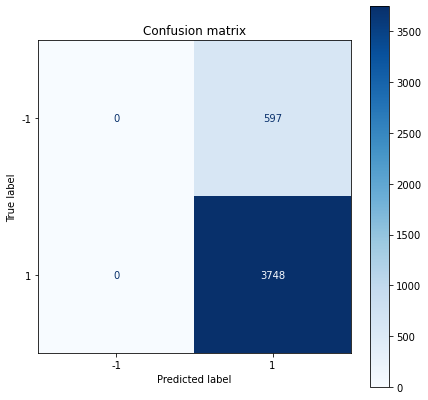

MLP Model 7 with 10 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

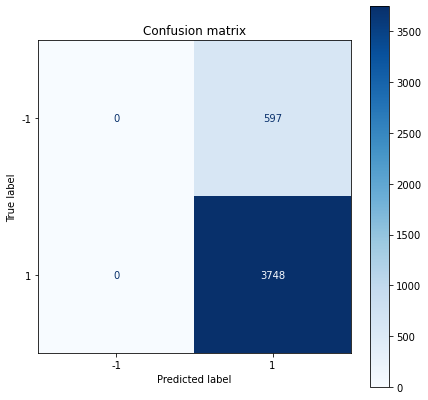

MLP Model 8 with 10 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

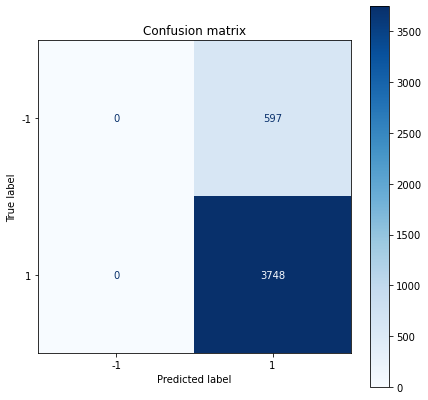

MLP Model 9 with 10 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

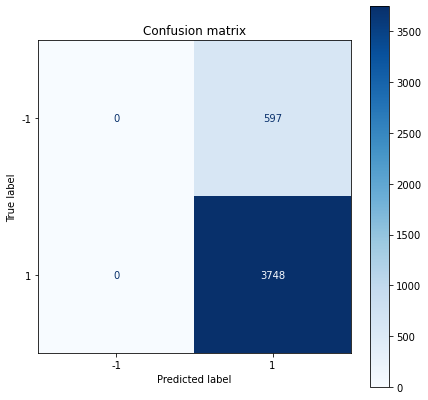

MLP Model 10 with 10 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

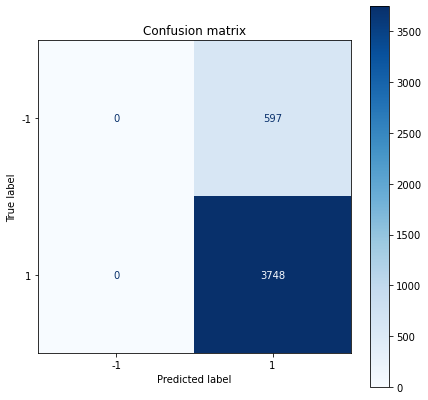

MLP Model 11 with 10 hidden layers 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

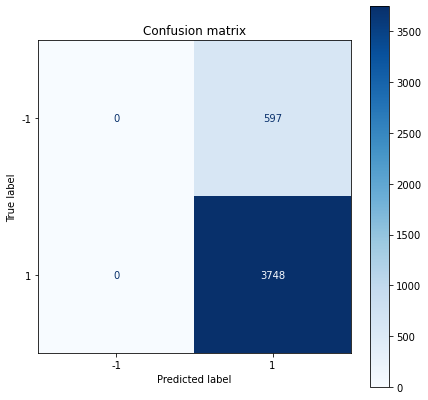

----------------------------------------------------------------------------



In [136]:
acc_list_layers = []
acc_layers_all = []
n_layers = []
for i in range(3, 11):
    n_layers.append(i)
    for j in range(0,11):
        h = [15]*i
        print("MLP Model {} with {} hidden layers \n".format((j+1), i))
        
        mlp6 = MLPClassifier(activation='tanh',
                            batch_size= 64,
                            n_iter_no_change = 5,
                            learning_rate_init= 0.2,
                            momentum= 0.9,
                            solver= 'sgd',   
                            hidden_layer_sizes = tuple(h))
        
        mlp_model6, mlp_pred6, mlp_acc6 = build_model(mlp6,
                                                      pred_train_list[index_max_som],
                                                      pred_test_list[index_max_som],
                                                      y_train,
                                                      y_test)
        acc_list_layers.append(round(mlp_acc6*100,3))      
    acc_layers_all.append(acc_list_layers) 
    acc_list_layers = []
    print("----------------------------------------------------------------------------\n")

In [137]:
avg_lst_layer_final = []
for i in range(len(acc_layers_all)):
    avg_acc_layer_last = np.mean(acc_layers_all[i])
    avg_lst_layer_final.append(avg_acc_layer_last)
    print(round(avg_acc_layer_last, 3))
    max_avg_layer = np.max(avg_lst_layer_final)
print("\nMax Acc: {:.3f}".format(max_avg_layer))
idx_max_layer = avg_lst_layer_final.index(max_avg_layer)
print("\nindex of best combinations of features is: ",idx_max_layer)

87.6
86.264
86.355
86.282
86.482
86.327
86.3
86.3

Max Acc: 87.600

index of best combinations of features is:  0


### Plot Tuned Hidden Layers

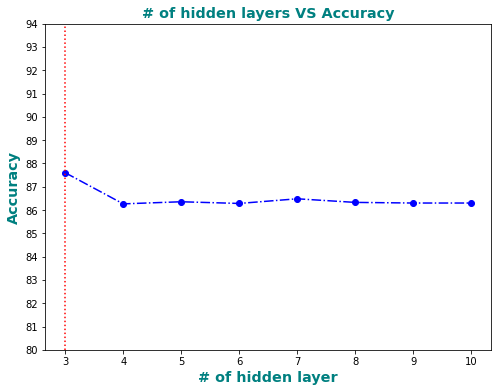

In [139]:
plt.figure(figsize=(8,6))

y_range = range(80,95)

axis_11 = plt.plot(n_layers, avg_lst_layer_final, color='blue', marker='o', 
                   linestyle='dashdot')
plt.xlabel('# of hidden layer', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.ylabel('Accuracy', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.title('# of hidden layers VS Accuracy', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.yticks(y_range)
plt.axvline(x=n_layers[idx_max_layer], linestyle=':', color= 'red')
plt.xticks(n_layers)
plt.show()

### Tune the number of neurons per each layer

  0%|                                                    | 0/21 [00:00<?, ?it/s]

Model 1
MLP Model with 3 hidden layers, each one 10 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.43      0.09      0.14       597
           1       0.87      0.98      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.65      0.53      0.53      4345
weighted avg       0.81      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


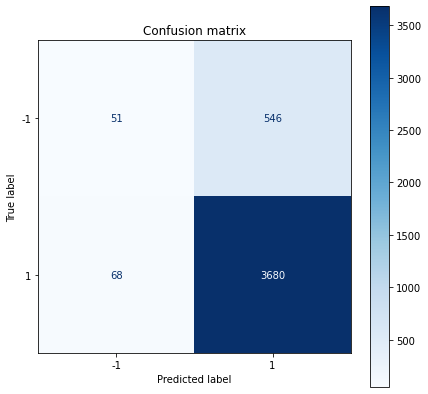

MLP Model with 3 hidden layers, each one 10 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.62      0.13      0.21       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.75      0.56      0.57      4345
weighted avg       0.84      0.87      0.83      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


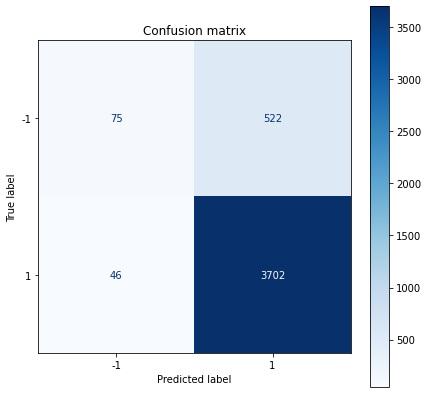

MLP Model with 3 hidden layers, each one 10 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.42      0.03      0.06       597
           1       0.87      0.99      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.64      0.51      0.49      4345
weighted avg       0.80      0.86      0.81      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


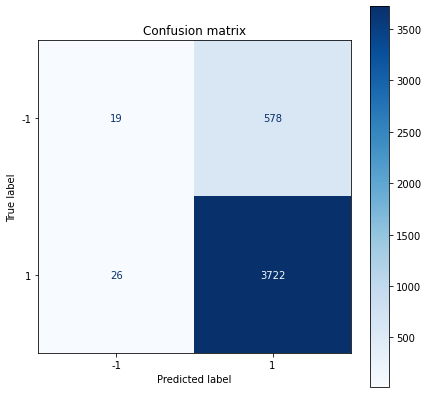

MLP Model with 3 hidden layers, each one 10 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.79      0.12      0.20       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.83      0.56      0.57      4345
weighted avg       0.86      0.87      0.83      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


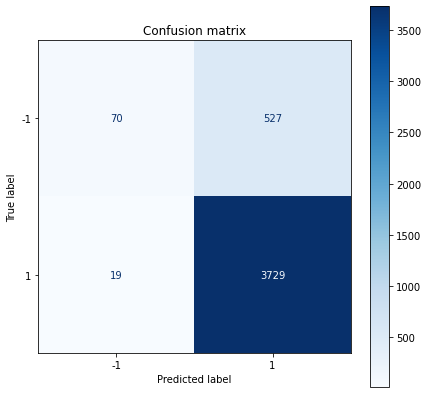

MLP Model with 3 hidden layers, each one 10 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.66      0.23      0.34       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.78      0.60      0.63      4345
weighted avg       0.86      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


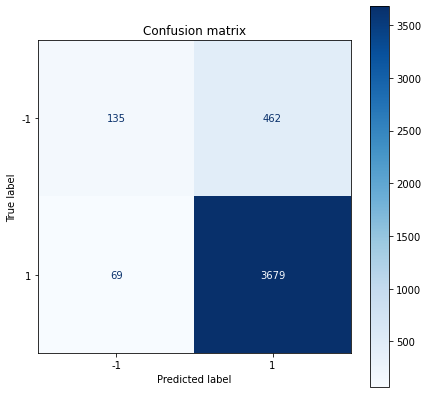

MLP Model with 3 hidden layers, each one 10 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.67      0.17      0.27       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.77      0.58      0.60      4345
weighted avg       0.85      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


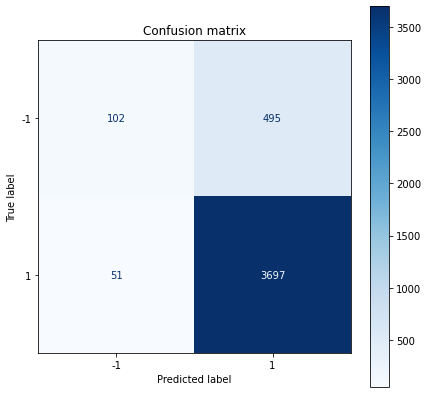

MLP Model with 3 hidden layers, each one 10 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

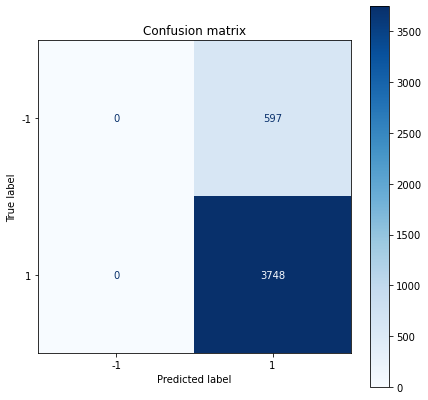

MLP Model with 3 hidden layers, each one 10 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.68      0.21      0.32       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.78      0.60      0.63      4345
weighted avg       0.86      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


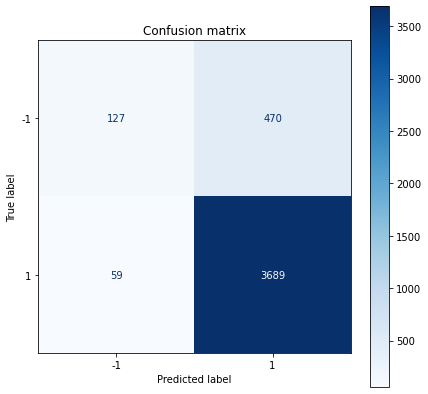

MLP Model with 3 hidden layers, each one 10 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.80      0.01      0.03       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.83      0.51      0.48      4345
weighted avg       0.86      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


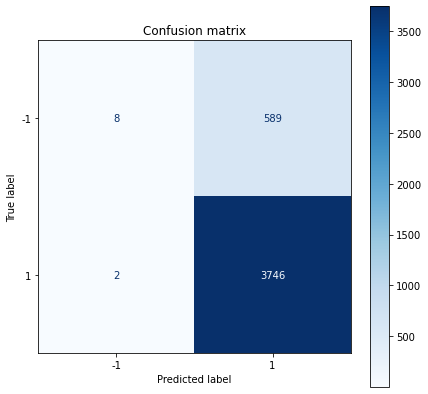

MLP Model with 3 hidden layers, each one 10 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.43      0.35      0.38       597
           1       0.90      0.93      0.91      3748

    accuracy                           0.85      4345
   macro avg       0.66      0.64      0.65      4345
weighted avg       0.83      0.85      0.84      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


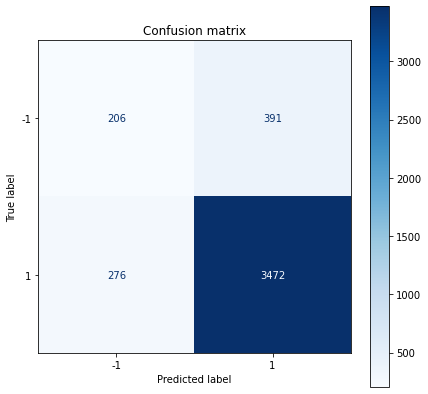

MLP Model with 3 hidden layers, each one 10 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.86      0.15      0.25       597
           1       0.88      1.00      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.87      0.57      0.59      4345
weighted avg       0.88      0.88      0.84      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


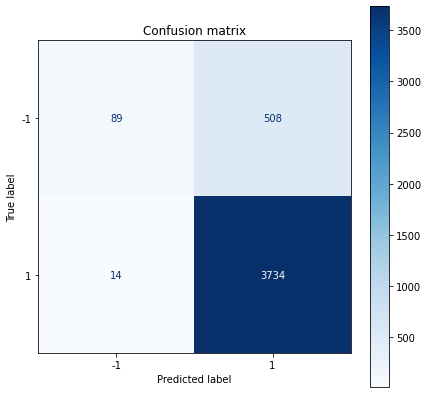

  5%|██                                          | 1/21 [00:31<10:27, 31.37s/it]

----------------------------------------------------------------------------

Model 2
MLP Model with 3 hidden layers, each one 11 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.44      0.22      0.29       597
           1       0.88      0.95      0.92      3748

    accuracy                           0.85      4345
   macro avg       0.66      0.59      0.61      4345
weighted avg       0.82      0.85      0.83      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


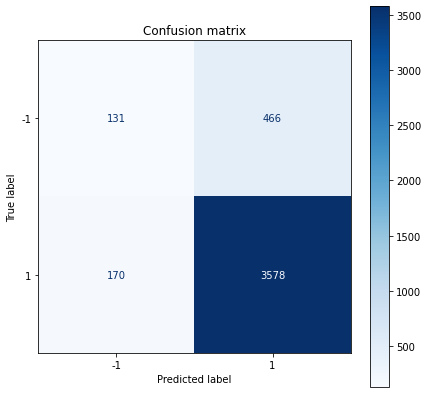

MLP Model with 3 hidden layers, each one 11 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.54      0.23      0.32       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.71      0.60      0.62      4345
weighted avg       0.84      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


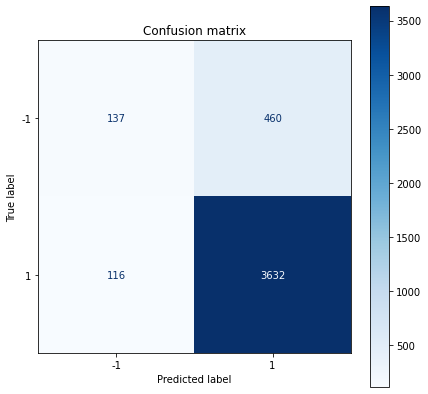

MLP Model with 3 hidden layers, each one 11 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.54      0.09      0.15       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.71      0.54      0.54      4345
weighted avg       0.83      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


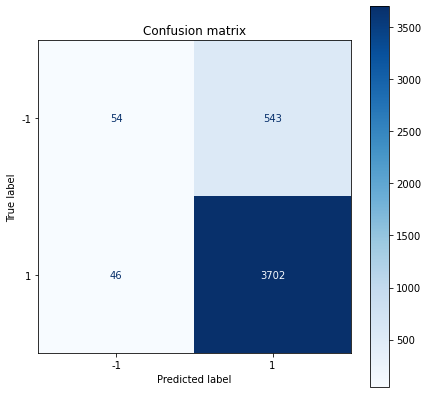

MLP Model with 3 hidden layers, each one 11 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.57      0.30      0.39       597
           1       0.90      0.96      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.73      0.63      0.66      4345
weighted avg       0.85      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


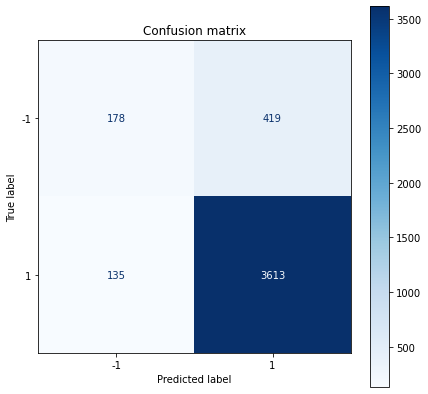

MLP Model with 3 hidden layers, each one 11 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.50      0.28      0.35       597
           1       0.89      0.96      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.69      0.62      0.64      4345
weighted avg       0.84      0.86      0.84      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


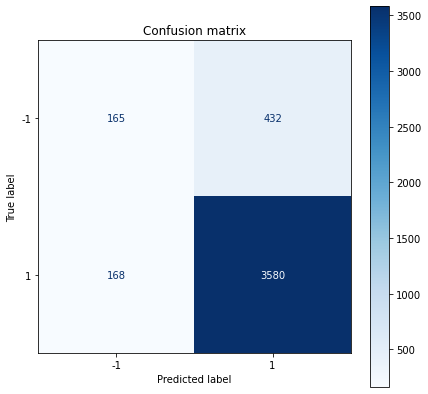

MLP Model with 3 hidden layers, each one 11 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.60      0.29      0.39       597
           1       0.90      0.97      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.75      0.63      0.66      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


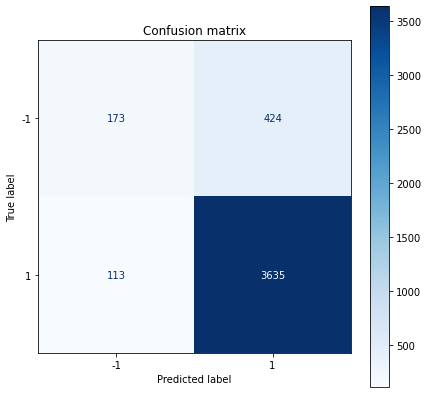

MLP Model with 3 hidden layers, each one 11 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.66      0.27      0.38       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.78      0.62      0.66      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


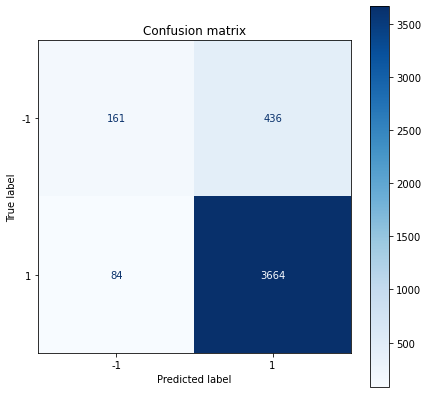

MLP Model with 3 hidden layers, each one 11 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.42      0.24      0.30       597
           1       0.89      0.95      0.92      3748

    accuracy                           0.85      4345
   macro avg       0.65      0.59      0.61      4345
weighted avg       0.82      0.85      0.83      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


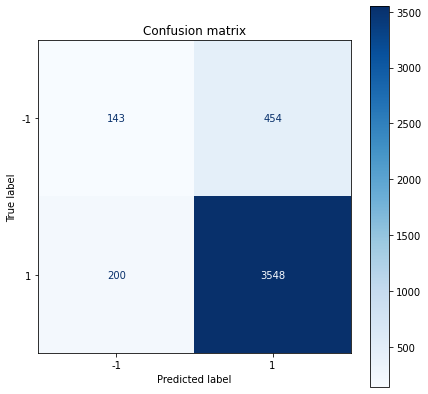

MLP Model with 3 hidden layers, each one 11 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.49      0.12      0.19       597
           1       0.87      0.98      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.68      0.55      0.56      4345
weighted avg       0.82      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


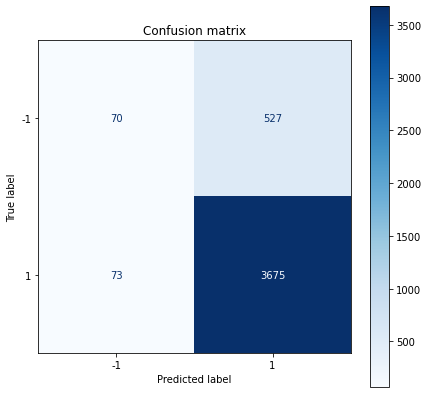

MLP Model with 3 hidden layers, each one 11 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

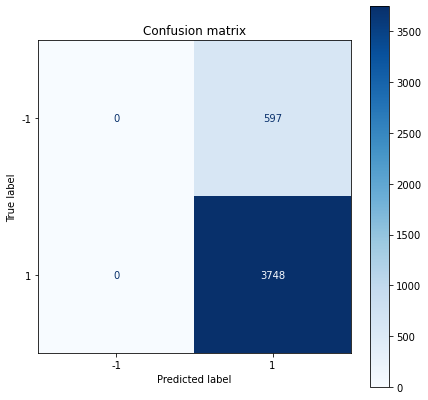

MLP Model with 3 hidden layers, each one 11 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.49      0.49      0.49       597
           1       0.92      0.92      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.71      0.71      0.71      4345
weighted avg       0.86      0.86      0.86      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


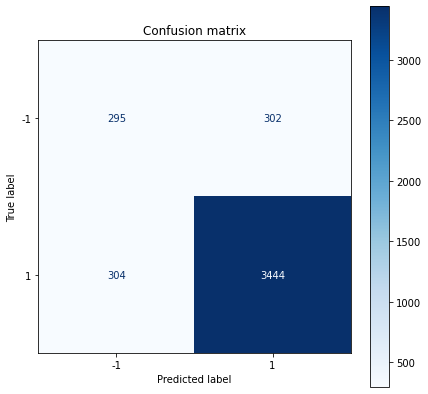

 10%|████▏                                       | 2/21 [01:08<10:58, 34.63s/it]

----------------------------------------------------------------------------

Model 3
MLP Model with 3 hidden layers, each one 12 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.71      0.10      0.17       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.79      0.55      0.55      4345
weighted avg       0.85      0.87      0.83      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


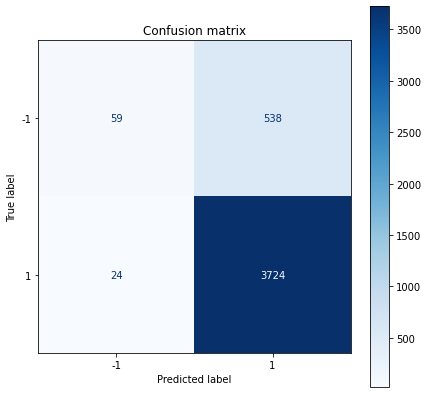

MLP Model with 3 hidden layers, each one 12 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.65      0.32      0.43       597
           1       0.90      0.97      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.77      0.65      0.68      4345
weighted avg       0.87      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


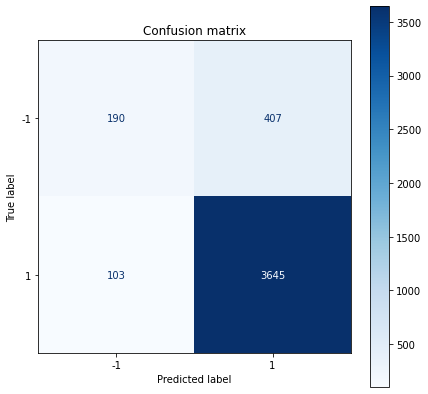

MLP Model with 3 hidden layers, each one 12 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.61      0.43      0.51       597
           1       0.91      0.96      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.76      0.69      0.72      4345
weighted avg       0.87      0.88      0.88      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


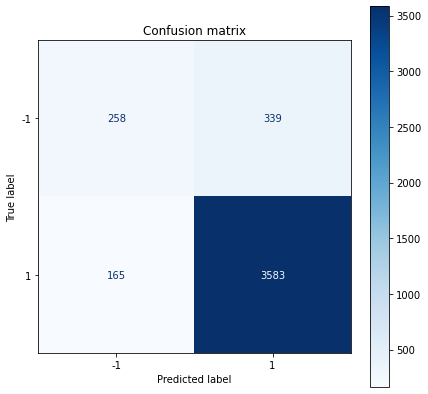

MLP Model with 3 hidden layers, each one 12 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

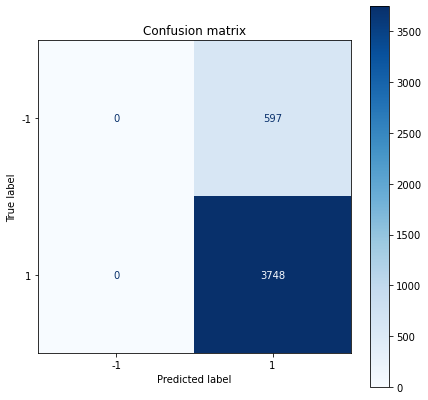

MLP Model with 3 hidden layers, each one 12 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.54      0.14      0.22       597
           1       0.88      0.98      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.71      0.56      0.57      4345
weighted avg       0.83      0.87      0.83      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


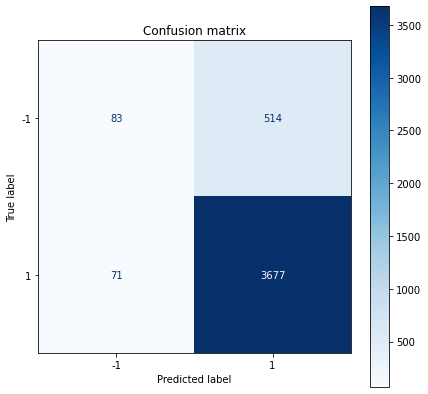

MLP Model with 3 hidden layers, each one 12 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.67      0.47      0.55       597
           1       0.92      0.96      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.79      0.72      0.75      4345
weighted avg       0.88      0.89      0.89      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


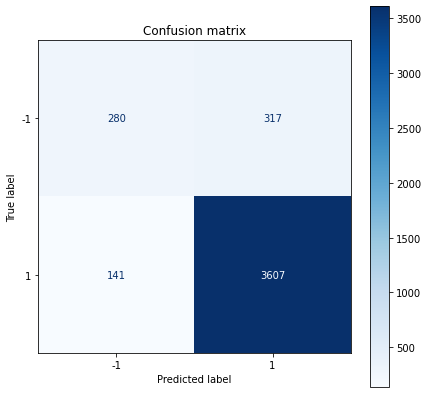

MLP Model with 3 hidden layers, each one 12 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.31      0.07      0.11       597
           1       0.87      0.98      0.92      3748

    accuracy                           0.85      4345
   macro avg       0.59      0.52      0.52      4345
weighted avg       0.79      0.85      0.81      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


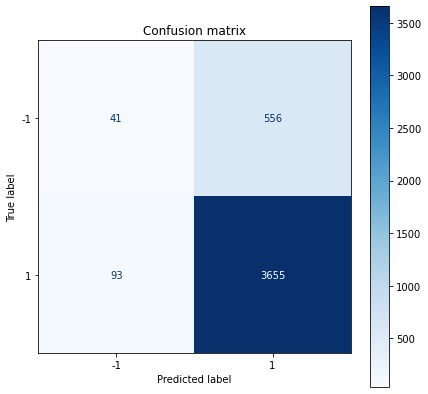

MLP Model with 3 hidden layers, each one 12 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.78      0.05      0.10       597
           1       0.87      1.00      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.82      0.53      0.51      4345
weighted avg       0.86      0.87      0.81      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


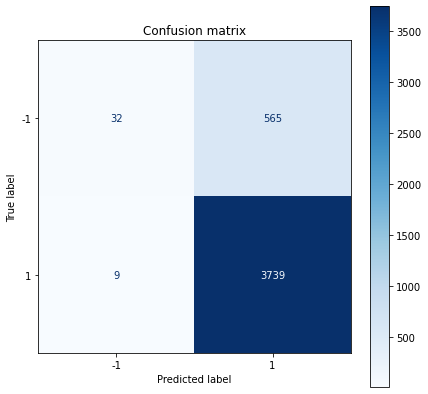

MLP Model with 3 hidden layers, each one 12 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.59      0.36      0.45       597
           1       0.90      0.96      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.75      0.66      0.69      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


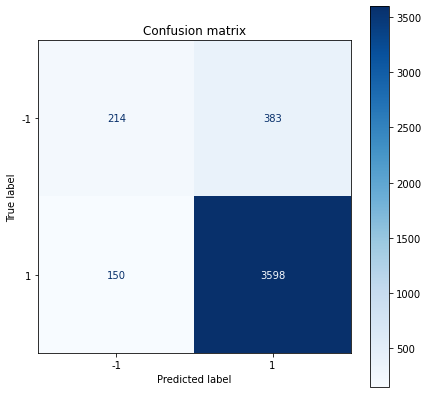

MLP Model with 3 hidden layers, each one 12 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.55      0.57      0.56       597
           1       0.93      0.93      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.74      0.75      0.75      4345
weighted avg       0.88      0.88      0.88      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


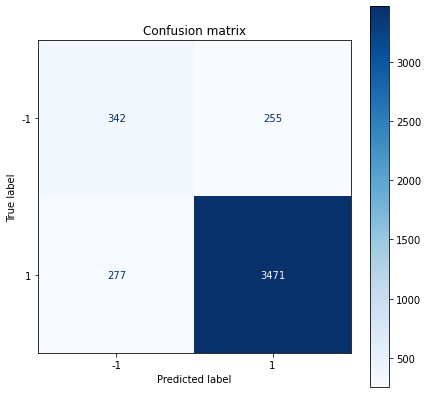

MLP Model with 3 hidden layers, each one 12 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.23      0.34       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.77      0.61      0.64      4345
weighted avg       0.86      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


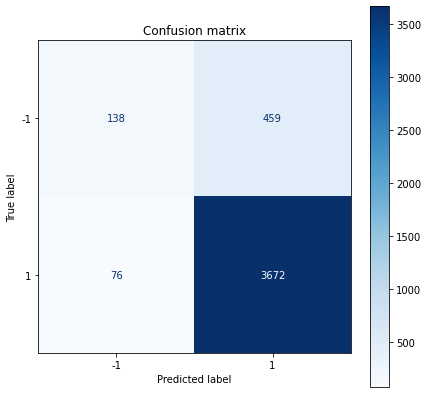

 14%|██████▎                                     | 3/21 [01:40<10:02, 33.48s/it]

----------------------------------------------------------------------------

Model 4
MLP Model with 3 hidden layers, each one 13 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.72      0.44      0.55       597
           1       0.92      0.97      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.82      0.71      0.75      4345
weighted avg       0.89      0.90      0.89      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


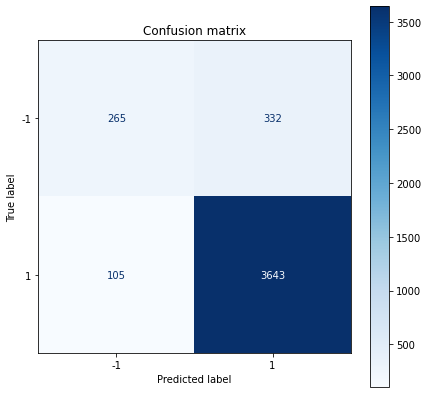

MLP Model with 3 hidden layers, each one 13 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.53      0.37      0.43       597
           1       0.90      0.95      0.92      3748

    accuracy                           0.87      4345
   macro avg       0.71      0.66      0.68      4345
weighted avg       0.85      0.87      0.86      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


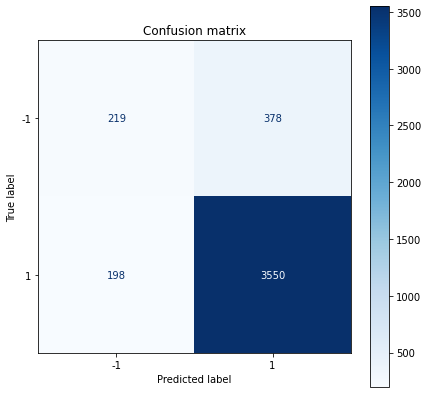

MLP Model with 3 hidden layers, each one 13 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.90      0.08      0.14       597
           1       0.87      1.00      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.89      0.54      0.54      4345
weighted avg       0.88      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


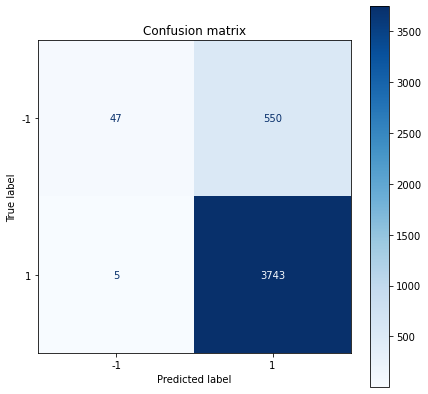

MLP Model with 3 hidden layers, each one 13 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.45      0.10      0.16       597
           1       0.87      0.98      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.66      0.54      0.54      4345
weighted avg       0.81      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


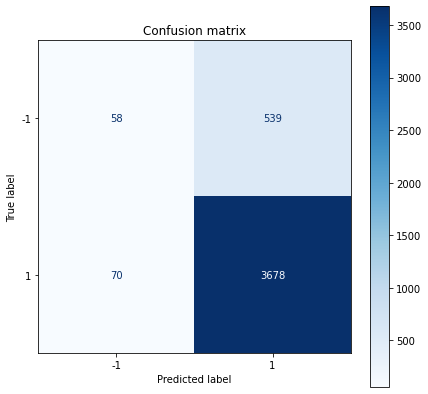

MLP Model with 3 hidden layers, each one 13 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.22      0.33       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.77      0.60      0.63      4345
weighted avg       0.85      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


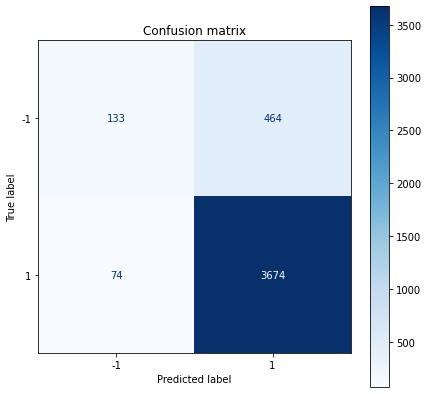

MLP Model with 3 hidden layers, each one 13 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.62      0.49      0.55       597
           1       0.92      0.95      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.77      0.72      0.74      4345
weighted avg       0.88      0.89      0.88      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


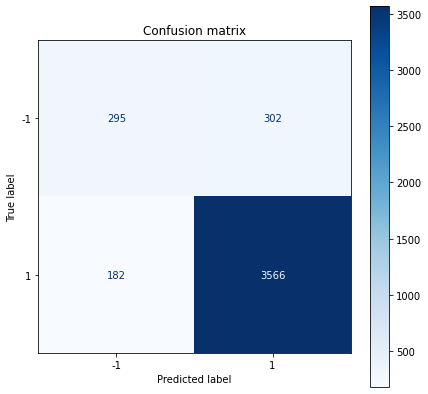

MLP Model with 3 hidden layers, each one 13 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.60      0.78      0.68       597
           1       0.96      0.92      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.78      0.85      0.81      4345
weighted avg       0.91      0.90      0.90      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


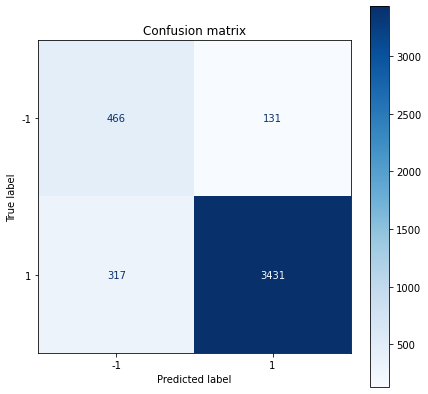

MLP Model with 3 hidden layers, each one 13 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.33      0.16      0.21       597
           1       0.88      0.95      0.91      3748

    accuracy                           0.84      4345
   macro avg       0.60      0.55      0.56      4345
weighted avg       0.80      0.84      0.82      4345

---------------------------------------------

Accuracy: 0.84


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


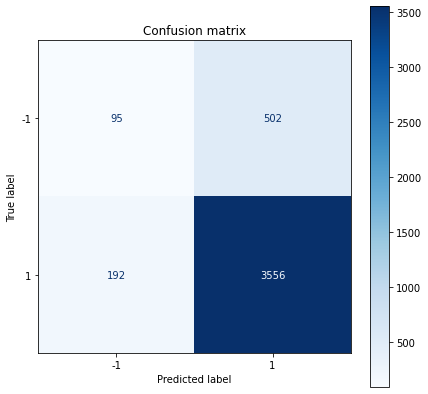

MLP Model with 3 hidden layers, each one 13 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.44      0.10      0.16       597
           1       0.87      0.98      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.65      0.54      0.54      4345
weighted avg       0.81      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


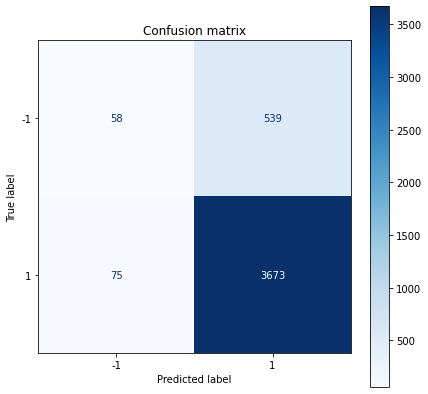

MLP Model with 3 hidden layers, each one 13 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.62      0.31      0.42       597
           1       0.90      0.97      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.76      0.64      0.67      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


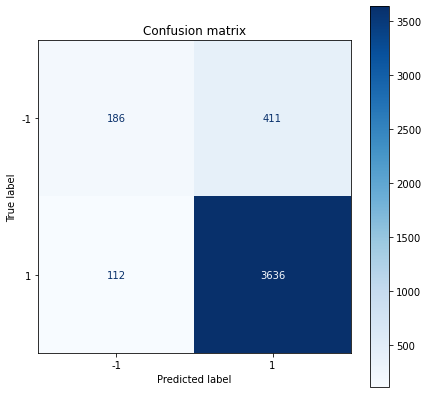

MLP Model with 3 hidden layers, each one 13 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.98      0.07      0.13       597
           1       0.87      1.00      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.92      0.54      0.53      4345
weighted avg       0.89      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


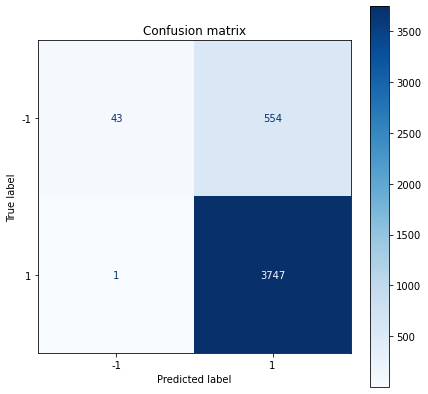

 19%|████████▍                                   | 4/21 [02:15<09:41, 34.22s/it]

----------------------------------------------------------------------------

Model 5
MLP Model with 3 hidden layers, each one 14 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.57      0.46      0.51       597
           1       0.92      0.94      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.74      0.70      0.72      4345
weighted avg       0.87      0.88      0.87      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


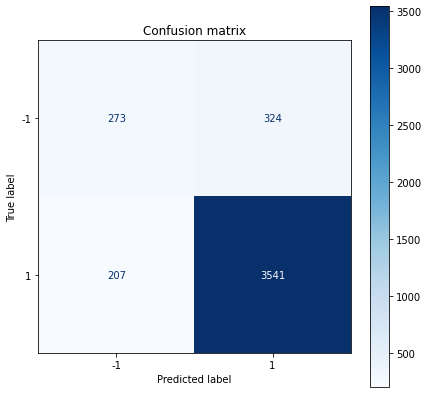

MLP Model with 3 hidden layers, each one 14 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.60      0.21      0.31       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.74      0.60      0.62      4345
weighted avg       0.85      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


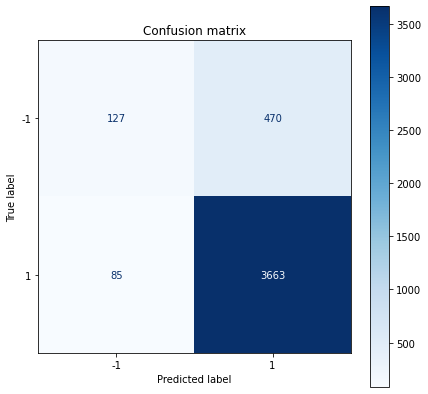

MLP Model with 3 hidden layers, each one 14 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.43      0.12      0.19       597
           1       0.87      0.97      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.65      0.55      0.56      4345
weighted avg       0.81      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


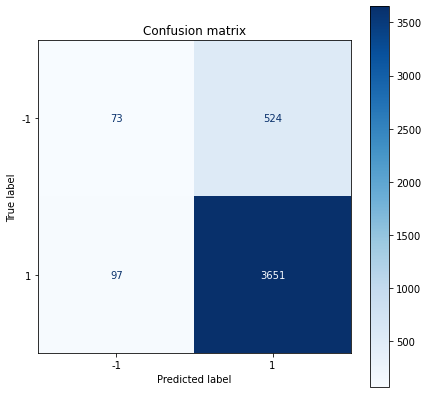

MLP Model with 3 hidden layers, each one 14 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.58      0.13      0.22       597
           1       0.88      0.98      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.73      0.56      0.57      4345
weighted avg       0.84      0.87      0.83      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


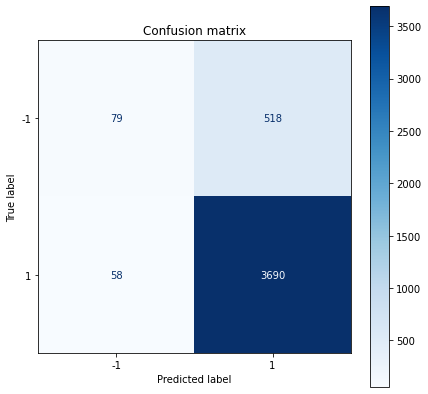

MLP Model with 3 hidden layers, each one 14 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.63      0.10      0.17       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.75      0.54      0.55      4345
weighted avg       0.84      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


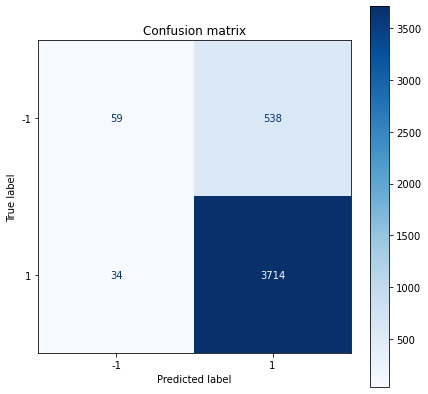

MLP Model with 3 hidden layers, each one 14 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


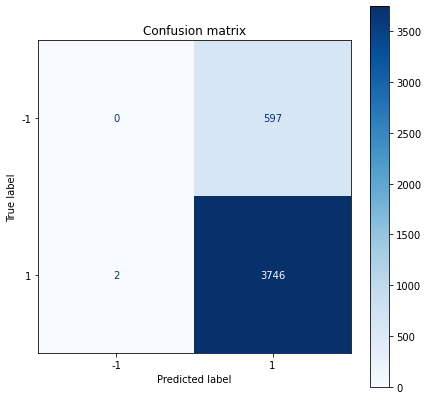

MLP Model with 3 hidden layers, each one 14 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.54      0.25      0.35       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.72      0.61      0.64      4345
weighted avg       0.84      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


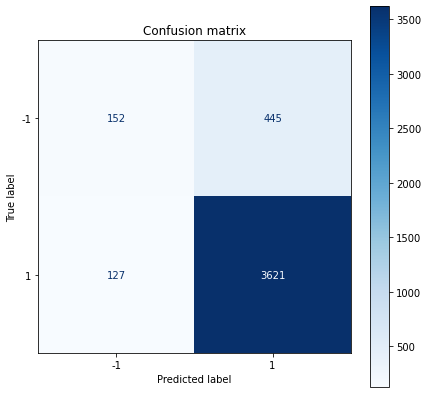

MLP Model with 3 hidden layers, each one 14 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.58      0.23      0.33       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.74      0.60      0.63      4345
weighted avg       0.85      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


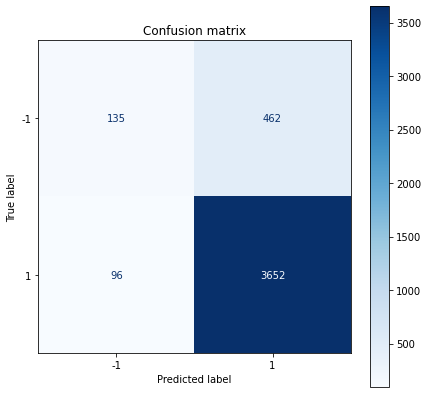

MLP Model with 3 hidden layers, each one 14 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.62      0.01      0.03       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.74      0.51      0.48      4345
weighted avg       0.83      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


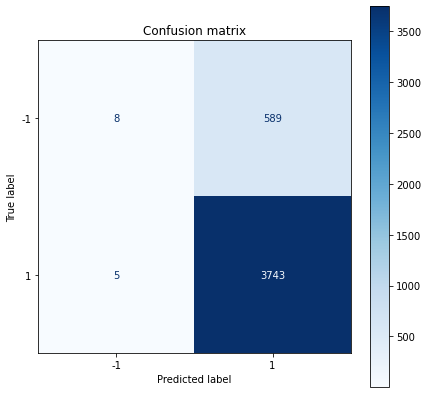

MLP Model with 3 hidden layers, each one 14 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.42      0.27      0.33       597
           1       0.89      0.94      0.92      3748

    accuracy                           0.85      4345
   macro avg       0.66      0.61      0.62      4345
weighted avg       0.83      0.85      0.84      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


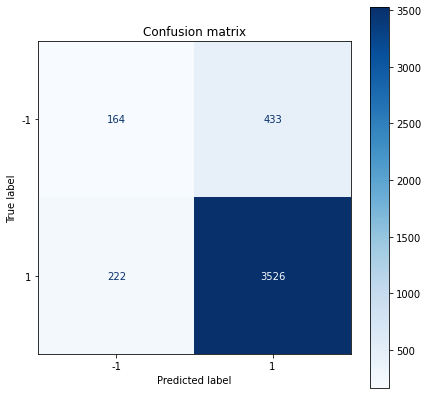

MLP Model with 3 hidden layers, each one 14 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.50      0.29      0.36       597
           1       0.89      0.95      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.69      0.62      0.64      4345
weighted avg       0.84      0.86      0.85      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


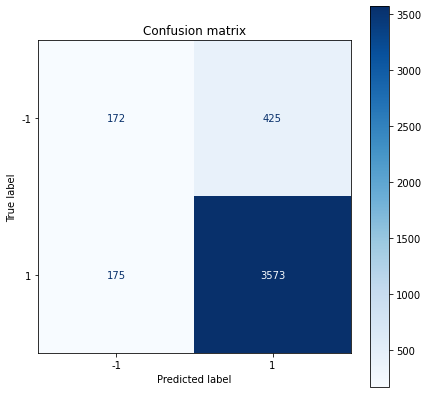

 24%|██████████▍                                 | 5/21 [02:43<08:27, 31.75s/it]

----------------------------------------------------------------------------

Model 6
MLP Model with 3 hidden layers, each one 15 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.72      0.09      0.15       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.80      0.54      0.54      4345
weighted avg       0.85      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


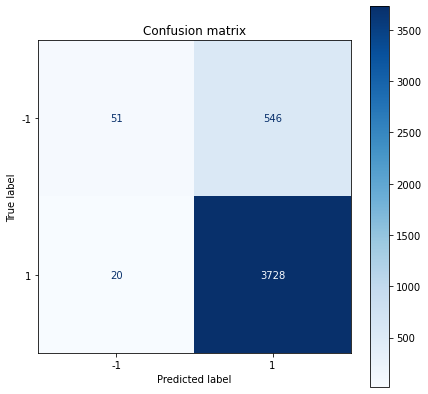

MLP Model with 3 hidden layers, each one 15 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.37      0.11      0.17       597
           1       0.87      0.97      0.92      3748

    accuracy                           0.85      4345
   macro avg       0.62      0.54      0.54      4345
weighted avg       0.80      0.85      0.82      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


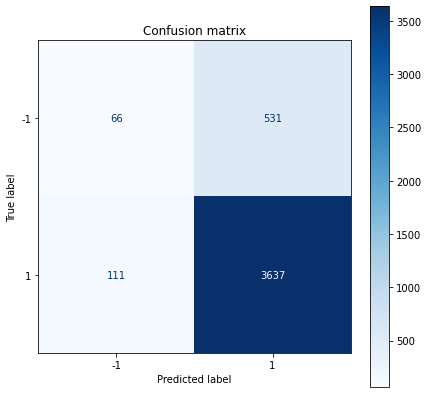

MLP Model with 3 hidden layers, each one 15 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.27      0.38       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.77      0.62      0.66      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


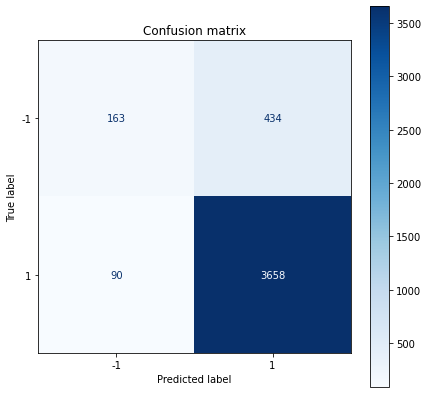

MLP Model with 3 hidden layers, each one 15 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.62      0.42      0.50       597
           1       0.91      0.96      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.77      0.69      0.72      4345
weighted avg       0.87      0.89      0.88      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


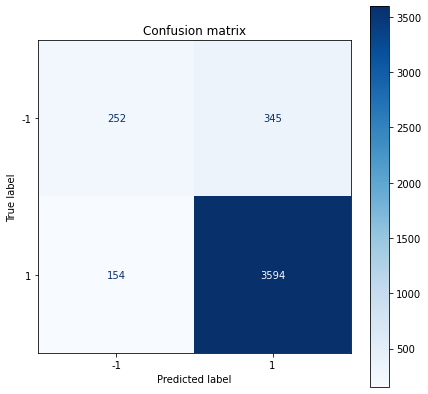

MLP Model with 3 hidden layers, each one 15 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.22      0.33       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.76      0.60      0.63      4345
weighted avg       0.85      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


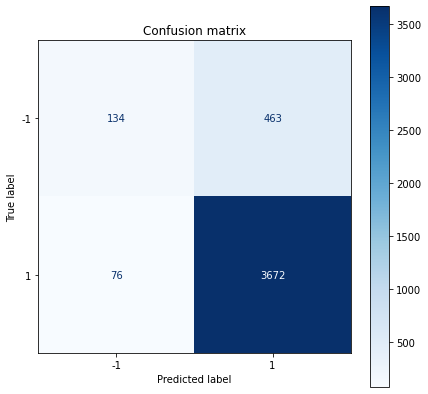

MLP Model with 3 hidden layers, each one 15 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       1.00      0.01      0.02       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.93      0.51      0.47      4345
weighted avg       0.88      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


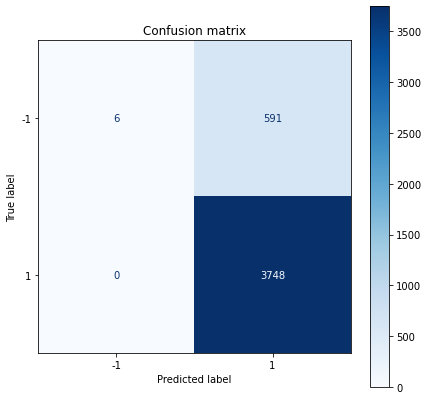

MLP Model with 3 hidden layers, each one 15 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.51      0.12      0.19       597
           1       0.87      0.98      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.69      0.55      0.56      4345
weighted avg       0.82      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


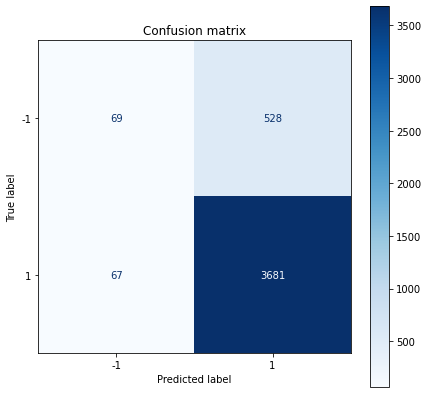

MLP Model with 3 hidden layers, each one 15 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.69      0.51      0.59       597
           1       0.93      0.96      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.81      0.74      0.77      4345
weighted avg       0.89      0.90      0.90      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


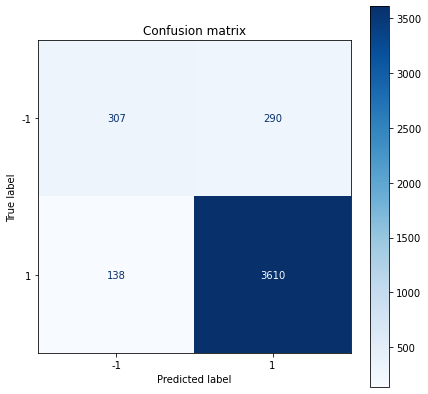

MLP Model with 3 hidden layers, each one 15 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.57      0.35      0.43       597
           1       0.90      0.96      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.74      0.65      0.68      4345
weighted avg       0.86      0.87      0.86      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


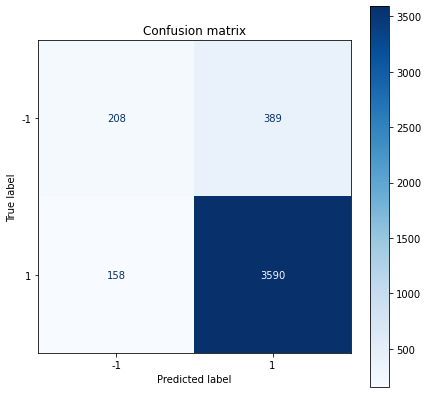

MLP Model with 3 hidden layers, each one 15 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.71      0.17      0.28       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.80      0.58      0.61      4345
weighted avg       0.86      0.88      0.84      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


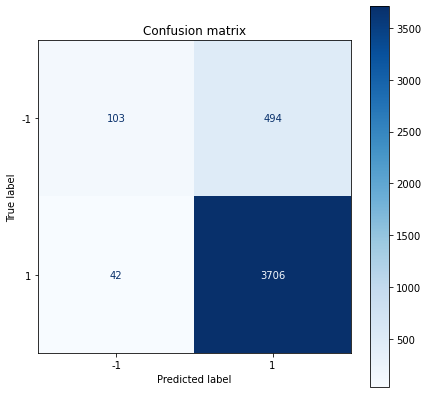

MLP Model with 3 hidden layers, each one 15 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.80      0.12      0.21       597
           1       0.88      1.00      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.84      0.56      0.57      4345
weighted avg       0.87      0.88      0.83      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


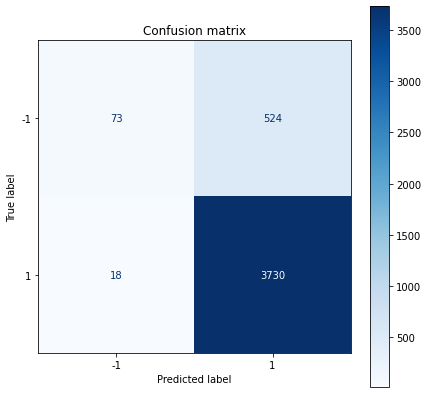

 29%|████████████▌                               | 6/21 [03:15<07:58, 31.89s/it]

----------------------------------------------------------------------------

Model 7
MLP Model with 3 hidden layers, each one 16 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.60      0.07      0.13       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.74      0.53      0.53      4345
weighted avg       0.83      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


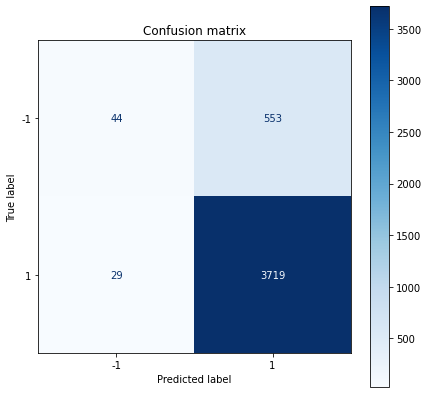

MLP Model with 3 hidden layers, each one 16 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.65      0.12      0.20       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.76      0.55      0.57      4345
weighted avg       0.84      0.87      0.83      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


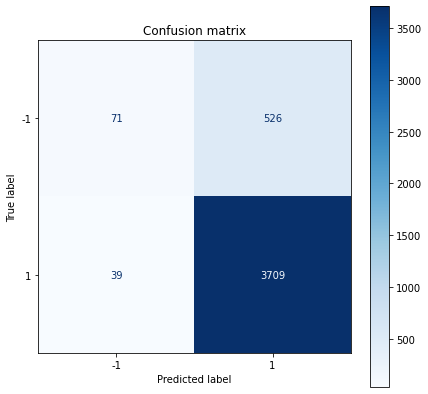

MLP Model with 3 hidden layers, each one 16 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.73      0.28      0.41       597
           1       0.90      0.98      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.81      0.63      0.67      4345
weighted avg       0.87      0.89      0.87      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


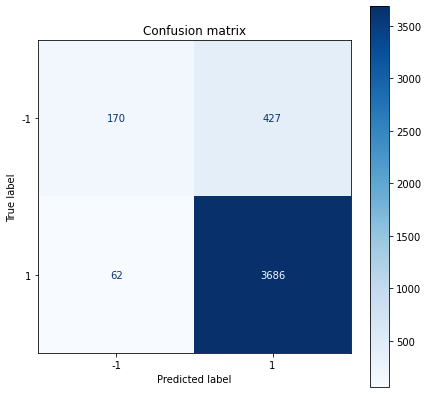

MLP Model with 3 hidden layers, each one 16 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.66      0.19      0.30       597
           1       0.88      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.77      0.59      0.62      4345
weighted avg       0.85      0.88      0.84      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


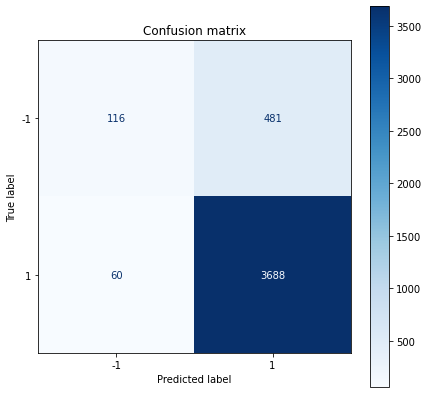

MLP Model with 3 hidden layers, each one 16 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.47      0.12      0.19       597
           1       0.87      0.98      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.67      0.55      0.56      4345
weighted avg       0.82      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


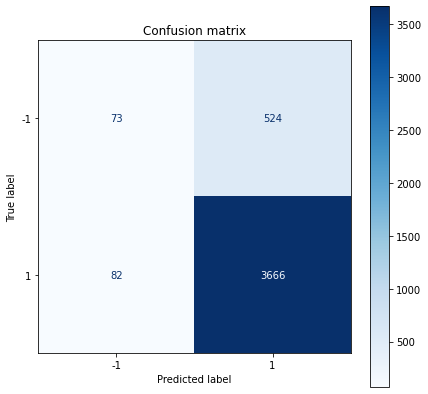

MLP Model with 3 hidden layers, each one 16 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.73      0.17      0.28       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.80      0.58      0.61      4345
weighted avg       0.86      0.88      0.84      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


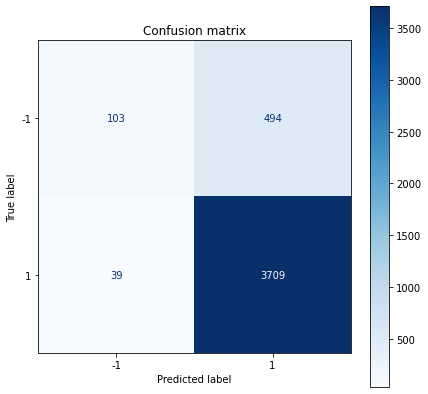

MLP Model with 3 hidden layers, each one 16 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.44      0.42      0.43       597
           1       0.91      0.91      0.91      3748

    accuracy                           0.85      4345
   macro avg       0.67      0.67      0.67      4345
weighted avg       0.84      0.85      0.84      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


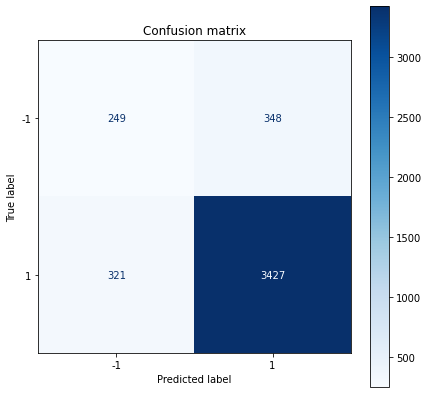

MLP Model with 3 hidden layers, each one 16 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.72      0.55      0.62       597
           1       0.93      0.97      0.95      3748

    accuracy                           0.91      4345
   macro avg       0.82      0.76      0.79      4345
weighted avg       0.90      0.91      0.90      4345

---------------------------------------------

Accuracy: 0.91


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


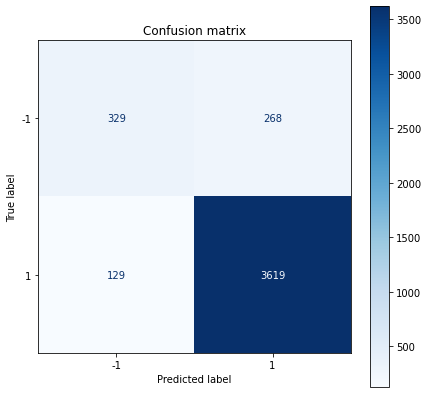

MLP Model with 3 hidden layers, each one 16 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.73      0.30      0.42       597
           1       0.90      0.98      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.81      0.64      0.68      4345
weighted avg       0.87      0.89      0.87      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


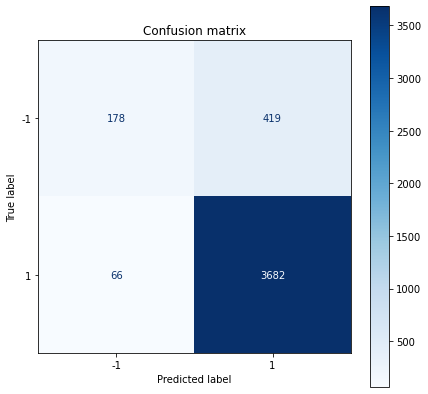

MLP Model with 3 hidden layers, each one 16 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.57      0.59      0.58       597
           1       0.93      0.93      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.75      0.76      0.76      4345
weighted avg       0.88      0.88      0.88      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


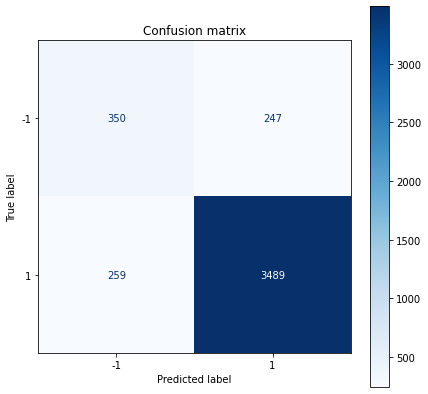

MLP Model with 3 hidden layers, each one 16 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.43      0.09      0.14       597
           1       0.87      0.98      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.65      0.53      0.53      4345
weighted avg       0.81      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


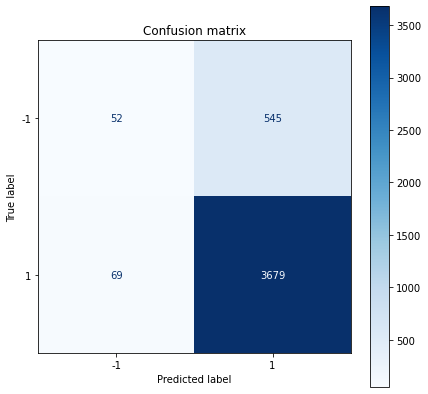

 33%|██████████████▋                             | 7/21 [03:47<07:26, 31.87s/it]

----------------------------------------------------------------------------

Model 8
MLP Model with 3 hidden layers, each one 17 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.78      0.41      0.54       597
           1       0.91      0.98      0.95      3748

    accuracy                           0.90      4345
   macro avg       0.85      0.70      0.74      4345
weighted avg       0.89      0.90      0.89      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


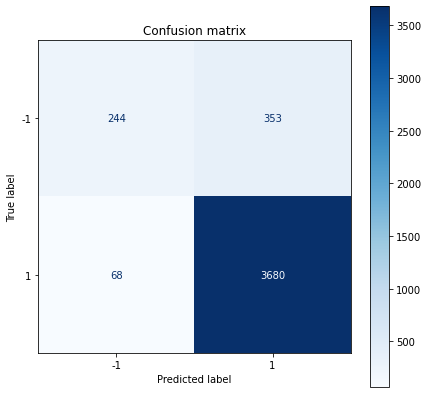

MLP Model with 3 hidden layers, each one 17 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.73      0.41      0.53       597
           1       0.91      0.98      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.82      0.69      0.73      4345
weighted avg       0.89      0.90      0.89      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


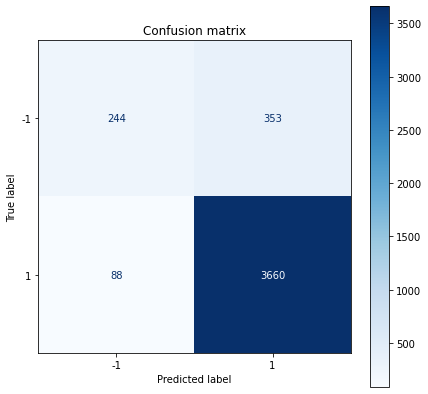

MLP Model with 3 hidden layers, each one 17 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.49      0.08      0.14       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.68      0.53      0.53      4345
weighted avg       0.82      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


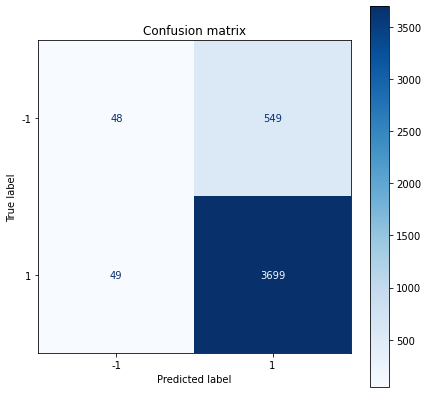

MLP Model with 3 hidden layers, each one 17 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.55      0.23      0.32       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.72      0.60      0.63      4345
weighted avg       0.84      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


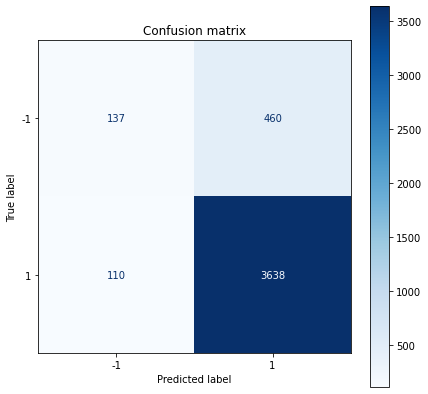

MLP Model with 3 hidden layers, each one 17 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.67      0.17      0.27       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.78      0.58      0.60      4345
weighted avg       0.85      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


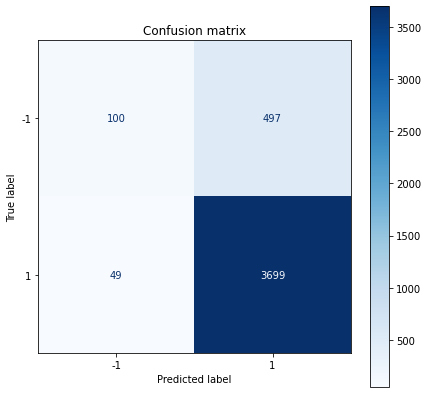

MLP Model with 3 hidden layers, each one 17 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.50      0.18      0.26       597
           1       0.88      0.97      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.69      0.57      0.59      4345
weighted avg       0.83      0.86      0.83      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


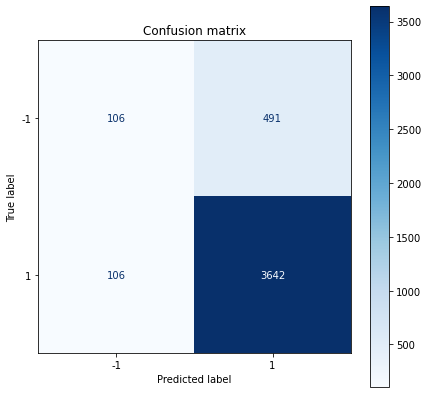

MLP Model with 3 hidden layers, each one 17 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.46      0.35      0.40       597
           1       0.90      0.94      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.68      0.64      0.66      4345
weighted avg       0.84      0.86      0.85      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


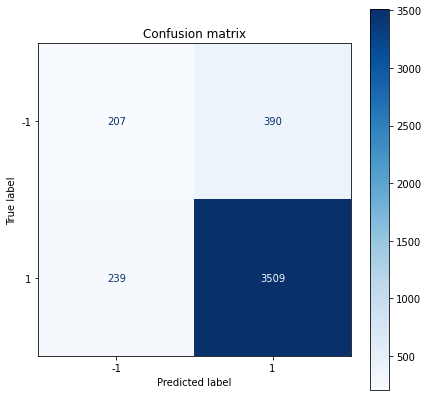

MLP Model with 3 hidden layers, each one 17 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       1.00      0.01      0.03       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.93      0.51      0.48      4345
weighted avg       0.88      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


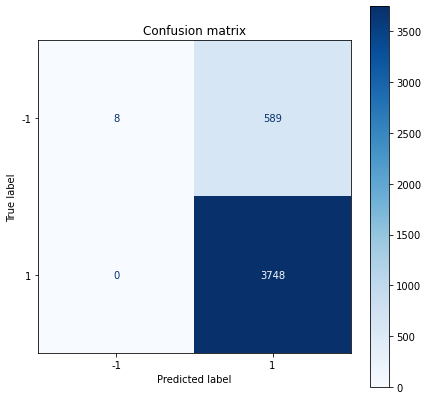

MLP Model with 3 hidden layers, each one 17 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

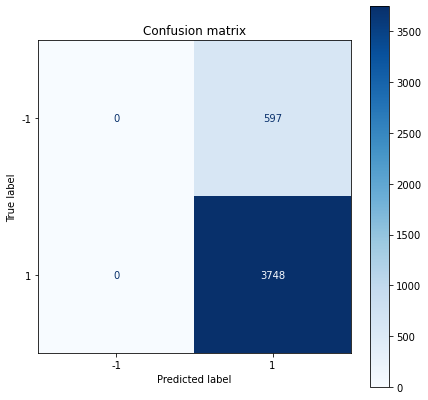

MLP Model with 3 hidden layers, each one 17 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.55      0.30      0.39       597
           1       0.90      0.96      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.73      0.63      0.66      4345
weighted avg       0.85      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


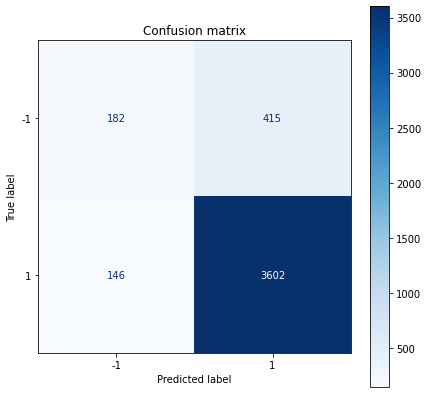

MLP Model with 3 hidden layers, each one 17 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       1.00      0.05      0.10       597
           1       0.87      1.00      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.93      0.53      0.51      4345
weighted avg       0.89      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


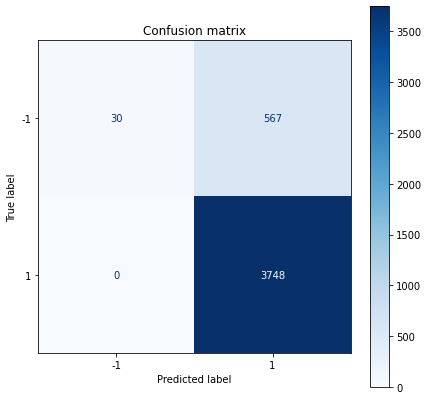

 38%|████████████████▊                           | 8/21 [04:27<07:28, 34.50s/it]

----------------------------------------------------------------------------

Model 9
MLP Model with 3 hidden layers, each one 18 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.48      0.07      0.11       597
           1       0.87      0.99      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.67      0.53      0.52      4345
weighted avg       0.82      0.86      0.81      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


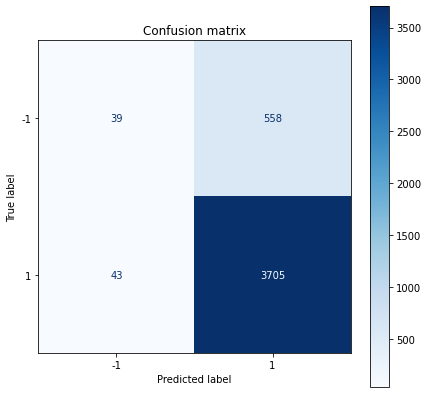

MLP Model with 3 hidden layers, each one 18 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.58      0.71      0.64       597
           1       0.95      0.92      0.93      3748

    accuracy                           0.89      4345
   macro avg       0.77      0.81      0.79      4345
weighted avg       0.90      0.89      0.89      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


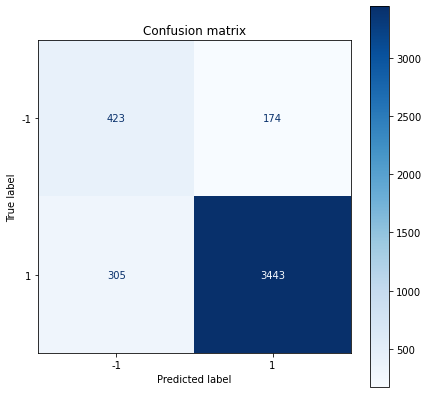

MLP Model with 3 hidden layers, each one 18 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.66      0.27      0.39       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.78      0.63      0.66      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


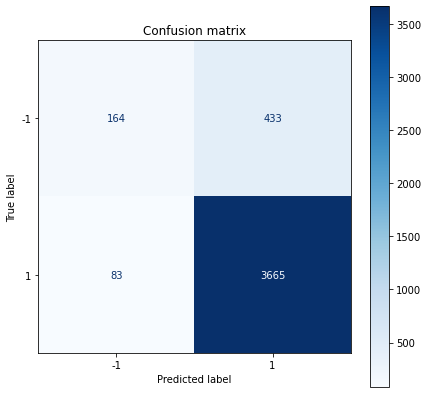

MLP Model with 3 hidden layers, each one 18 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.56      0.27      0.36       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.73      0.62      0.65      4345
weighted avg       0.85      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


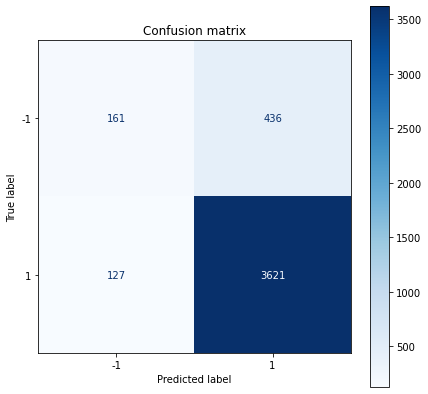

MLP Model with 3 hidden layers, each one 18 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.41      0.02      0.04       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.64      0.51      0.48      4345
weighted avg       0.80      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


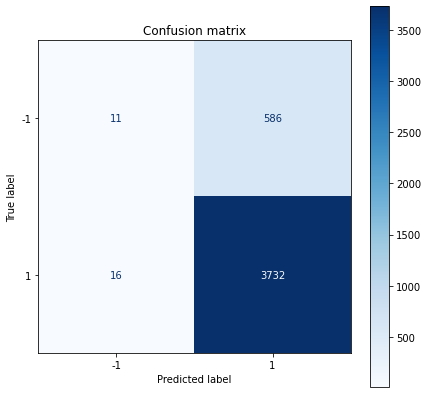

MLP Model with 3 hidden layers, each one 18 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.34      0.23      0.28       597
           1       0.88      0.93      0.90      3748

    accuracy                           0.83      4345
   macro avg       0.61      0.58      0.59      4345
weighted avg       0.81      0.83      0.82      4345

---------------------------------------------

Accuracy: 0.83


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


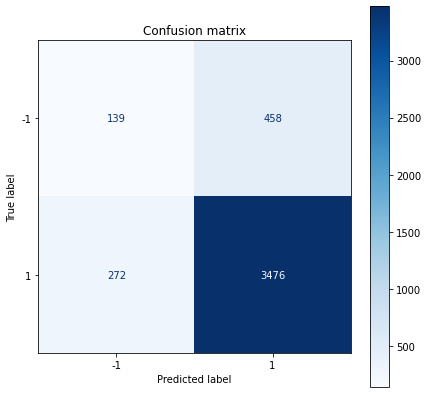

MLP Model with 3 hidden layers, each one 18 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.60      0.48      0.54       597
           1       0.92      0.95      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.76      0.72      0.73      4345
weighted avg       0.88      0.88      0.88      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


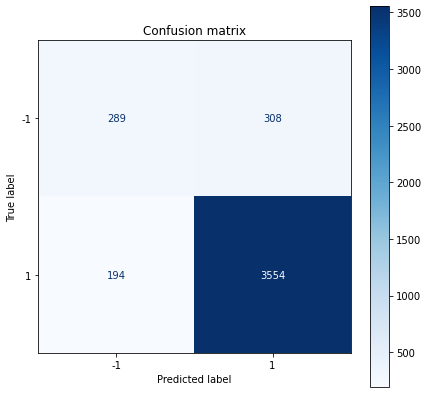

MLP Model with 3 hidden layers, each one 18 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.57      0.61      0.59       597
           1       0.94      0.93      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.75      0.77      0.76      4345
weighted avg       0.89      0.88      0.88      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


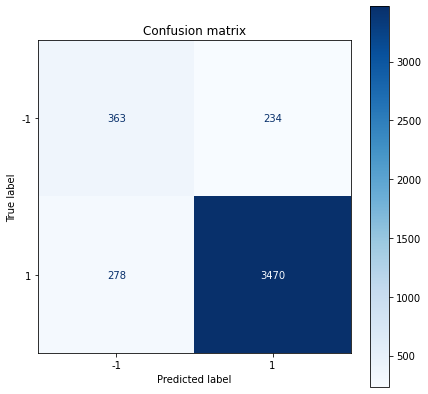

MLP Model with 3 hidden layers, each one 18 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.48      0.10      0.17       597
           1       0.87      0.98      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.68      0.54      0.55      4345
weighted avg       0.82      0.86      0.82      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


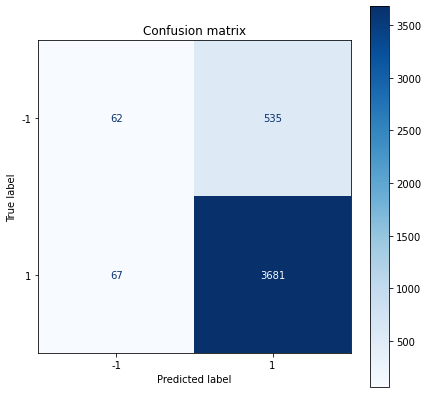

MLP Model with 3 hidden layers, each one 18 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.63      0.22      0.33       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.76      0.60      0.63      4345
weighted avg       0.85      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


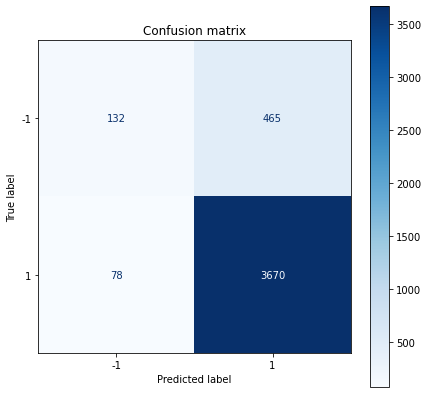

MLP Model with 3 hidden layers, each one 18 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.51      0.55      0.53       597
           1       0.93      0.92      0.92      3748

    accuracy                           0.87      4345
   macro avg       0.72      0.73      0.73      4345
weighted avg       0.87      0.87      0.87      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


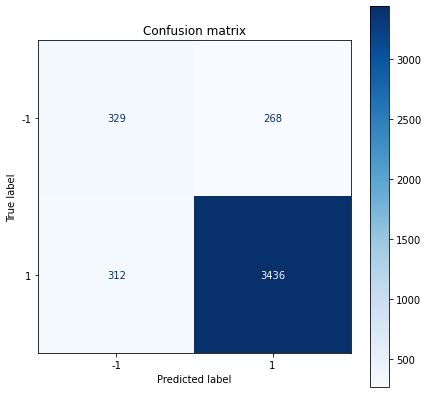

 43%|██████████████████▊                         | 9/21 [05:02<06:56, 34.75s/it]

----------------------------------------------------------------------------

Model 10
MLP Model with 3 hidden layers, each one 19 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.54      0.58      0.56       597
           1       0.93      0.92      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.73      0.75      0.74      4345
weighted avg       0.88      0.87      0.88      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


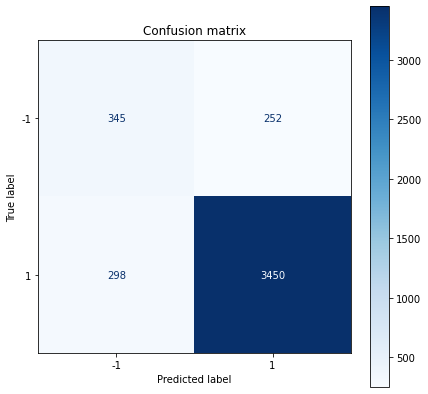

MLP Model with 3 hidden layers, each one 19 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.81      0.33      0.47       597
           1       0.90      0.99      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.85      0.66      0.71      4345
weighted avg       0.89      0.90      0.88      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


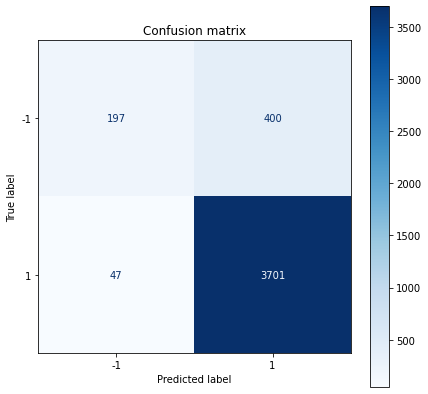

MLP Model with 3 hidden layers, each one 19 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.41      0.24      0.30       597
           1       0.89      0.95      0.92      3748

    accuracy                           0.85      4345
   macro avg       0.65      0.59      0.61      4345
weighted avg       0.82      0.85      0.83      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


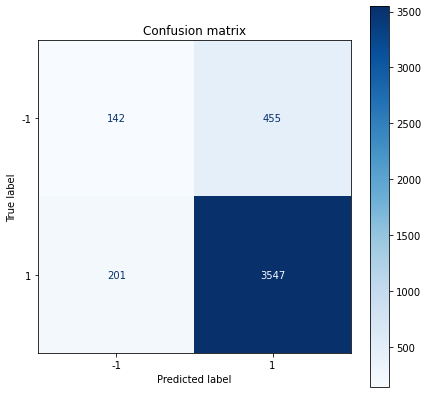

MLP Model with 3 hidden layers, each one 19 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.74      0.42      0.53       597
           1       0.91      0.98      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.83      0.70      0.74      4345
weighted avg       0.89      0.90      0.89      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


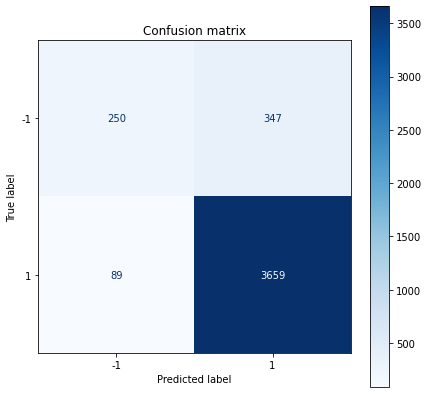

MLP Model with 3 hidden layers, each one 19 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.80      0.02      0.04       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.83      0.51      0.48      4345
weighted avg       0.86      0.86      0.81      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


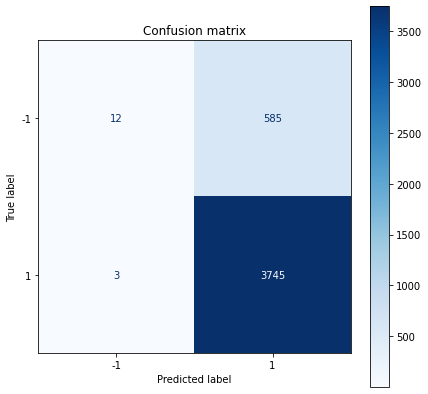

MLP Model with 3 hidden layers, each one 19 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.48      0.46      0.47       597
           1       0.91      0.92      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.70      0.69      0.69      4345
weighted avg       0.85      0.86      0.86      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


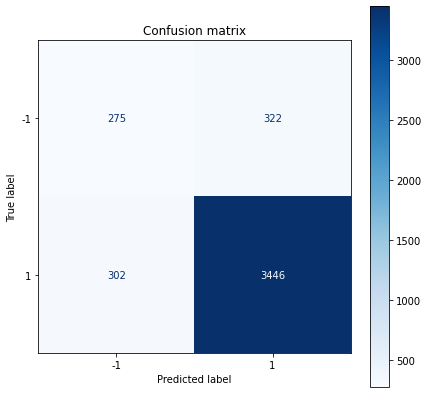

MLP Model with 3 hidden layers, each one 19 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.68      0.32      0.44       597
           1       0.90      0.98      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.79      0.65      0.69      4345
weighted avg       0.87      0.89      0.87      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


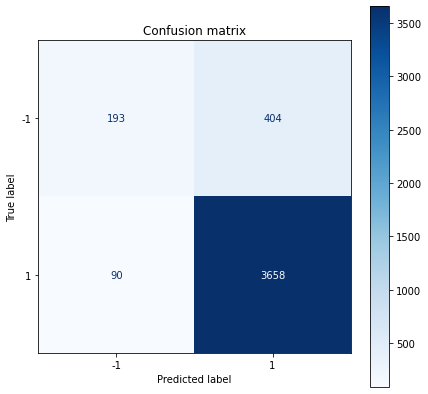

MLP Model with 3 hidden layers, each one 19 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.55      0.12      0.20       597
           1       0.88      0.98      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.71      0.55      0.56      4345
weighted avg       0.83      0.87      0.83      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


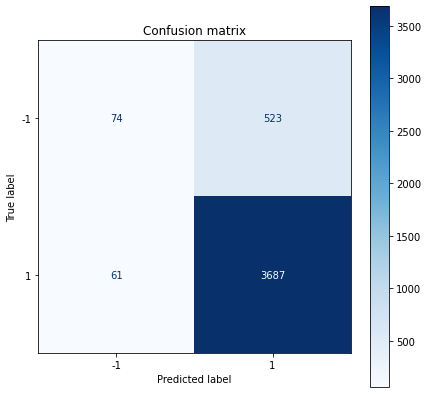

MLP Model with 3 hidden layers, each one 19 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.63      0.22      0.33       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.76      0.60      0.63      4345
weighted avg       0.85      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


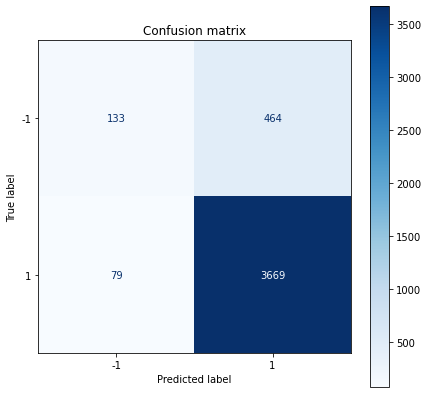

MLP Model with 3 hidden layers, each one 19 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.60      0.37      0.45       597
           1       0.90      0.96      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.75      0.66      0.69      4345
weighted avg       0.86      0.88      0.87      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


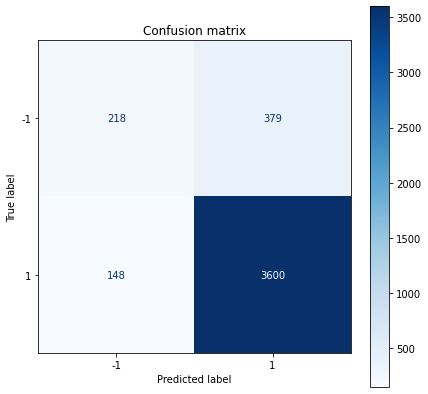

MLP Model with 3 hidden layers, each one 19 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.44      0.39      0.41       597
           1       0.90      0.92      0.91      3748

    accuracy                           0.85      4345
   macro avg       0.67      0.66      0.66      4345
weighted avg       0.84      0.85      0.84      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


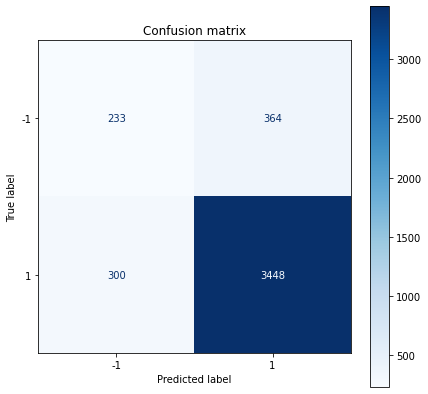

 48%|████████████████████▍                      | 10/21 [05:44<06:47, 37.01s/it]

----------------------------------------------------------------------------

Model 11
MLP Model with 3 hidden layers, each one 20 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.50      0.26      0.34       597
           1       0.89      0.96      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.69      0.61      0.63      4345
weighted avg       0.84      0.86      0.84      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


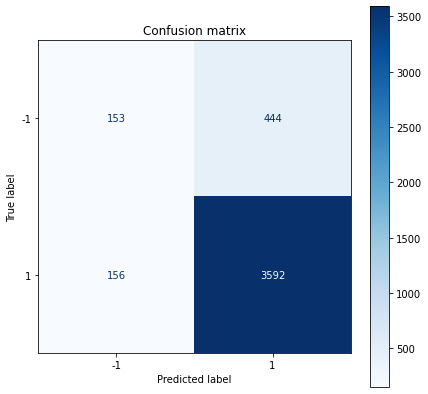

MLP Model with 3 hidden layers, each one 20 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.61      0.28      0.39       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.75      0.63      0.66      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


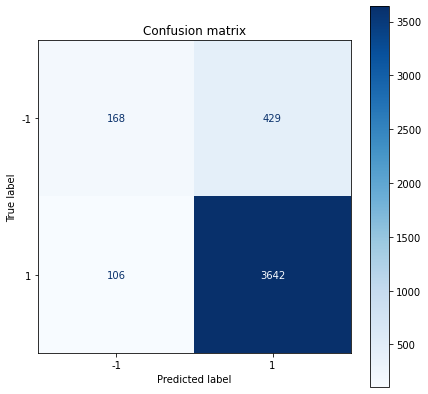

MLP Model with 3 hidden layers, each one 20 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

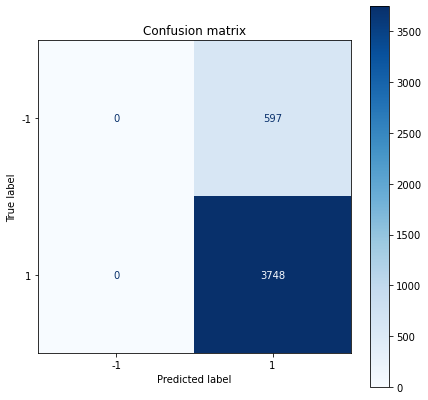

MLP Model with 3 hidden layers, each one 20 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.65      0.30      0.41       597
           1       0.90      0.97      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.77      0.64      0.67      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


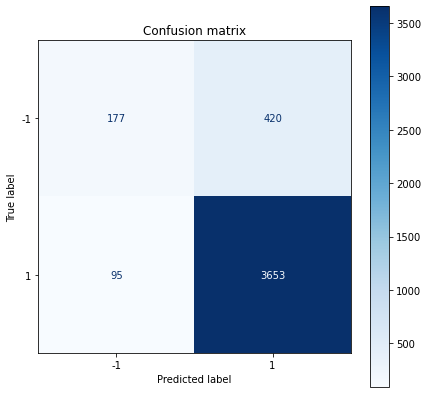

MLP Model with 3 hidden layers, each one 20 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.54      0.22      0.31       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.71      0.60      0.62      4345
weighted avg       0.84      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


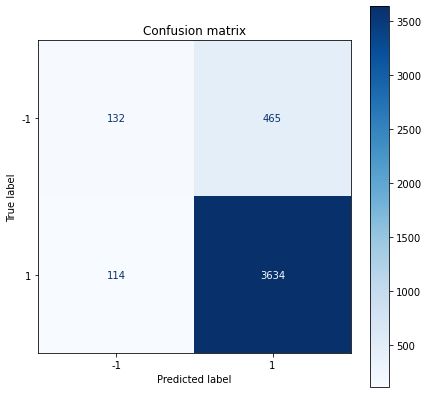

MLP Model with 3 hidden layers, each one 20 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.65      0.49      0.56       597
           1       0.92      0.96      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.79      0.72      0.75      4345
weighted avg       0.89      0.89      0.89      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


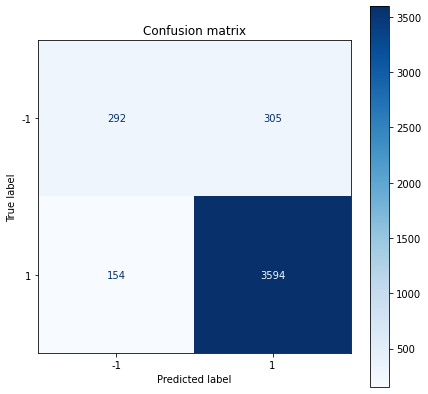

MLP Model with 3 hidden layers, each one 20 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.52      0.60      0.56       597
           1       0.94      0.91      0.92      3748

    accuracy                           0.87      4345
   macro avg       0.73      0.76      0.74      4345
weighted avg       0.88      0.87      0.87      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


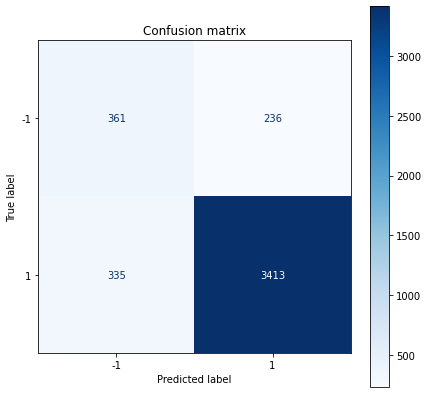

MLP Model with 3 hidden layers, each one 20 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.74      0.28      0.40       597
           1       0.90      0.98      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.82      0.63      0.67      4345
weighted avg       0.87      0.89      0.86      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


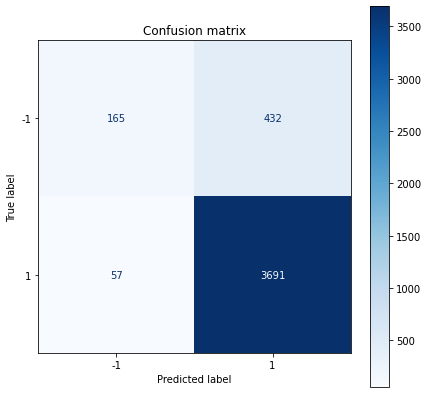

MLP Model with 3 hidden layers, each one 20 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.56      0.43      0.49       597
           1       0.91      0.95      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.74      0.69      0.71      4345
weighted avg       0.86      0.88      0.87      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


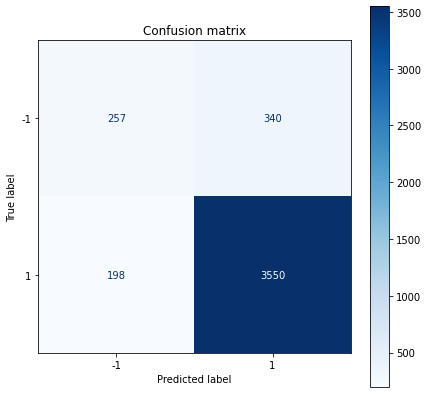

MLP Model with 3 hidden layers, each one 20 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.74      0.13      0.21       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.81      0.56      0.57      4345
weighted avg       0.86      0.87      0.83      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


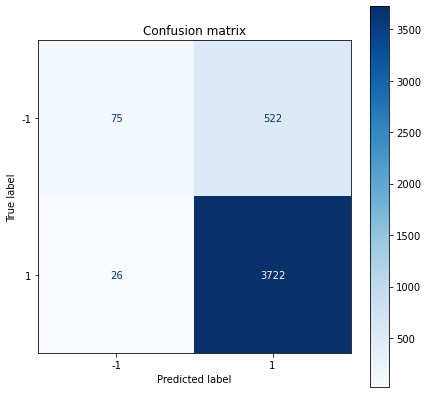

MLP Model with 3 hidden layers, each one 20 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.80      0.40      0.54       597
           1       0.91      0.98      0.95      3748

    accuracy                           0.90      4345
   macro avg       0.86      0.69      0.74      4345
weighted avg       0.90      0.90      0.89      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


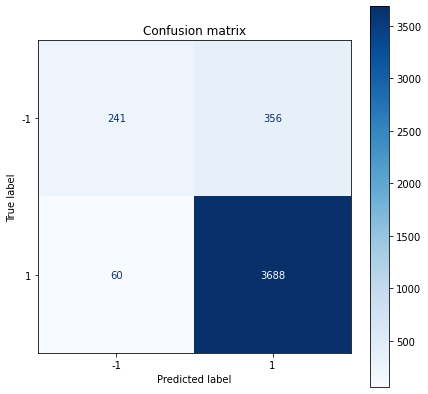

 52%|██████████████████████▌                    | 11/21 [06:22<06:13, 37.37s/it]

----------------------------------------------------------------------------

Model 12
MLP Model with 3 hidden layers, each one 21 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.36      0.40      0.38       597
           1       0.90      0.89      0.90      3748

    accuracy                           0.82      4345
   macro avg       0.63      0.64      0.64      4345
weighted avg       0.83      0.82      0.82      4345

---------------------------------------------

Accuracy: 0.82


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


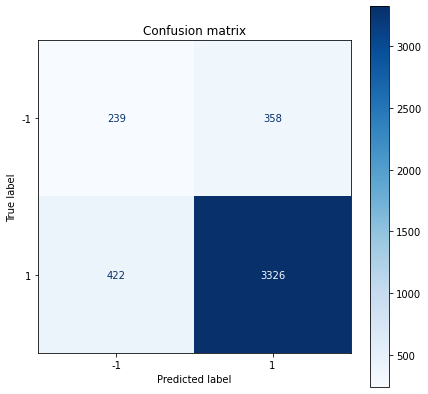

MLP Model with 3 hidden layers, each one 21 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.42      0.19      0.26       597
           1       0.88      0.96      0.92      3748

    accuracy                           0.85      4345
   macro avg       0.65      0.57      0.59      4345
weighted avg       0.82      0.85      0.83      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


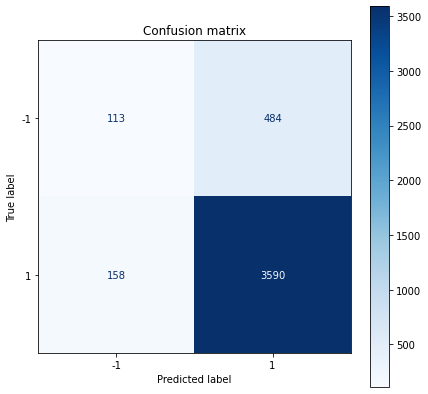

MLP Model with 3 hidden layers, each one 21 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.57      0.63      0.60       597
           1       0.94      0.92      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.75      0.78      0.77      4345
weighted avg       0.89      0.88      0.89      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


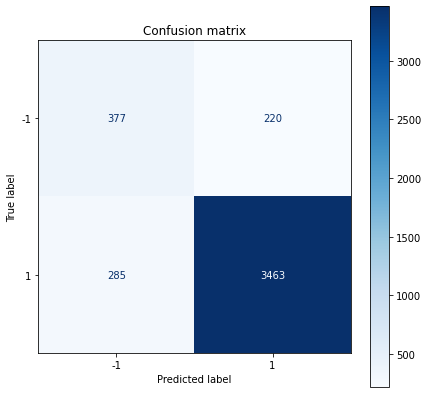

MLP Model with 3 hidden layers, each one 21 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.73      0.03      0.06       597
           1       0.87      1.00      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.80      0.51      0.49      4345
weighted avg       0.85      0.87      0.81      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


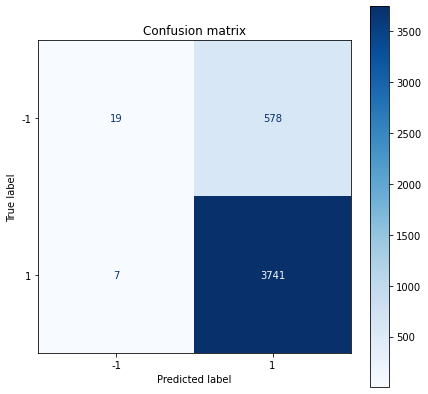

MLP Model with 3 hidden layers, each one 21 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.61      0.63      0.62       597
           1       0.94      0.94      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.78      0.78      0.78      4345
weighted avg       0.90      0.89      0.89      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


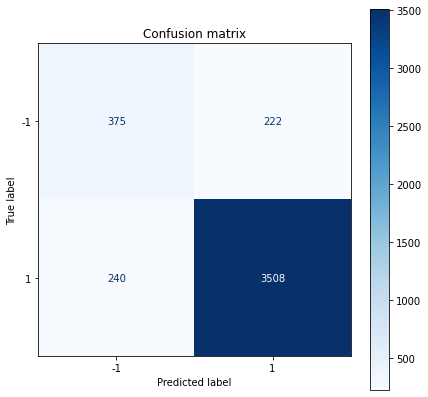

MLP Model with 3 hidden layers, each one 21 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.71      0.34      0.46       597
           1       0.90      0.98      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.81      0.66      0.70      4345
weighted avg       0.88      0.89      0.87      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


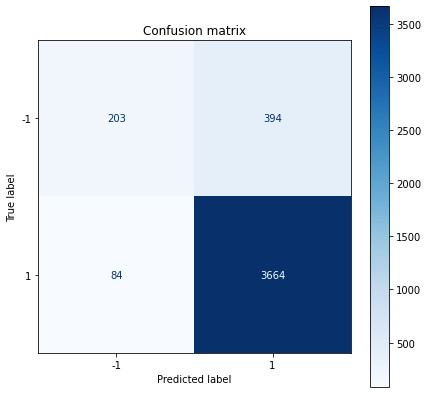

MLP Model with 3 hidden layers, each one 21 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.53      0.81      0.64       597
           1       0.97      0.89      0.92      3748

    accuracy                           0.87      4345
   macro avg       0.75      0.85      0.78      4345
weighted avg       0.91      0.87      0.88      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


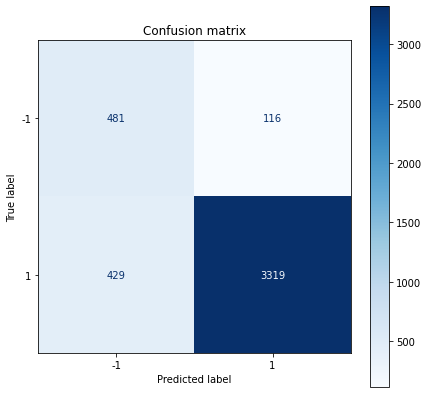

MLP Model with 3 hidden layers, each one 21 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.46      0.57      0.51       597
           1       0.93      0.89      0.91      3748

    accuracy                           0.85      4345
   macro avg       0.69      0.73      0.71      4345
weighted avg       0.86      0.85      0.86      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


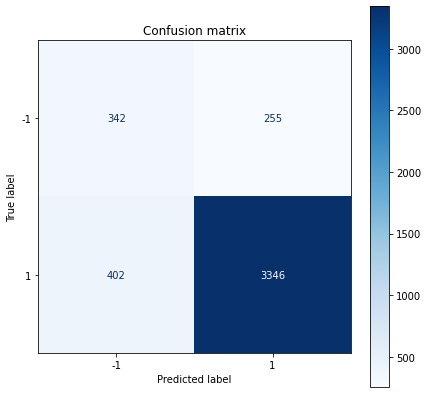

MLP Model with 3 hidden layers, each one 21 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       1.00      0.03      0.05       597
           1       0.87      1.00      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.93      0.51      0.49      4345
weighted avg       0.88      0.87      0.81      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


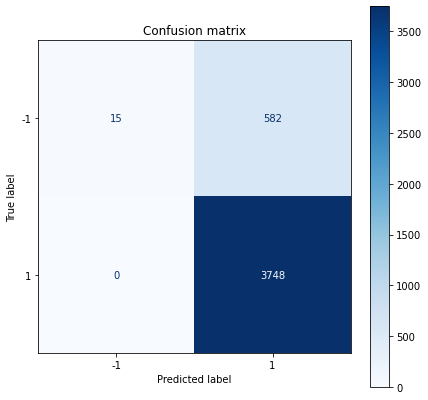

MLP Model with 3 hidden layers, each one 21 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.57      0.28      0.38       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.73      0.62      0.65      4345
weighted avg       0.85      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


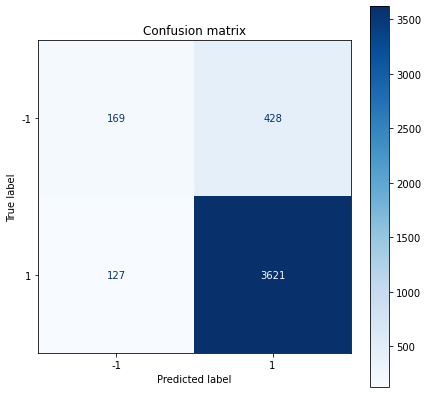

MLP Model with 3 hidden layers, each one 21 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.47      0.46      0.46       597
           1       0.91      0.92      0.92      3748

    accuracy                           0.85      4345
   macro avg       0.69      0.69      0.69      4345
weighted avg       0.85      0.85      0.85      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


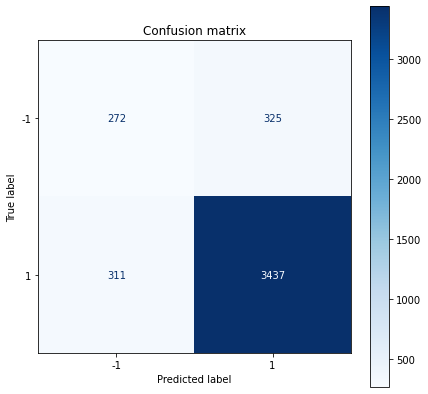

 57%|████████████████████████▌                  | 12/21 [07:06<05:53, 39.24s/it]

----------------------------------------------------------------------------

Model 13
MLP Model with 3 hidden layers, each one 22 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.57      0.07      0.13       597
           1       0.87      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.72      0.53      0.53      4345
weighted avg       0.83      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


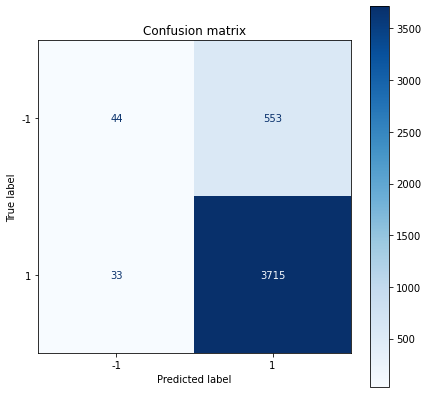

MLP Model with 3 hidden layers, each one 22 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.34      0.19      0.24       597
           1       0.88      0.94      0.91      3748

    accuracy                           0.84      4345
   macro avg       0.61      0.57      0.58      4345
weighted avg       0.80      0.84      0.82      4345

---------------------------------------------

Accuracy: 0.84


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


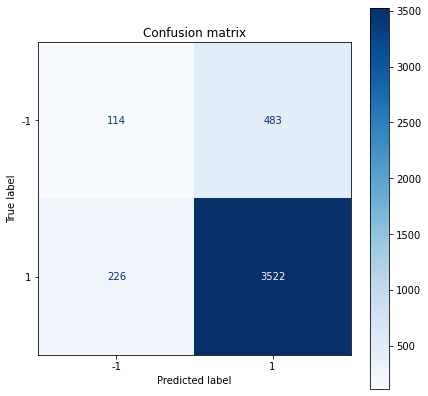

MLP Model with 3 hidden layers, each one 22 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.20      0.30       597
           1       0.88      0.98      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.76      0.59      0.62      4345
weighted avg       0.85      0.87      0.84      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


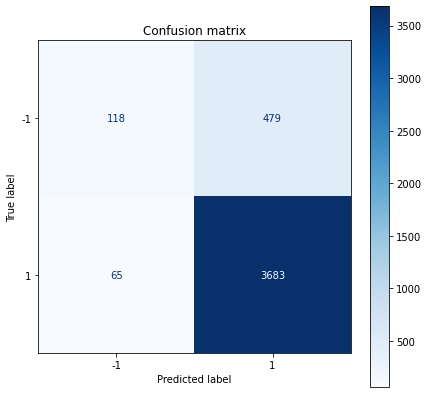

MLP Model with 3 hidden layers, each one 22 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.56      0.31      0.40       597
           1       0.90      0.96      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.73      0.64      0.66      4345
weighted avg       0.85      0.87      0.86      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


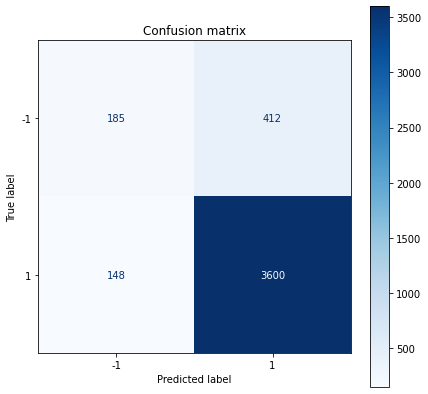

MLP Model with 3 hidden layers, each one 22 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.77      0.25      0.38       597
           1       0.89      0.99      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.83      0.62      0.66      4345
weighted avg       0.88      0.89      0.86      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


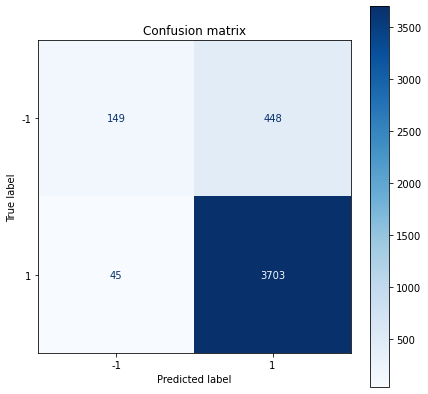

MLP Model with 3 hidden layers, each one 22 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.71      0.20      0.31       597
           1       0.89      0.99      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.80      0.59      0.62      4345
weighted avg       0.86      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


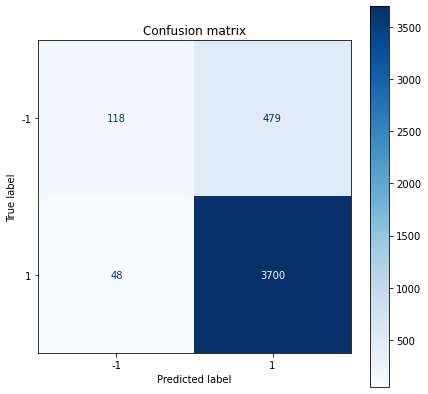

MLP Model with 3 hidden layers, each one 22 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.78      0.37      0.50       597
           1       0.91      0.98      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.85      0.68      0.72      4345
weighted avg       0.89      0.90      0.88      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


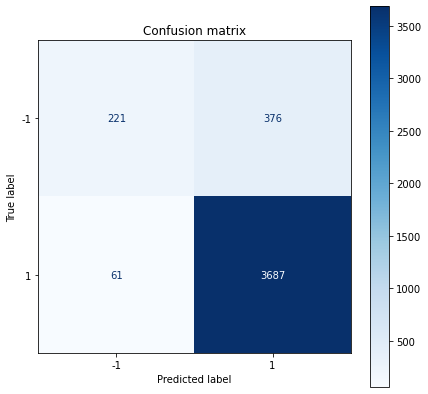

MLP Model with 3 hidden layers, each one 22 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.44      0.33      0.37       597
           1       0.90      0.93      0.91      3748

    accuracy                           0.85      4345
   macro avg       0.67      0.63      0.64      4345
weighted avg       0.83      0.85      0.84      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


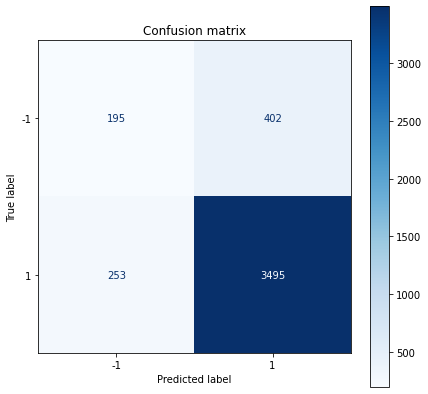

MLP Model with 3 hidden layers, each one 22 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.63      0.31      0.42       597
           1       0.90      0.97      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.77      0.64      0.67      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


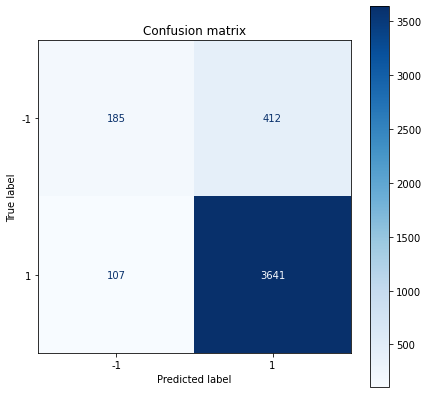

MLP Model with 3 hidden layers, each one 22 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.67      0.35      0.46       597
           1       0.90      0.97      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.79      0.66      0.70      4345
weighted avg       0.87      0.89      0.87      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


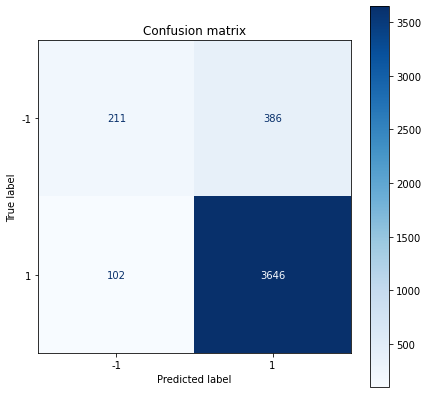

MLP Model with 3 hidden layers, each one 22 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.96      0.08      0.14       597
           1       0.87      1.00      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.92      0.54      0.54      4345
weighted avg       0.88      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


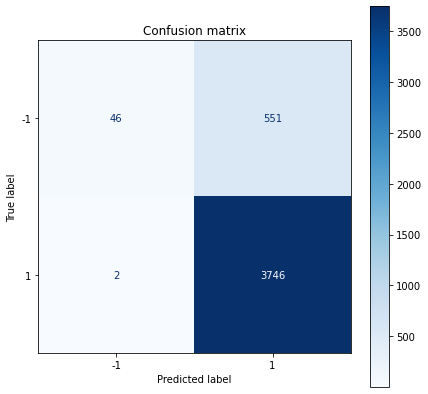

 62%|██████████████████████████▌                | 13/21 [07:59<05:48, 43.57s/it]

----------------------------------------------------------------------------

Model 14
MLP Model with 3 hidden layers, each one 23 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.83      0.18      0.30       597
           1       0.88      0.99      0.94      3748

    accuracy                           0.88      4345
   macro avg       0.85      0.59      0.62      4345
weighted avg       0.88      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


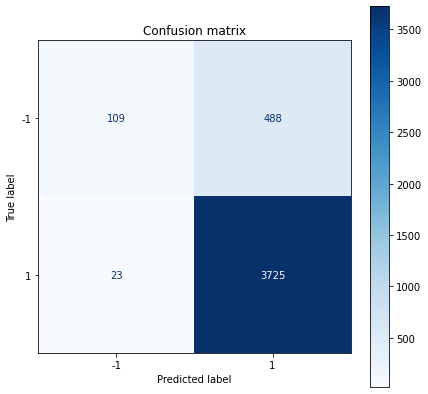

MLP Model with 3 hidden layers, each one 23 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.65      0.27      0.38       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.77      0.62      0.66      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


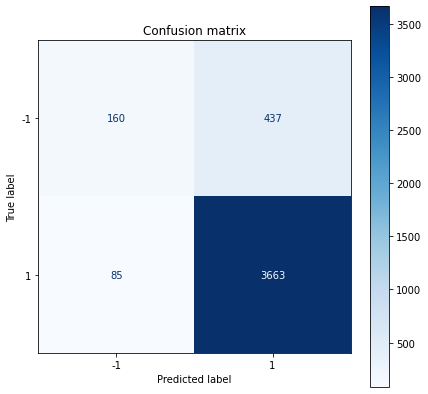

MLP Model with 3 hidden layers, each one 23 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.56      0.04      0.07       597
           1       0.87      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.71      0.52      0.50      4345
weighted avg       0.82      0.86      0.81      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


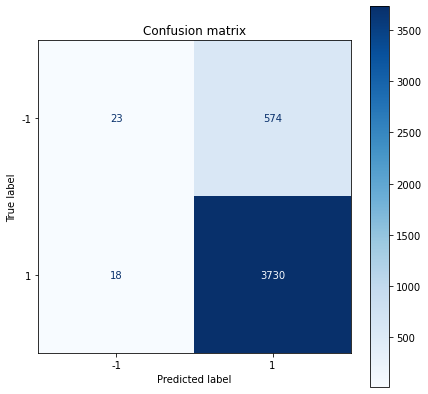

MLP Model with 3 hidden layers, each one 23 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.70      0.50      0.59       597
           1       0.92      0.97      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.81      0.73      0.77      4345
weighted avg       0.89      0.90      0.90      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


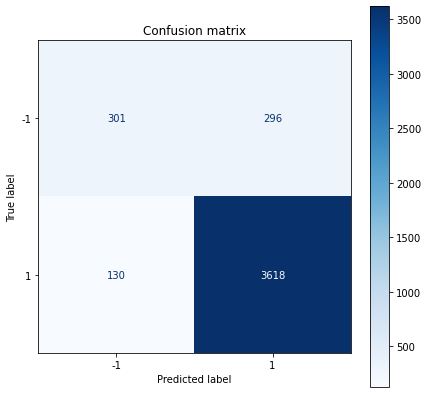

MLP Model with 3 hidden layers, each one 23 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.67      0.65      0.66       597
           1       0.94      0.95      0.95      3748

    accuracy                           0.91      4345
   macro avg       0.81      0.80      0.80      4345
weighted avg       0.91      0.91      0.91      4345

---------------------------------------------

Accuracy: 0.91


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


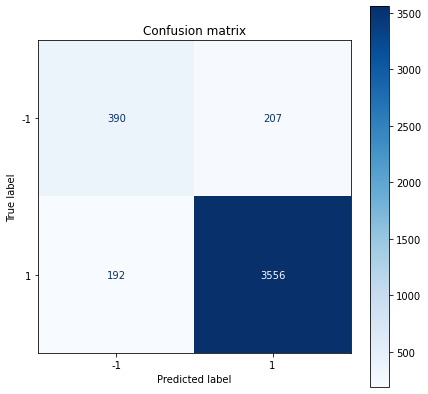

MLP Model with 3 hidden layers, each one 23 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.82      0.09      0.17       597
           1       0.87      1.00      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.85      0.54      0.55      4345
weighted avg       0.87      0.87      0.83      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


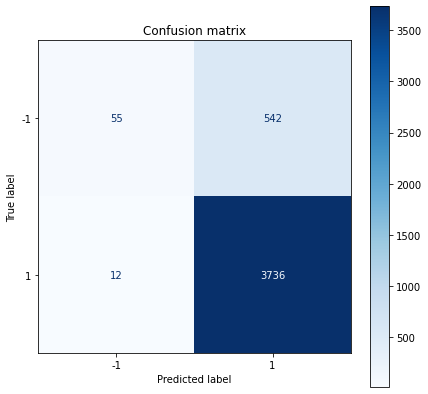

MLP Model with 3 hidden layers, each one 23 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.61      0.39      0.48       597
           1       0.91      0.96      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.76      0.68      0.71      4345
weighted avg       0.87      0.88      0.87      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


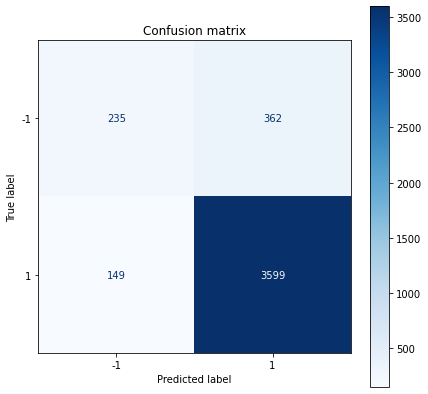

MLP Model with 3 hidden layers, each one 23 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.51      0.50      0.51       597
           1       0.92      0.92      0.92      3748

    accuracy                           0.87      4345
   macro avg       0.72      0.71      0.71      4345
weighted avg       0.86      0.87      0.87      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


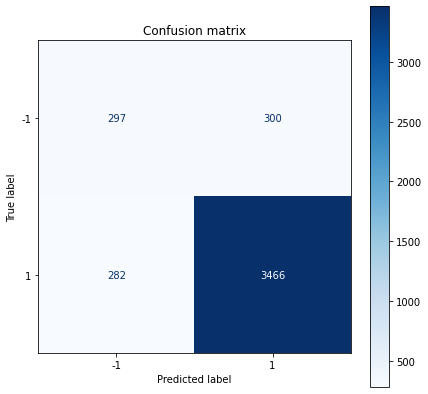

MLP Model with 3 hidden layers, each one 23 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.57      0.14      0.22       597
           1       0.88      0.98      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.72      0.56      0.58      4345
weighted avg       0.84      0.87      0.83      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


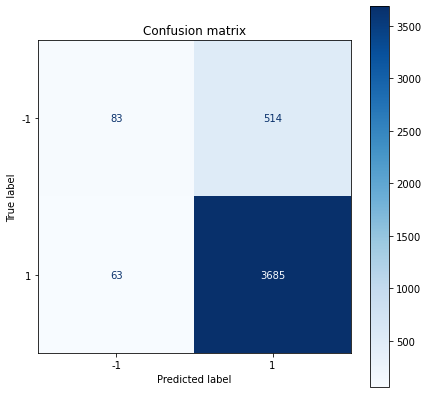

MLP Model with 3 hidden layers, each one 23 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.47      0.27      0.35       597
           1       0.89      0.95      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.68      0.61      0.63      4345
weighted avg       0.83      0.86      0.84      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


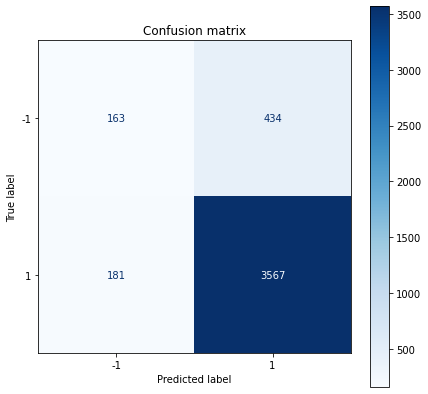

MLP Model with 3 hidden layers, each one 23 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.49      0.73      0.59       597
           1       0.95      0.88      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.72      0.81      0.75      4345
weighted avg       0.89      0.86      0.87      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


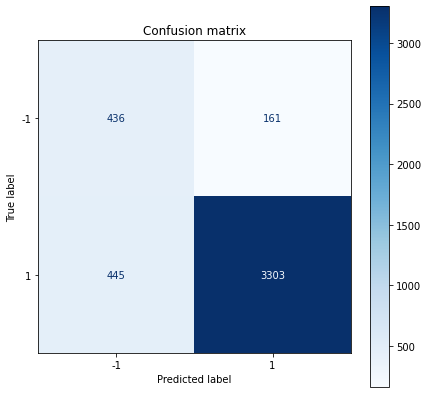

 67%|████████████████████████████▋              | 14/21 [08:49<05:18, 45.51s/it]

----------------------------------------------------------------------------

Model 15
MLP Model with 3 hidden layers, each one 24 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.40      0.05      0.09       597
           1       0.87      0.99      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.63      0.52      0.51      4345
weighted avg       0.80      0.86      0.81      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


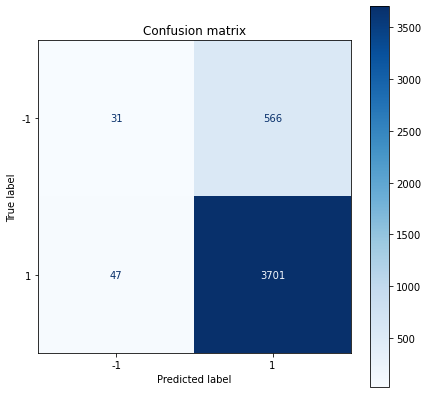

MLP Model with 3 hidden layers, each one 24 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.74      0.36      0.48       597
           1       0.91      0.98      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.82      0.67      0.71      4345
weighted avg       0.88      0.89      0.88      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


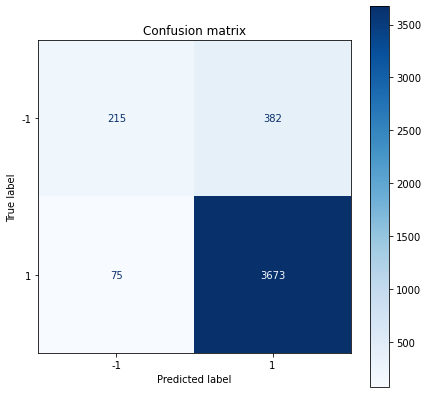

MLP Model with 3 hidden layers, each one 24 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.75      0.56      0.64       597
           1       0.93      0.97      0.95      3748

    accuracy                           0.91      4345
   macro avg       0.84      0.77      0.80      4345
weighted avg       0.91      0.91      0.91      4345

---------------------------------------------

Accuracy: 0.91


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


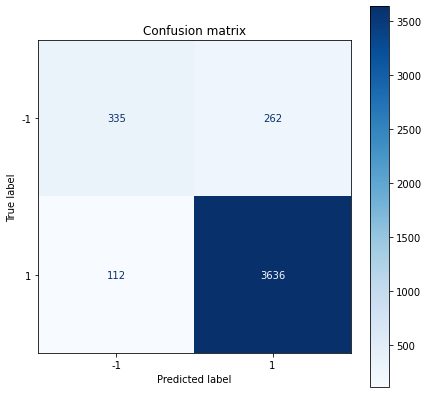

MLP Model with 3 hidden layers, each one 24 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.58      0.54      0.56       597
           1       0.93      0.94      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.76      0.74      0.75      4345
weighted avg       0.88      0.88      0.88      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


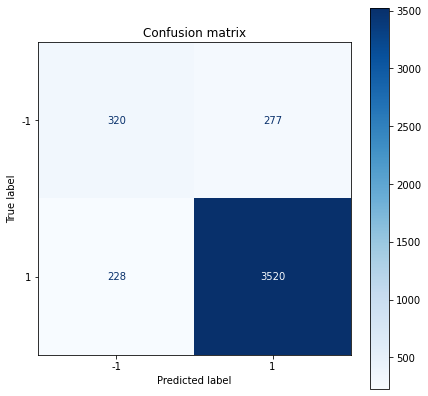

MLP Model with 3 hidden layers, each one 24 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.63      0.54      0.58       597
           1       0.93      0.95      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.78      0.74      0.76      4345
weighted avg       0.89      0.89      0.89      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


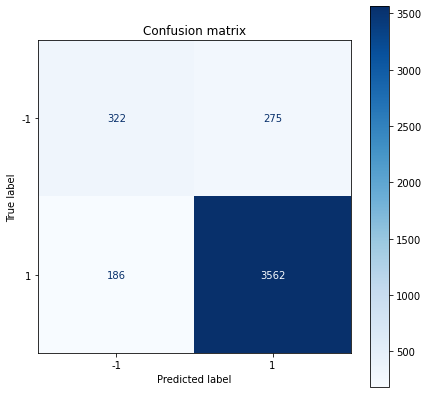

MLP Model with 3 hidden layers, each one 24 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.76      0.38      0.51       597
           1       0.91      0.98      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.84      0.68      0.73      4345
weighted avg       0.89      0.90      0.88      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


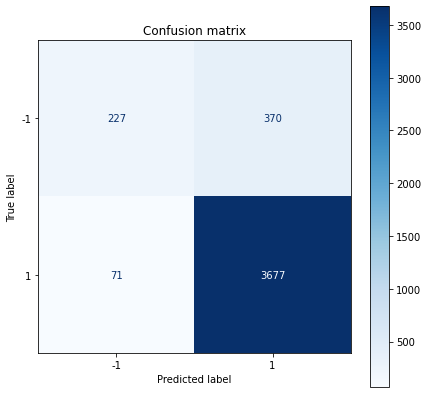

MLP Model with 3 hidden layers, each one 24 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.70      0.65      0.68       597
           1       0.95      0.96      0.95      3748

    accuracy                           0.91      4345
   macro avg       0.82      0.80      0.81      4345
weighted avg       0.91      0.91      0.91      4345

---------------------------------------------

Accuracy: 0.91


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


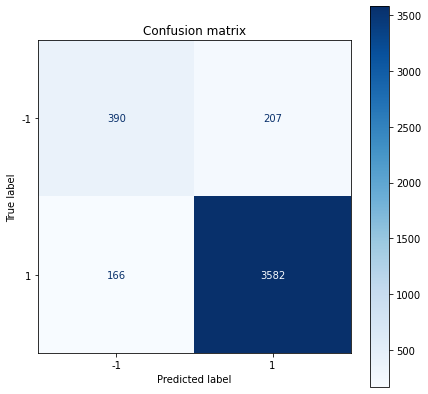

MLP Model with 3 hidden layers, each one 24 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

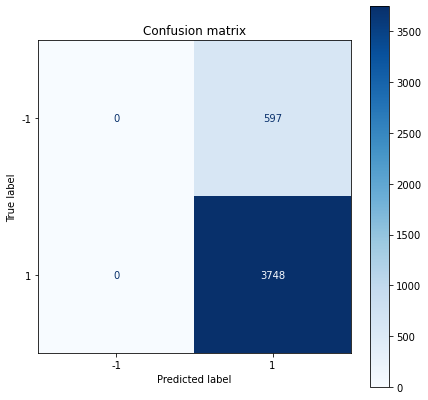

MLP Model with 3 hidden layers, each one 24 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.75      0.02      0.04       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.81      0.51      0.48      4345
weighted avg       0.85      0.86      0.81      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


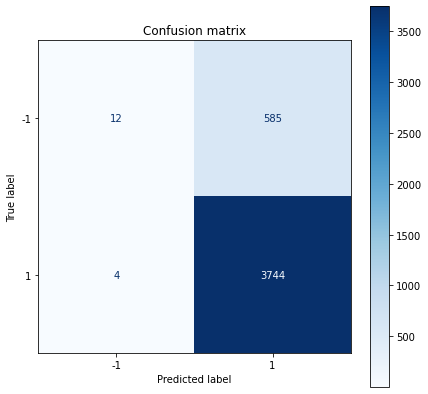

MLP Model with 3 hidden layers, each one 24 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.39      0.16      0.23       597
           1       0.88      0.96      0.92      3748

    accuracy                           0.85      4345
   macro avg       0.63      0.56      0.57      4345
weighted avg       0.81      0.85      0.82      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


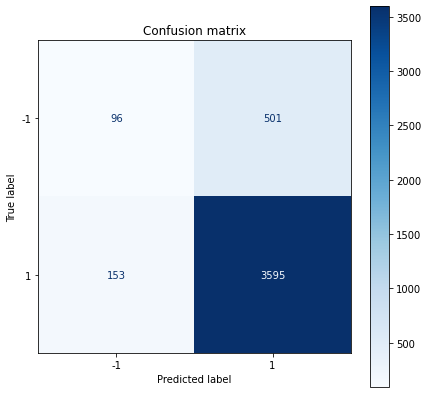

MLP Model with 3 hidden layers, each one 24 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.71      0.08      0.14       597
           1       0.87      1.00      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.79      0.54      0.53      4345
weighted avg       0.85      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


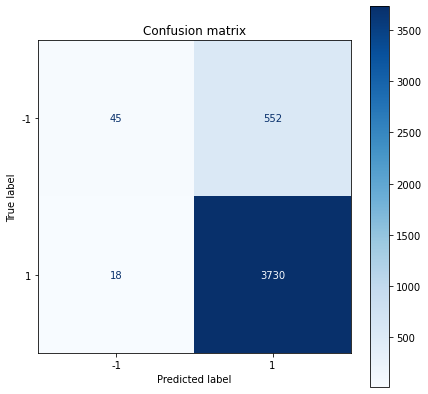

 71%|██████████████████████████████▋            | 15/21 [09:34<04:31, 45.22s/it]

----------------------------------------------------------------------------

Model 16
MLP Model with 3 hidden layers, each one 25 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.58      0.26      0.36       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.74      0.62      0.64      4345
weighted avg       0.85      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


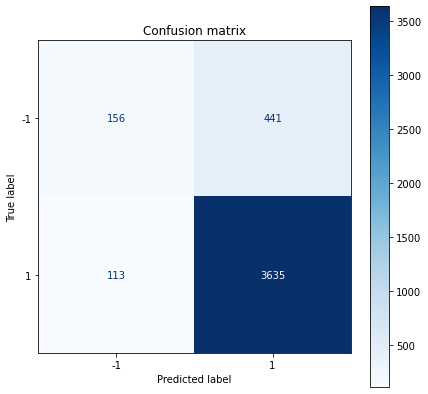

MLP Model with 3 hidden layers, each one 25 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.70      0.63      0.66       597
           1       0.94      0.96      0.95      3748

    accuracy                           0.91      4345
   macro avg       0.82      0.79      0.81      4345
weighted avg       0.91      0.91      0.91      4345

---------------------------------------------

Accuracy: 0.91


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


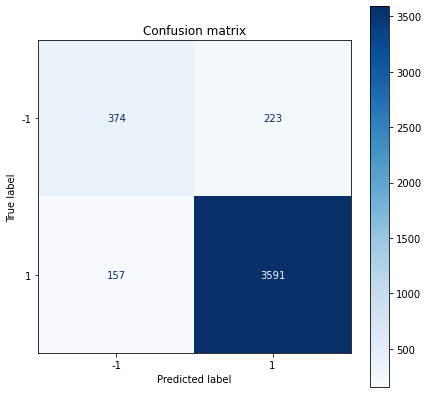

MLP Model with 3 hidden layers, each one 25 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.73      0.45      0.56       597
           1       0.92      0.97      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.82      0.71      0.75      4345
weighted avg       0.89      0.90      0.89      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


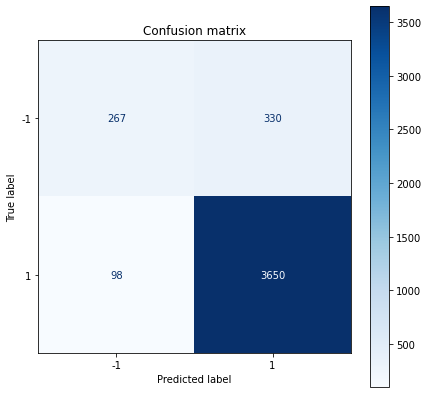

MLP Model with 3 hidden layers, each one 25 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.60      0.72      0.65       597
           1       0.95      0.92      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.78      0.82      0.80      4345
weighted avg       0.90      0.89      0.90      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


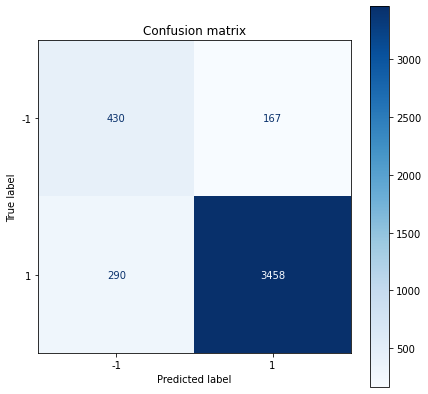

MLP Model with 3 hidden layers, each one 25 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.70      0.77      0.74       597
           1       0.96      0.95      0.96      3748

    accuracy                           0.92      4345
   macro avg       0.83      0.86      0.85      4345
weighted avg       0.93      0.92      0.93      4345

---------------------------------------------

Accuracy: 0.92


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


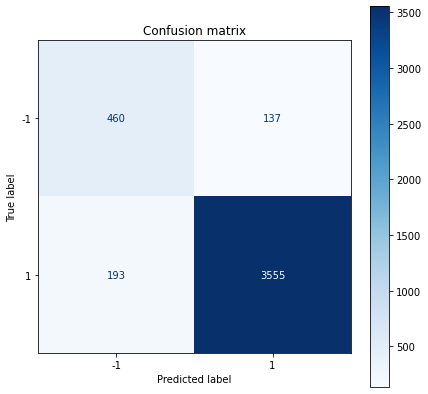

MLP Model with 3 hidden layers, each one 25 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.49      0.55       597
           1       0.92      0.96      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.78      0.72      0.74      4345
weighted avg       0.88      0.89      0.88      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


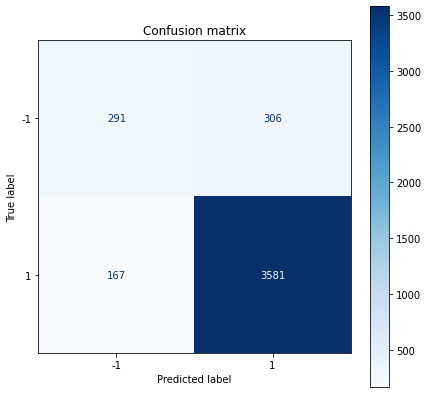

MLP Model with 3 hidden layers, each one 25 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.68      0.32      0.43       597
           1       0.90      0.98      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.79      0.65      0.68      4345
weighted avg       0.87      0.89      0.87      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


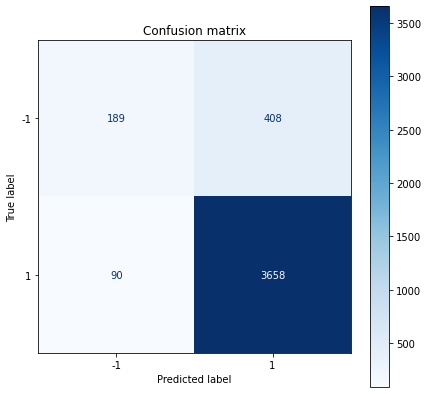

MLP Model with 3 hidden layers, each one 25 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.22      0.33       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.76      0.60      0.63      4345
weighted avg       0.85      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


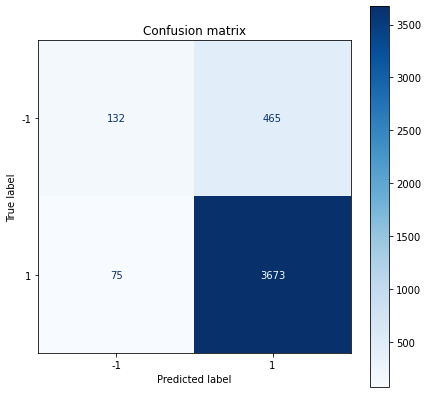

MLP Model with 3 hidden layers, each one 25 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.62      0.12      0.19       597
           1       0.88      0.99      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.75      0.55      0.56      4345
weighted avg       0.84      0.87      0.83      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


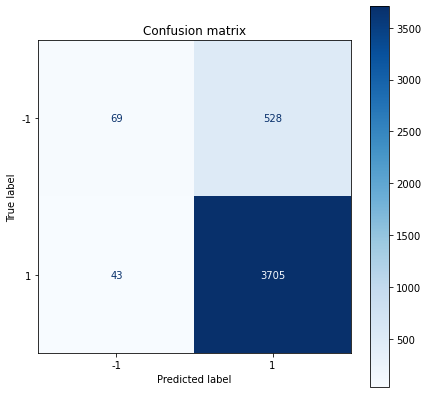

MLP Model with 3 hidden layers, each one 25 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.72      0.68       597
           1       0.96      0.94      0.94      3748

    accuracy                           0.91      4345
   macro avg       0.80      0.83      0.81      4345
weighted avg       0.91      0.91      0.91      4345

---------------------------------------------

Accuracy: 0.91


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


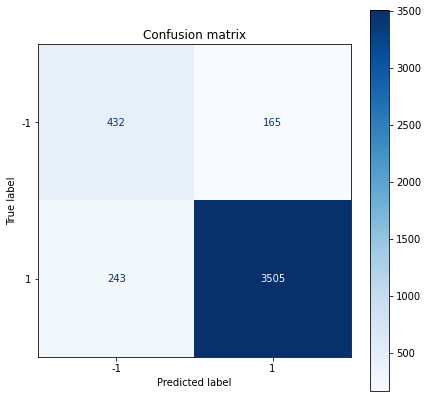

MLP Model with 3 hidden layers, each one 25 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.44      0.22      0.30       597
           1       0.89      0.96      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.67      0.59      0.61      4345
weighted avg       0.82      0.86      0.83      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


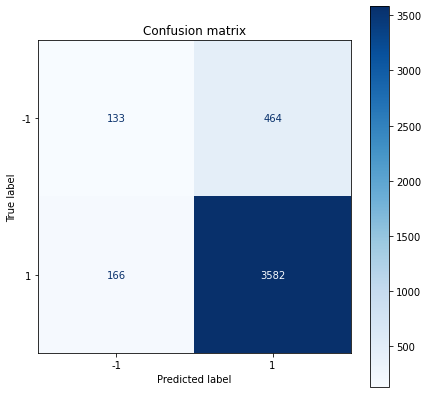

 76%|████████████████████████████████▊          | 16/21 [10:33<04:06, 49.34s/it]

----------------------------------------------------------------------------

Model 17
MLP Model with 3 hidden layers, each one 26 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.83      0.62      0.71       597
           1       0.94      0.98      0.96      3748

    accuracy                           0.93      4345
   macro avg       0.88      0.80      0.84      4345
weighted avg       0.93      0.93      0.93      4345

---------------------------------------------

Accuracy: 0.93


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


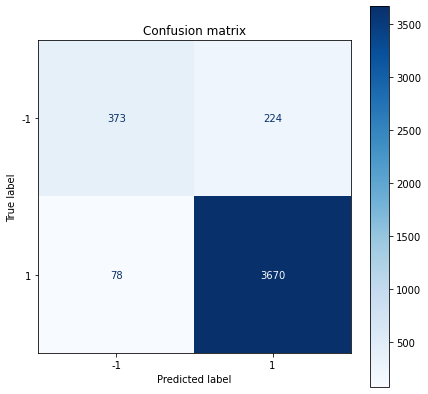

MLP Model with 3 hidden layers, each one 26 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.58      0.23      0.33       597
           1       0.89      0.97      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.73      0.60      0.63      4345
weighted avg       0.85      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


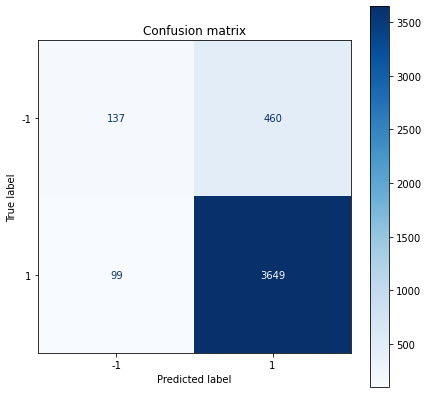

MLP Model with 3 hidden layers, each one 26 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.76      0.66      0.71       597
           1       0.95      0.97      0.96      3748

    accuracy                           0.92      4345
   macro avg       0.85      0.81      0.83      4345
weighted avg       0.92      0.92      0.92      4345

---------------------------------------------

Accuracy: 0.92


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


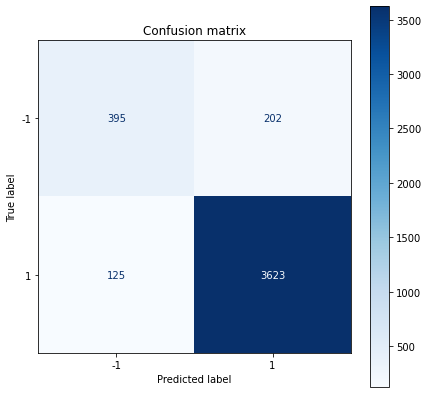

MLP Model with 3 hidden layers, each one 26 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.65      0.34      0.45       597
           1       0.90      0.97      0.94      3748

    accuracy                           0.88      4345
   macro avg       0.77      0.66      0.69      4345
weighted avg       0.87      0.88      0.87      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


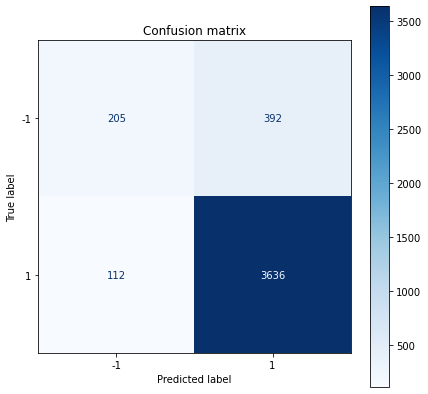

MLP Model with 3 hidden layers, each one 26 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.59      0.56      0.58       597
           1       0.93      0.94      0.93      3748

    accuracy                           0.89      4345
   macro avg       0.76      0.75      0.76      4345
weighted avg       0.88      0.89      0.89      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


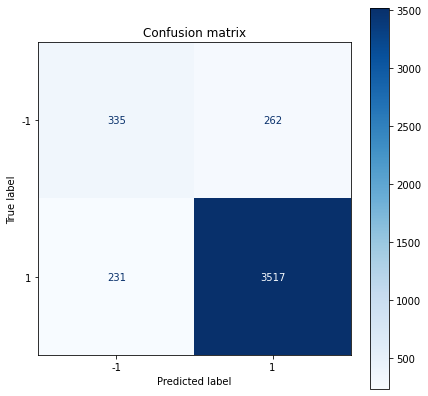

MLP Model with 3 hidden layers, each one 26 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.60      0.53      0.56       597
           1       0.93      0.94      0.93      3748

    accuracy                           0.89      4345
   macro avg       0.76      0.74      0.75      4345
weighted avg       0.88      0.89      0.88      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


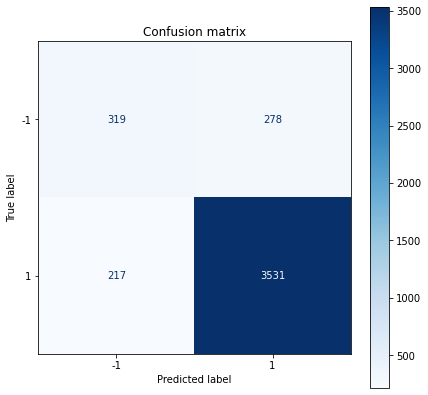

MLP Model with 3 hidden layers, each one 26 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.81      0.20      0.32       597
           1       0.89      0.99      0.94      3748

    accuracy                           0.88      4345
   macro avg       0.85      0.60      0.63      4345
weighted avg       0.88      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


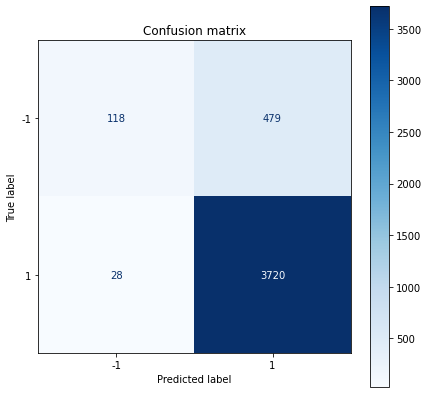

MLP Model with 3 hidden layers, each one 26 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.72      0.58      0.65       597
           1       0.94      0.96      0.95      3748

    accuracy                           0.91      4345
   macro avg       0.83      0.77      0.80      4345
weighted avg       0.91      0.91      0.91      4345

---------------------------------------------

Accuracy: 0.91


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


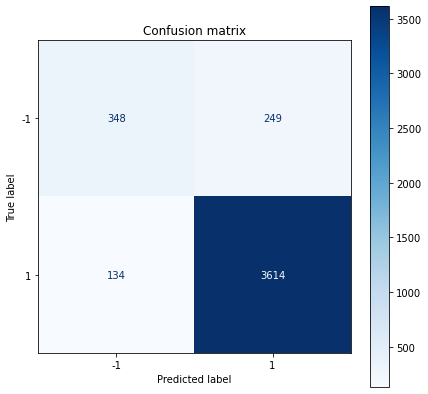

MLP Model with 3 hidden layers, each one 26 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.49      0.59      0.53       597
           1       0.93      0.90      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.71      0.75      0.73      4345
weighted avg       0.87      0.86      0.86      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


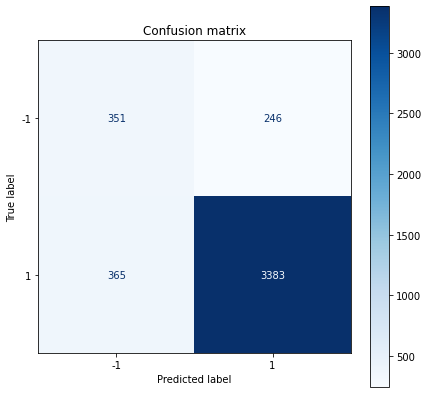

MLP Model with 3 hidden layers, each one 26 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.53      0.66      0.59       597
           1       0.94      0.91      0.92      3748

    accuracy                           0.87      4345
   macro avg       0.74      0.78      0.76      4345
weighted avg       0.89      0.87      0.88      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


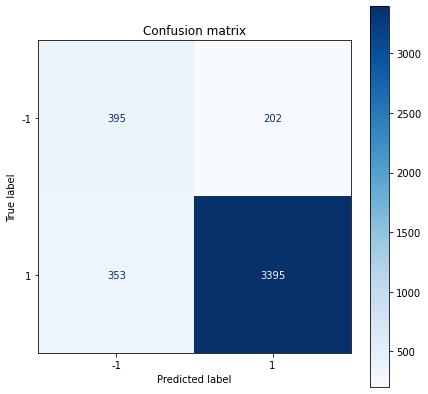

MLP Model with 3 hidden layers, each one 26 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.90      0.04      0.08       597
           1       0.87      1.00      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.88      0.52      0.51      4345
weighted avg       0.87      0.87      0.81      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


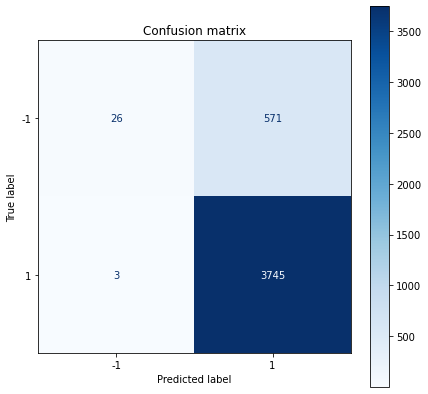

 81%|██████████████████████████████████▊        | 17/21 [11:22<03:17, 49.37s/it]

----------------------------------------------------------------------------

Model 18
MLP Model with 3 hidden layers, each one 27 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.67      0.49      0.57       597
           1       0.92      0.96      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.80      0.73      0.75      4345
weighted avg       0.89      0.90      0.89      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


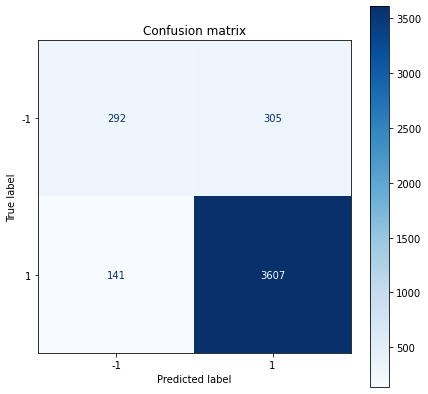

MLP Model with 3 hidden layers, each one 27 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.73      0.31      0.43       597
           1       0.90      0.98      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.81      0.64      0.68      4345
weighted avg       0.88      0.89      0.87      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


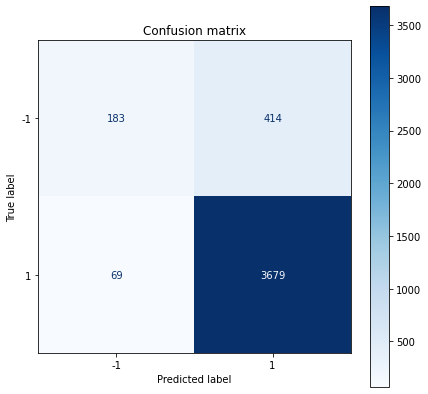

MLP Model with 3 hidden layers, each one 27 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.43      0.50      0.46      4345
weighted avg       0.74      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shehata/.local/lib/python3.8/si

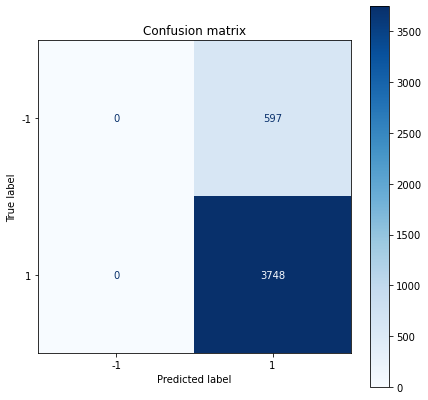

MLP Model with 3 hidden layers, each one 27 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.58      0.50      0.54       597
           1       0.92      0.94      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.75      0.72      0.74      4345
weighted avg       0.88      0.88      0.88      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


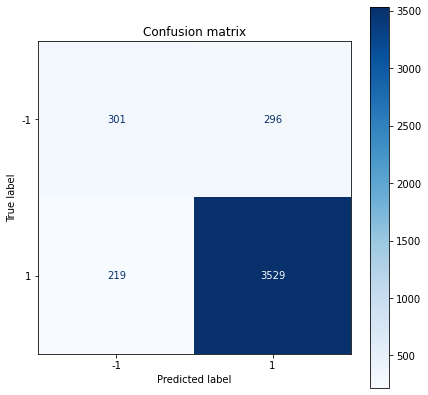

MLP Model with 3 hidden layers, each one 27 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.79      0.78      0.79       597
           1       0.97      0.97      0.97      3748

    accuracy                           0.94      4345
   macro avg       0.88      0.88      0.88      4345
weighted avg       0.94      0.94      0.94      4345

---------------------------------------------

Accuracy: 0.94


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


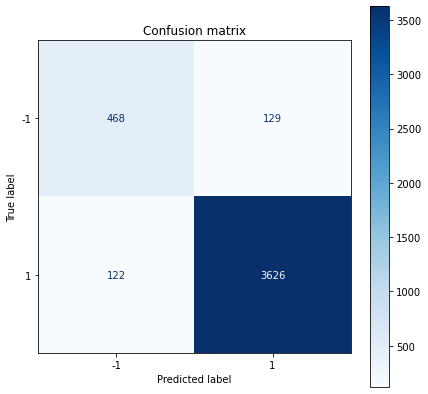

MLP Model with 3 hidden layers, each one 27 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.76      0.69       597
           1       0.96      0.93      0.95      3748

    accuracy                           0.91      4345
   macro avg       0.80      0.84      0.82      4345
weighted avg       0.92      0.91      0.91      4345

---------------------------------------------

Accuracy: 0.91


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


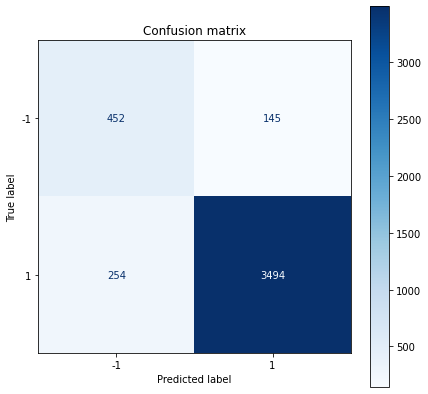

MLP Model with 3 hidden layers, each one 27 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.68      0.57      0.62       597
           1       0.93      0.96      0.95      3748

    accuracy                           0.90      4345
   macro avg       0.81      0.77      0.78      4345
weighted avg       0.90      0.90      0.90      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


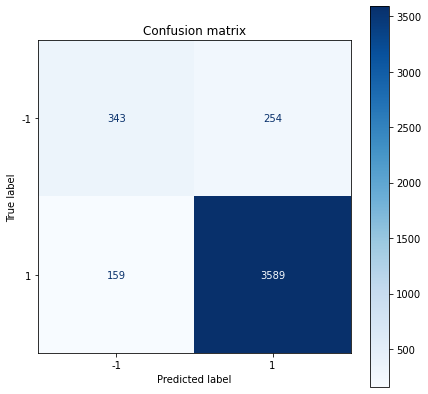

MLP Model with 3 hidden layers, each one 27 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.53      0.79      0.63       597
           1       0.96      0.89      0.92      3748

    accuracy                           0.87      4345
   macro avg       0.75      0.84      0.78      4345
weighted avg       0.90      0.87      0.88      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


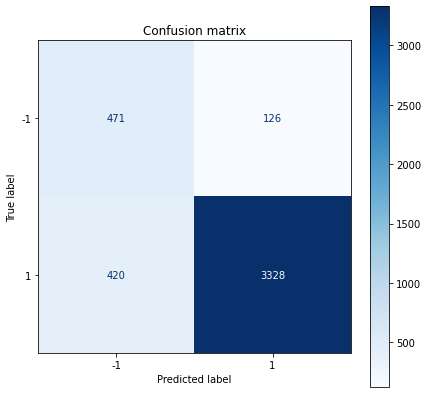

MLP Model with 3 hidden layers, each one 27 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.67      0.70      0.69       597
           1       0.95      0.95      0.95      3748

    accuracy                           0.91      4345
   macro avg       0.81      0.82      0.82      4345
weighted avg       0.91      0.91      0.91      4345

---------------------------------------------

Accuracy: 0.91


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


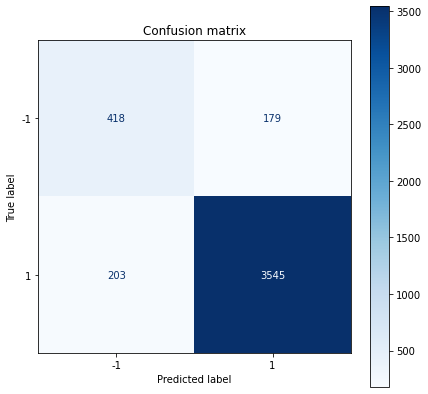

MLP Model with 3 hidden layers, each one 27 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.58      0.70      0.63       597
           1       0.95      0.92      0.93      3748

    accuracy                           0.89      4345
   macro avg       0.77      0.81      0.78      4345
weighted avg       0.90      0.89      0.89      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


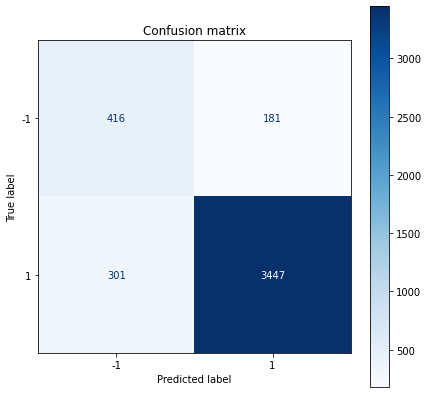

MLP Model with 3 hidden layers, each one 27 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.57      0.39      0.46       597
           1       0.91      0.95      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.74      0.67      0.70      4345
weighted avg       0.86      0.88      0.87      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


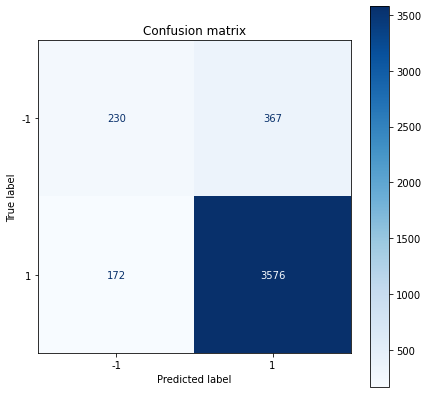

 86%|████████████████████████████████████▊      | 18/21 [12:18<02:33, 51.20s/it]

----------------------------------------------------------------------------

Model 19
MLP Model with 3 hidden layers, each one 28 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.65      0.48      0.55       597
           1       0.92      0.96      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.79      0.72      0.74      4345
weighted avg       0.88      0.89      0.89      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


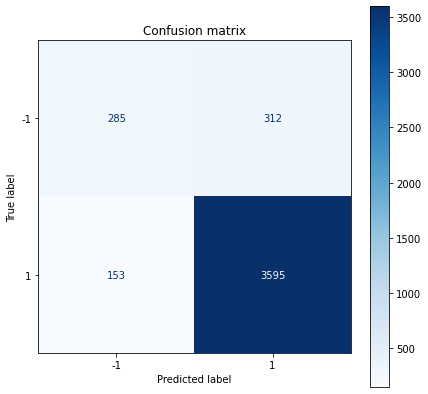

MLP Model with 3 hidden layers, each one 28 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.60      0.53      0.56       597
           1       0.93      0.94      0.93      3748

    accuracy                           0.89      4345
   macro avg       0.76      0.74      0.75      4345
weighted avg       0.88      0.89      0.88      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


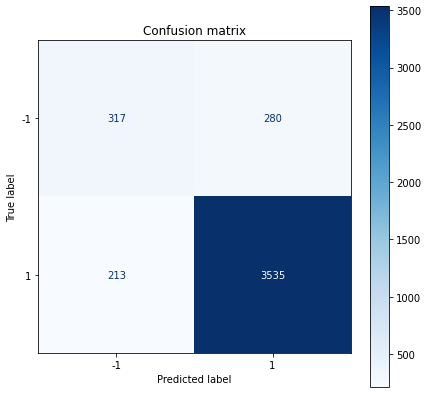

MLP Model with 3 hidden layers, each one 28 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.61      0.30      0.40       597
           1       0.90      0.97      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.76      0.63      0.67      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


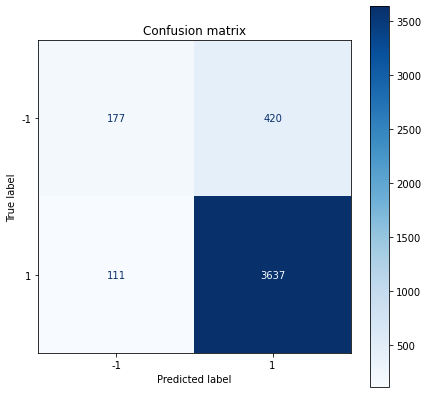

MLP Model with 3 hidden layers, each one 28 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.64      0.36      0.46       597
           1       0.90      0.97      0.94      3748

    accuracy                           0.88      4345
   macro avg       0.77      0.66      0.70      4345
weighted avg       0.87      0.88      0.87      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


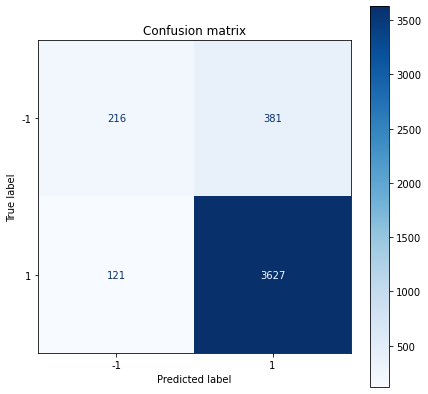

MLP Model with 3 hidden layers, each one 28 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.83      0.13      0.23       597
           1       0.88      1.00      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.85      0.56      0.58      4345
weighted avg       0.87      0.88      0.84      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


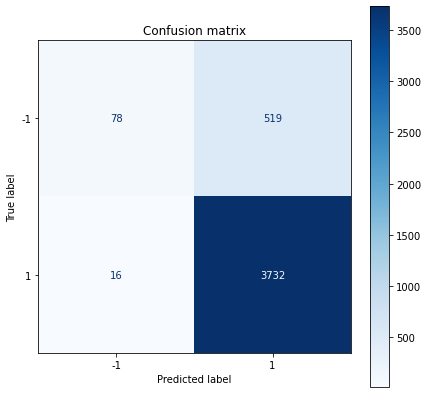

MLP Model with 3 hidden layers, each one 28 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.74      0.69      0.71       597
           1       0.95      0.96      0.96      3748

    accuracy                           0.92      4345
   macro avg       0.84      0.82      0.83      4345
weighted avg       0.92      0.92      0.92      4345

---------------------------------------------

Accuracy: 0.92


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


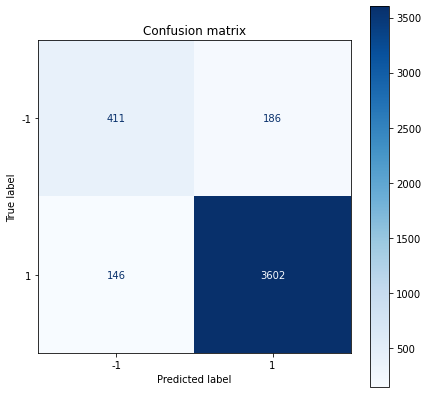

MLP Model with 3 hidden layers, each one 28 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.62      0.29      0.40       597
           1       0.90      0.97      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.76      0.63      0.66      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


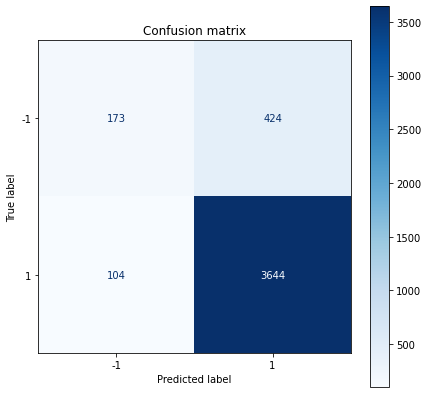

MLP Model with 3 hidden layers, each one 28 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.63      0.29      0.40       597
           1       0.90      0.97      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.77      0.63      0.66      4345
weighted avg       0.86      0.88      0.86      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


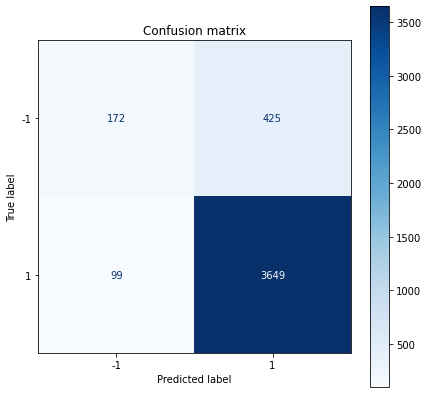

MLP Model with 3 hidden layers, each one 28 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.62      0.52      0.56       597
           1       0.93      0.95      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.77      0.73      0.75      4345
weighted avg       0.88      0.89      0.89      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


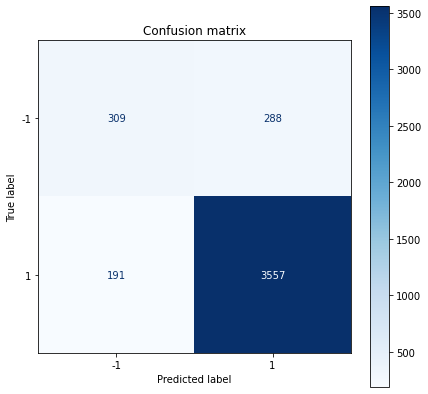

MLP Model with 3 hidden layers, each one 28 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.60      0.02      0.03       597
           1       0.86      1.00      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.73      0.51      0.48      4345
weighted avg       0.83      0.86      0.80      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


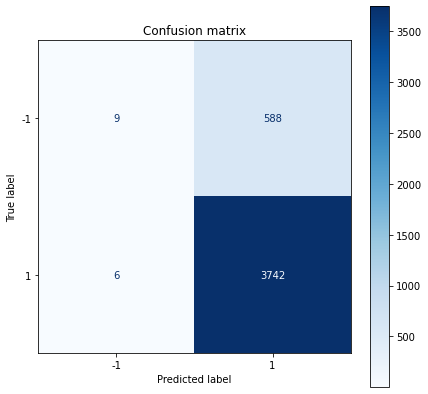

MLP Model with 3 hidden layers, each one 28 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.69      0.51      0.59       597
           1       0.92      0.96      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.81      0.74      0.77      4345
weighted avg       0.89      0.90      0.90      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


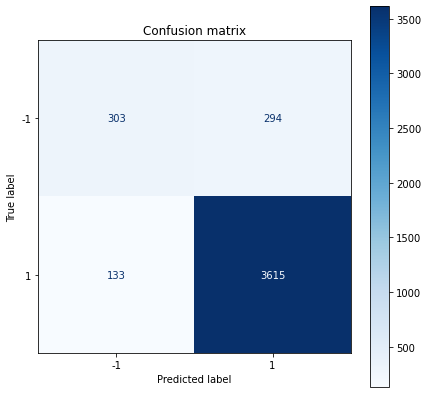

 90%|██████████████████████████████████████▉    | 19/21 [13:07<01:41, 50.72s/it]

----------------------------------------------------------------------------

Model 20
MLP Model with 3 hidden layers, each one 29 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.81      0.08      0.14       597
           1       0.87      1.00      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.84      0.54      0.54      4345
weighted avg       0.86      0.87      0.82      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


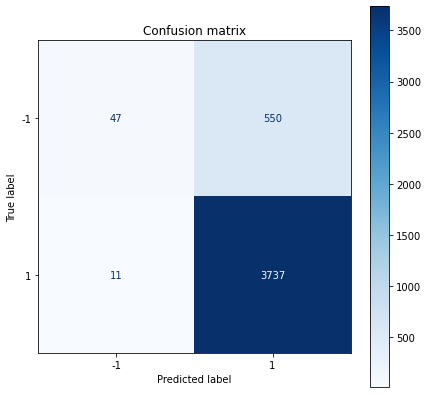

MLP Model with 3 hidden layers, each one 29 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.42      0.47      0.45       597
           1       0.91      0.90      0.91      3748

    accuracy                           0.84      4345
   macro avg       0.67      0.68      0.68      4345
weighted avg       0.85      0.84      0.84      4345

---------------------------------------------

Accuracy: 0.84


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


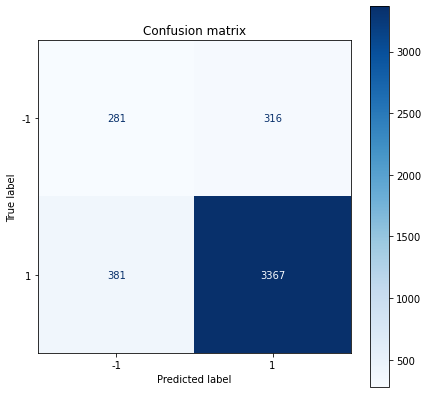

MLP Model with 3 hidden layers, each one 29 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.53      0.76      0.62       597
           1       0.96      0.89      0.92      3748

    accuracy                           0.87      4345
   macro avg       0.74      0.82      0.77      4345
weighted avg       0.90      0.87      0.88      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


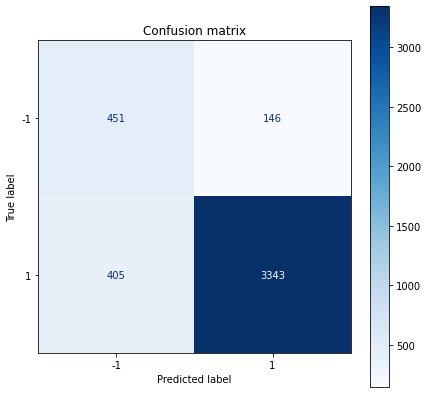

MLP Model with 3 hidden layers, each one 29 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.66      0.38      0.48       597
           1       0.91      0.97      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.79      0.67      0.71      4345
weighted avg       0.87      0.89      0.87      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


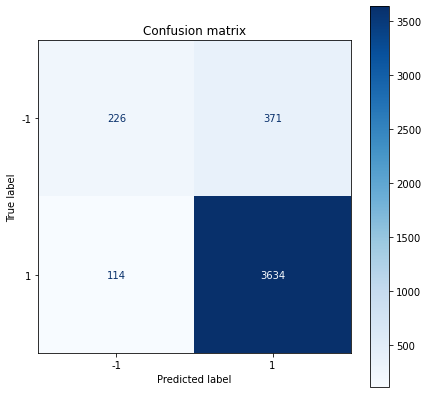

MLP Model with 3 hidden layers, each one 29 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.53      0.91      0.67       597
           1       0.98      0.87      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.76      0.89      0.80      4345
weighted avg       0.92      0.88      0.89      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


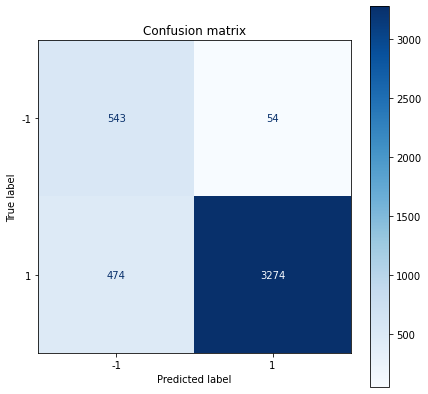

MLP Model with 3 hidden layers, each one 29 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.62      0.50      0.55       597
           1       0.92      0.95      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.77      0.72      0.75      4345
weighted avg       0.88      0.89      0.88      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


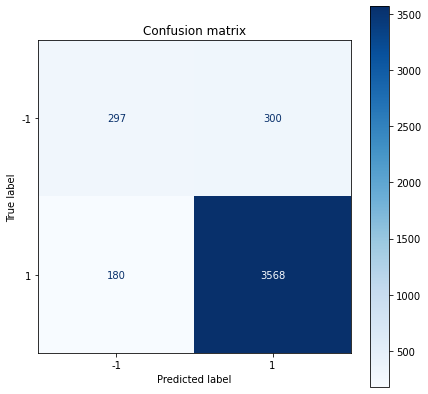

MLP Model with 3 hidden layers, each one 29 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.66      0.49      0.56       597
           1       0.92      0.96      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.79      0.72      0.75      4345
weighted avg       0.89      0.89      0.89      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


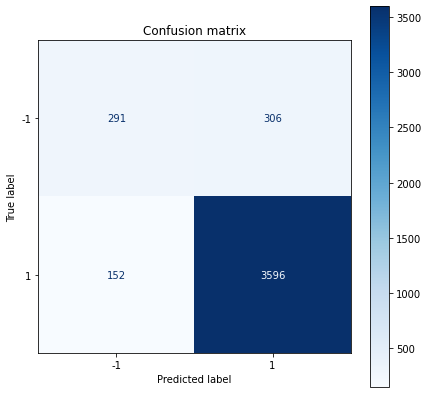

MLP Model with 3 hidden layers, each one 29 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.83      0.17      0.29       597
           1       0.88      0.99      0.94      3748

    accuracy                           0.88      4345
   macro avg       0.86      0.58      0.61      4345
weighted avg       0.88      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


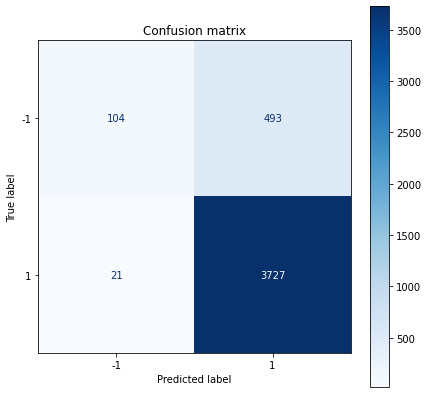

MLP Model with 3 hidden layers, each one 29 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.68      0.49      0.57       597
           1       0.92      0.96      0.94      3748

    accuracy                           0.90      4345
   macro avg       0.80      0.73      0.76      4345
weighted avg       0.89      0.90      0.89      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


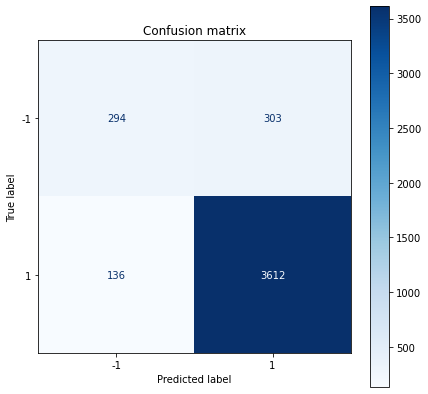

MLP Model with 3 hidden layers, each one 29 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.68      0.32      0.44       597
           1       0.90      0.98      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.79      0.65      0.69      4345
weighted avg       0.87      0.89      0.87      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


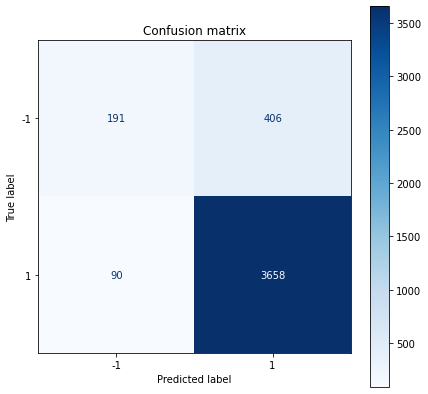

MLP Model with 3 hidden layers, each one 29 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.78      0.27      0.40       597
           1       0.89      0.99      0.94      3748

    accuracy                           0.89      4345
   macro avg       0.83      0.63      0.67      4345
weighted avg       0.88      0.89      0.86      4345

---------------------------------------------

Accuracy: 0.89


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


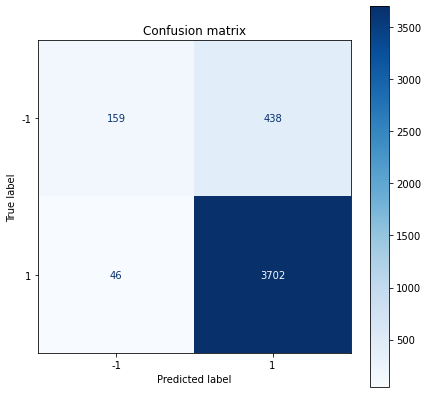

 95%|████████████████████████████████████████▉  | 20/21 [14:08<00:53, 53.77s/it]

----------------------------------------------------------------------------

Model 21
MLP Model with 3 hidden layers, each one 30 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.51      0.69      0.59       597
           1       0.95      0.89      0.92      3748

    accuracy                           0.87      4345
   macro avg       0.73      0.79      0.75      4345
weighted avg       0.89      0.87      0.87      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


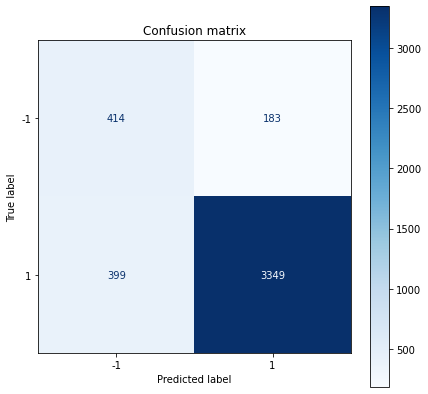

MLP Model with 3 hidden layers, each one 30 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.82      0.36      0.50       597
           1       0.91      0.99      0.95      3748

    accuracy                           0.90      4345
   macro avg       0.86      0.67      0.72      4345
weighted avg       0.89      0.90      0.88      4345

---------------------------------------------

Accuracy: 0.90


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


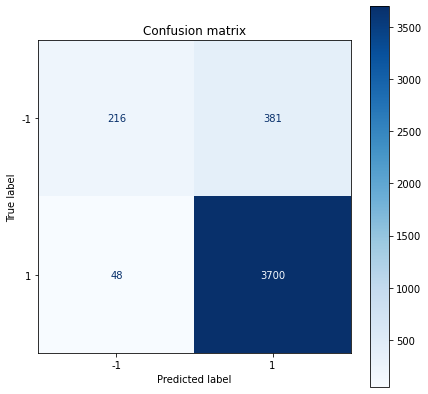

MLP Model with 3 hidden layers, each one 30 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.53      0.13      0.21       597
           1       0.88      0.98      0.93      3748

    accuracy                           0.86      4345
   macro avg       0.70      0.56      0.57      4345
weighted avg       0.83      0.86      0.83      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


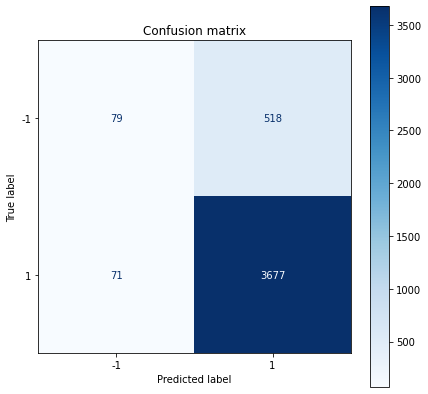

MLP Model with 3 hidden layers, each one 30 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.54      0.27      0.37       597
           1       0.89      0.96      0.93      3748

    accuracy                           0.87      4345
   macro avg       0.72      0.62      0.65      4345
weighted avg       0.85      0.87      0.85      4345

---------------------------------------------

Accuracy: 0.87


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


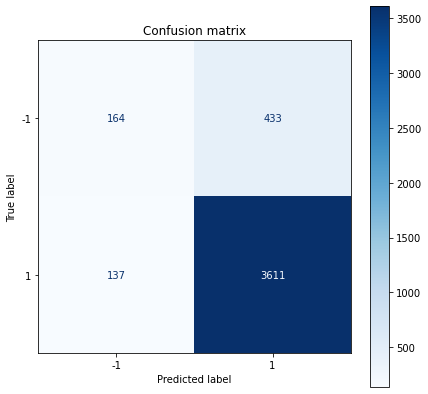

MLP Model with 3 hidden layers, each one 30 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.66      0.87      0.75       597
           1       0.98      0.93      0.95      3748

    accuracy                           0.92      4345
   macro avg       0.82      0.90      0.85      4345
weighted avg       0.93      0.92      0.92      4345

---------------------------------------------

Accuracy: 0.92


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


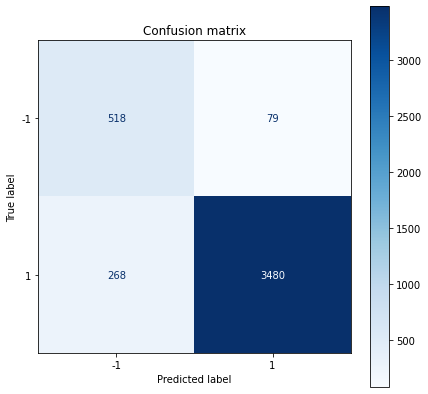

MLP Model with 3 hidden layers, each one 30 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.41      0.05      0.09       597
           1       0.87      0.99      0.92      3748

    accuracy                           0.86      4345
   macro avg       0.64      0.52      0.51      4345
weighted avg       0.80      0.86      0.81      4345

---------------------------------------------

Accuracy: 0.86


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


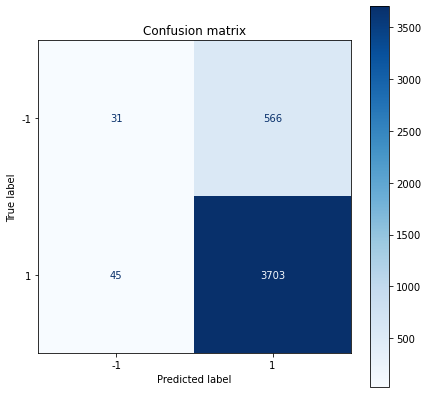

MLP Model with 3 hidden layers, each one 30 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.67      0.69      0.68       597
           1       0.95      0.94      0.95      3748

    accuracy                           0.91      4345
   macro avg       0.81      0.82      0.81      4345
weighted avg       0.91      0.91      0.91      4345

---------------------------------------------

Accuracy: 0.91


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


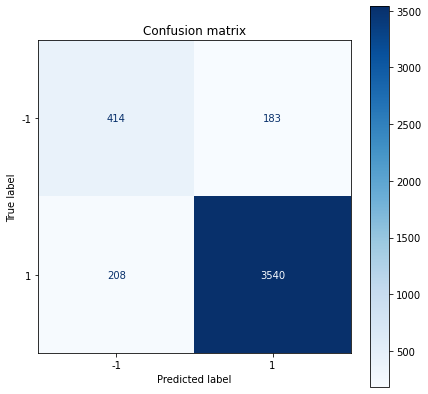

MLP Model with 3 hidden layers, each one 30 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.55      0.72      0.63       597
           1       0.95      0.91      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.75      0.81      0.78      4345
weighted avg       0.90      0.88      0.89      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


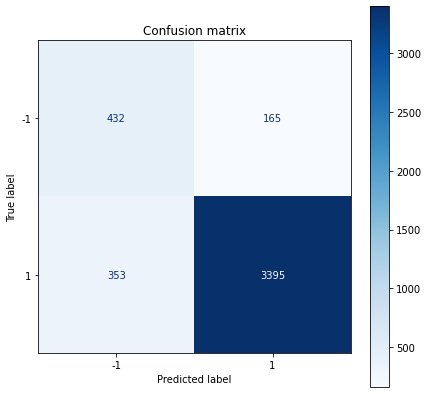

MLP Model with 3 hidden layers, each one 30 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.72      0.74      0.73       597
           1       0.96      0.95      0.96      3748

    accuracy                           0.92      4345
   macro avg       0.84      0.85      0.84      4345
weighted avg       0.92      0.92      0.92      4345

---------------------------------------------

Accuracy: 0.92


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


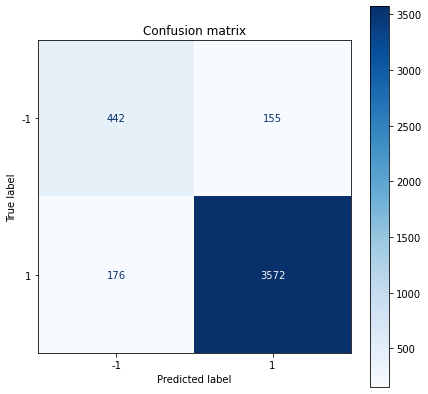

MLP Model with 3 hidden layers, each one 30 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.47      0.71      0.56       597
           1       0.95      0.87      0.91      3748

    accuracy                           0.85      4345
   macro avg       0.71      0.79      0.74      4345
weighted avg       0.88      0.85      0.86      4345

---------------------------------------------

Accuracy: 0.85


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


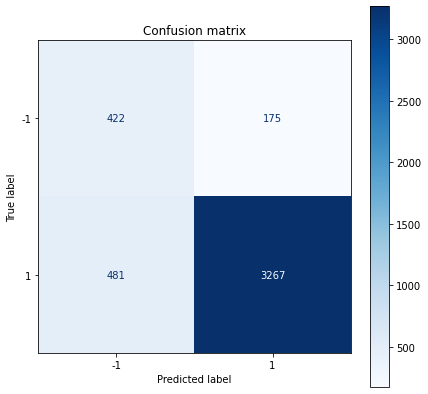

MLP Model with 3 hidden layers, each one 30 neuron 


Classification Report:

              precision    recall  f1-score   support

          -1       0.69      0.24      0.35       597
           1       0.89      0.98      0.93      3748

    accuracy                           0.88      4345
   macro avg       0.79      0.61      0.64      4345
weighted avg       0.86      0.88      0.85      4345

---------------------------------------------

Accuracy: 0.88


Confusion Matrix:


/home/shehata/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


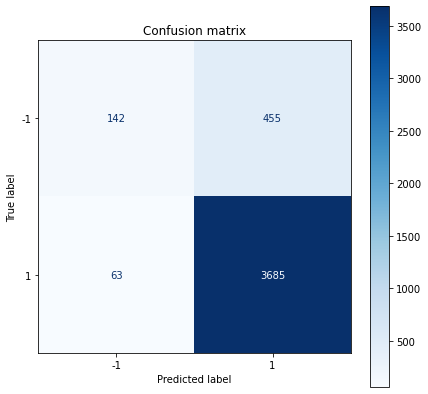

100%|███████████████████████████████████████████| 21/21 [15:08<00:00, 43.28s/it]

----------------------------------------------------------------------------



In [144]:
acc_lst_neurons = []
acc_neurons_all = []
n_neurons = []
for i in tqdm(range(10, 31)):
    n_neurons.append(i)
    for j in range(0,11):
        print("MLP Model {} with {} hidden layers, each one {} neuron \n".format((i-9), idx_max_layer+3, i))
    
        mlp7 = MLPClassifier(activation='tanh',
                            batch_size= 64,
                            n_iter_no_change = 5,
                            learning_rate_init= 0.2,
                            momentum= 0.9,
                            solver= 'sgd',   
                            hidden_layer_sizes = (i, i, i))
        
        mlp_model7, mlp_pred7, mlp_acc7 = build_model(mlp7, pred_train_list[0], pred_test_list[0], y_train, y_test)
        acc_lst_neurons.append(round(mlp_acc7*100,3))  
    acc_neurons_all.append(acc_lst_neurons)    
    acc_lst_neurons = []
    print("----------------------------------------------------------------------------\n")

In [148]:
avg_lst_neuron_final = []
for i in range(len(acc_neurons_all)):
    avg_acc_neuron_last = np.mean(acc_neurons_all[i])
    avg_lst_neuron_final.append(round(avg_acc_neuron_last,3))
    print(avg_acc_neuron_last)
    max_avg_neuron = np.max(avg_lst_neuron_final)
print("\nMax neurons Acc: {:.3f}".format(max_avg_neuron))
idx_max_neuron = avg_lst_neuron_final.index(max_avg_neuron)
print("\nindex of best combinations of features is: ",idx_max_neuron)

86.78181818181817
86.45454545454547
87.38181818181819
87.37272727272727
86.52727272727272
87.41818181818182
87.47272727272725
87.20909090909092
86.95454545454547
87.2090909090909
87.76363636363637
86.55454545454546
87.30909090909091
87.65454545454546
88.21818181818182
88.97272727272728
88.88181818181818
89.41818181818182
88.68181818181819
88.10000000000001
88.39999999999999

Max neurons Acc: 89.418

index of best combinations of features is:  17


### Plot Tuned Neurons

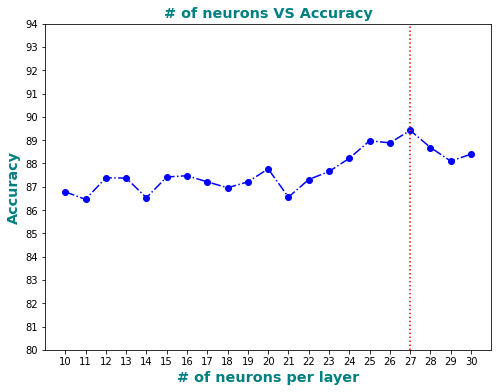

In [146]:
plt.figure(figsize=(8,6))

y_range = range(80,95)
n_neurons = range(10,31)
axis_11 = plt.plot(n_neurons, avg_lst_neuron_final, color='blue', marker='o', 
                   linestyle='dashdot')
plt.xlabel('# of neurons per layer', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.ylabel('Accuracy', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.title('# of neurons VS Accuracy', fontsize = 'x-large', fontweight ='bold', color = 'teal')
plt.yticks(y_range)
plt.axvline(x= n_neurons[idx_max_neuron], linestyle=':', color= 'red')
plt.xticks(n_neurons)
plt.show()

### Plot best MLP model from previous steps with baseline 

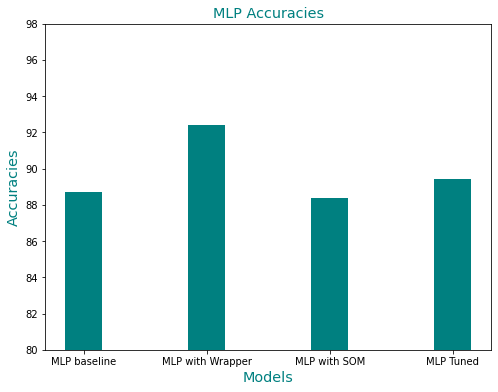

In [147]:
width =0.3 
plt.subplots(figsize=(8, 6))
plt.bar(['MLP baseline', 'MLP with Wrapper', 'MLP with SOM', 'MLP Tuned'],
        [avg_acc_baseline, mlp_wrapper_baseline, max_acc_som, max_avg_neuron],
        width= width,
        color ='teal')
plt.title('MLP Accuracies', fontsize = 'x-large', color = 'teal')
plt.ylabel('Accuracies', fontsize = 'x-large', color = 'teal')
plt.xlabel('Models', fontsize = 'x-large', color = 'teal')
plt.yticks(np.arange(80, 100, 2))
plt.ylim(ymin = 80)
plt.show()